In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import random
import scipy.stats as sts
pd.set_option('display.max_columns', 50)
from matplotlib.ticker import FormatStrFormatter
sns.set_style(style='whitegrid')
import random

# Préparation Données

In [2]:
def compare_stats(df, label):
    columns = sorted(list(df[label].unique()))
    index = [('count', 'count')]
    for i in range(len(df.columns)):
        index +=[(df.columns[i], 'mean'), (df.columns[i], 'min'), (df.columns[i], 'max')]
    index = pd.MultiIndex.from_tuples(index)
    compare = pd.DataFrame(index=index, columns=columns, data=0)
    for feature in df.columns:
        for col in compare.columns:
            compare.loc[(feature, 'mean'), col] = df.loc[df[label]==col, feature].mean()
            compare.loc[(feature, 'max'), col] = df.loc[df[label]==col, feature].max()
            compare.loc[(feature, 'min'), col] = df.loc[df[label]==col, feature].min()
            compare.loc[('count', 'count'), col] = df.loc[df[label]==col, feature].count()
    compare = compare.drop([(label, 'mean'), (label, 'min'), (label, 'max')])
    
    return compare   

In [291]:
def stability_KMeans(data, n_clust_min, n_clust_max):
    rand_mini = []
    rand_mean = []
    for n in range(n_clust_min, n_clust_max+1):
        rand = []
        km_ref = KMeans(n_clusters=n, random_state=0)
        km_ref.fit(data)
        clusters_ref = km_ref.labels_
        for i in range(10):
            r = random.randint(0, 100)
            km = KMeans(n_clusters= n, random_state=r)
            km.fit(data)
            clusters = km.labels_
            rand += [adjusted_rand_score(clusters_ref, clusters)]
        rand_mini += [min(rand)]
        rand_mean += [np.mean(rand)]
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    x = np.linspace(n_clust_min, n_clust_max, n_clust_max-n_clust_min+1)
    sns.lineplot(ax=ax[0], x=x, y=rand_mini)
    sns.lineplot(ax=ax[1], x=x, y=rand_mean)
    ax[0].set_xlabel('Nb of clusters', fontdict={'fontsize':12, 'weight':'bold'})
    ax[0].set_ylabel('Adjusted Rand Score - Mini', fontdict={'fontsize':12, 'weight':'bold'})
    ax[0].set_ylim(0, 1.1)
    ax[1].set_xlabel('Nb of clusters', fontdict={'fontsize':12, 'weight':'bold'})
    ax[1].set_ylabel('Adjusted Rand Score - Mean', fontdict={'fontsize':12, 'weight':'bold'})
    ax[1].set_ylim(0, 1.1)
    fig.suptitle('Stability KMeans', fontsize=14, weight='bold')

In [4]:
def effectif_clusters(data, col_label):
    effectifs = pd.DataFrame(data[col_label].value_counts()).reset_index()
    effectifs = effectifs.rename(columns={'index': 'label', col_label: 'count'})
    effectifs['percent'] = effectifs['count'] / effectifs['count'].sum()*100
    effectifs['percent'] = effectifs['percent'].apply(lambda x: round(x, 1))
    return effectifs

In [5]:
data = pd.read_csv('data_per_customer.csv').drop('Unnamed: 0', axis=1)

/var/folders/cg/rgv17yks2975h8b2p1c414640000gn/T/ipykernel_731/1998544909.py:1: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data_per_customer.csv').drop('Unnamed: 0', axis=1)


In [6]:
data_RFM = data.loc[:, ['customer_unique_id', 'R', 'F', 'M']]

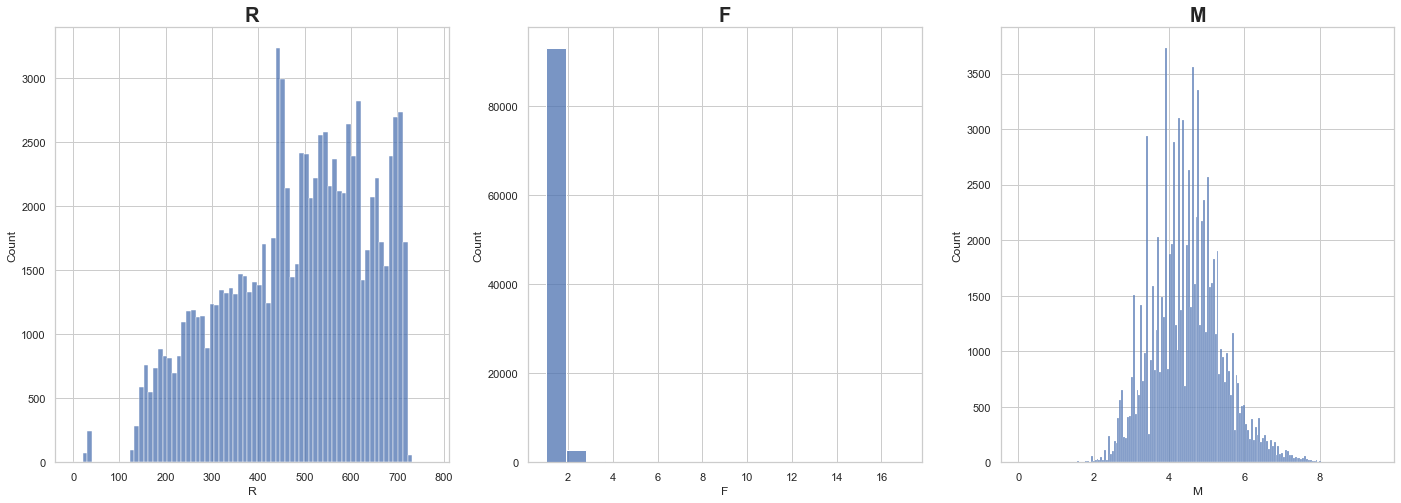

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(24, 8))
sns.histplot(ax=ax[0], data=data_RFM['R'])
sns.histplot(ax=ax[1], data=data_RFM['F'])
sns.histplot(ax=ax[2], data=np.log(1+data_RFM['M']))
ax[0].set_title('R', fontsize=20, weight='bold')
ax[1].set_title('F', fontsize=20, weight='bold')
ax[2].set_title('M', fontsize=20, weight='bold');

<AxesSubplot:xlabel='R', ylabel='M'>

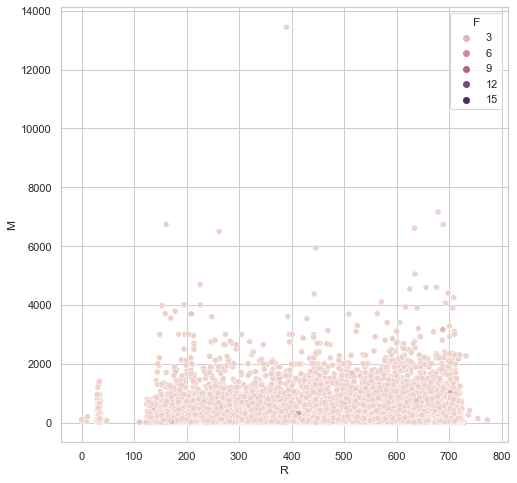

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(ax=ax, data=data_RFM, x='R', y='M', hue='F', alpha=1)

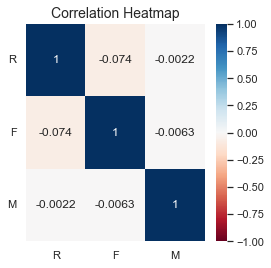

In [9]:
dataheat = data.loc[:, ['R', 'F', 'M']]
plt.figure(figsize=(4, 4))
sns.heatmap(dataheat.corr(),annot=True,cmap='RdBu', vmin=-1, vmax=1)
plt.title('Correlation Heatmap',fontsize=14)
plt.yticks(rotation =0);

# Clustering
## Définir le nombre de Cluster
### Transformation des features

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
dataK = data_RFM.loc[:, ['R', 'F', 'M']]
X_scaled1 = StandardScaler().fit_transform(dataK)

In [12]:
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import KMeans

### Distortion score

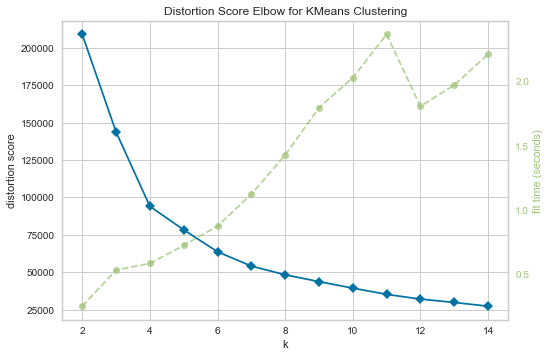

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
from yellowbrick.cluster import KElbowVisualizer
model1 = KMeans()
visualizer1 = KElbowVisualizer(model1, k=(2,15), locate_elbow=False)
visualizer1.fit(X_scaled1)   
visualizer1.poof()  

### Silhouette

In [14]:
# Echantillon
dataK_sample1 = dataK.sample(10000)
X_scaled_sample1 = StandardScaler().fit_transform(dataK_sample1)

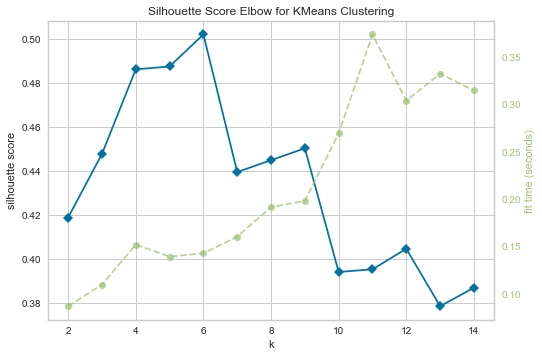

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [15]:
visualizer1 = KElbowVisualizer(model1, k=(2,15), metric='silhouette', locate_elbow=False)
visualizer1.fit(X_scaled_sample1)    
visualizer1.poof()  

### Silhouette score

In [16]:
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

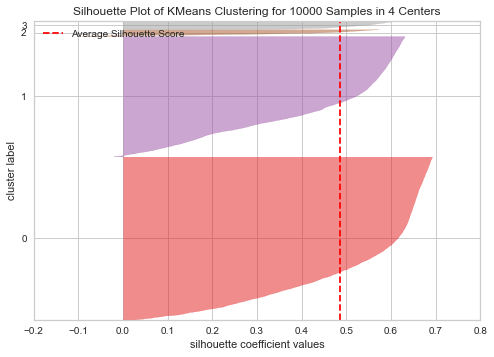

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 10000 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [17]:
model1 = KMeans(n_clusters=4)
visualizer1 = SilhouetteVisualizer(model1)
visualizer1.fit(X_scaled_sample1) 
visualizer1.poof()    

### Stability

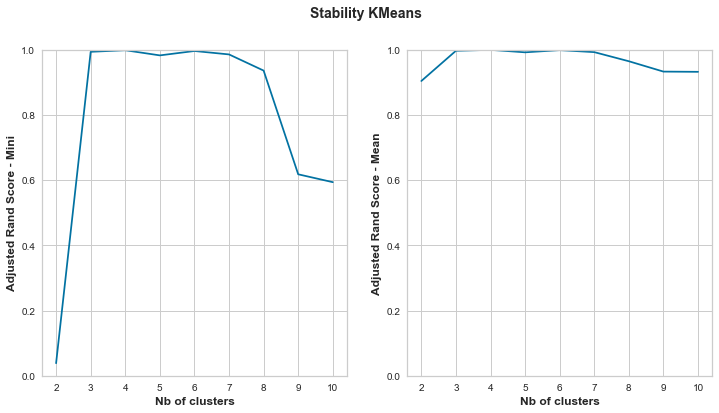

In [290]:
from sklearn.metrics import adjusted_rand_score
stability_KMeans(X_scaled1, 2, 10)

## Clustering avec 4 clusters

In [19]:
# Nombre de clusters souhaités
n_clust = 4
km14 = KMeans(n_clusters= n_clust, random_state=0)
km14.fit(X_scaled1)

# Récupération des clusters attribués à chaque individu
clusters14 = km14.labels_
clusters14

array([1, 1, 0, ..., 0, 1, 0], dtype=int32)

In [20]:
from sklearn.metrics import silhouette_samples
data_sample14 = pd.DataFrame(X_scaled1).sample(n=10000, replace=False)
index = data_sample14.index
silhouette_samples(data_sample14, clusters14[index]).mean()

0.487642428717672

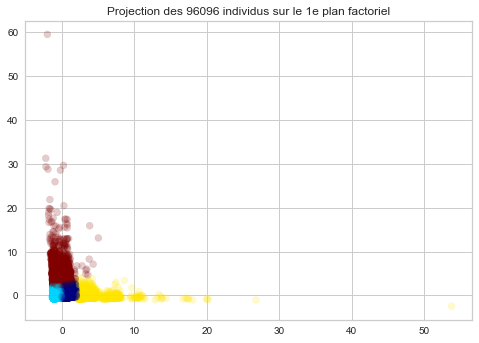

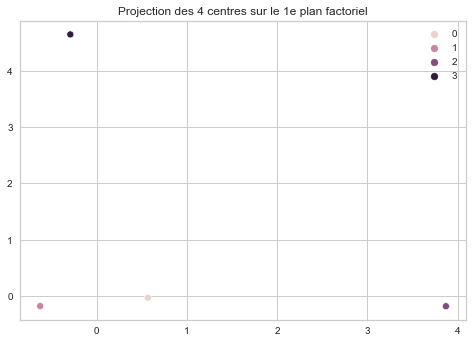

In [21]:
# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=3).fit(X_scaled1)
X_projected = pca.transform(X_scaled1)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters14.astype(np.float64), cmap = 'jet', alpha=.2)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show(block=False)

plt.figure()
centroids = km14.cluster_centers_
centroids_projected = pca.transform(centroids)
sns.scatterplot(x=centroids_projected[:,0],y=centroids_projected[:,1], hue=[0, 1, 2, 3])
plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids)))
plt.show()

### Etude statistique de chaque cluster

In [22]:
data_stat14 = data.loc[:, ['R', 'F', 'M']]
data_stat14['label'] = clusters14

In [23]:
data_stat14['label'].value_counts()

1    52167
0    38616
2     2987
3     2326
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='M'>

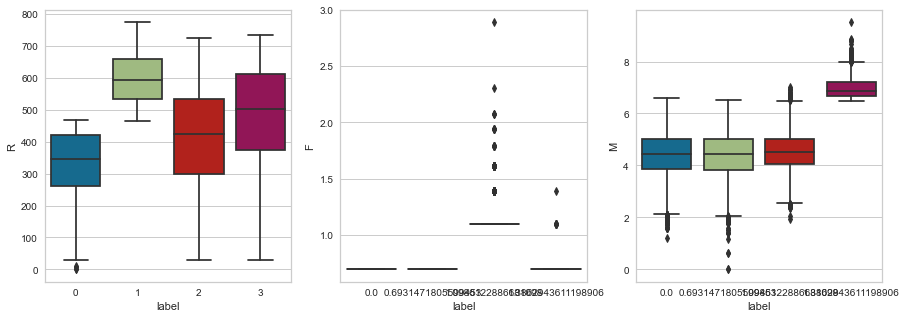

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(ax= ax[0], data=data_stat14, x='label', y='R')
sns.boxplot(ax= ax[1], data=np.log(1+data_stat14), x='label', y='F')
sns.boxplot(ax= ax[2], data=np.log(1+data_stat14), x='label', y='M')

In [25]:
# Profil 1 : un seul achat, achat récent (< 466 jours), montant peu élevé < 704 euros
# Profil 0 : un seul achat, achat ancien (> 465 jours), montant peu élevé < 756 euros
# Profil 3 : montant élévé > 640 euro et moins de 4 achats
# Profil 2 : 2 achats et plus et montant < 2 550 euros

In [26]:
compare_stats(data_stat14, 'label')

0             1            2             3
count count  3.861600e+04  52167.000000  2987.000000   2326.000000
R     mean   3.345642e+02    595.034006   417.143288    484.850387
      min    5.684342e-14    465.000000    29.000000     30.000000
      max    4.660000e+02    773.000000   724.000000    732.000000
F     mean   1.000000e+00      1.000000     2.116170      1.004729
      min    1.000000e+00      1.000000     2.000000      1.000000
      max    1.000000e+00      1.000000    17.000000      3.000000
M     mean   1.175853e+02    116.122163   127.397337   1179.857006
      min    2.290000e+00      0.000000     5.990000    639.920000
      max    7.399800e+02    682.980000  1119.210000  13440.000000

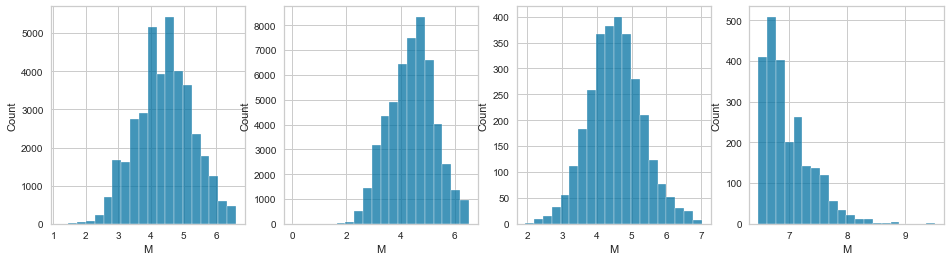

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    sns.histplot(ax=ax[i], data=np.log(1+data_stat14.loc[data_stat14['label']==i, 'M']), bins=20)

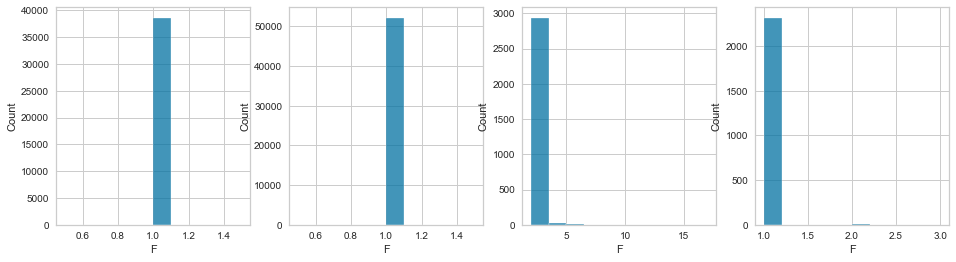

In [28]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    sns.histplot(ax=ax[i], data=data_stat14.loc[data_stat14['label']==i, 'F'], bins=10)
   

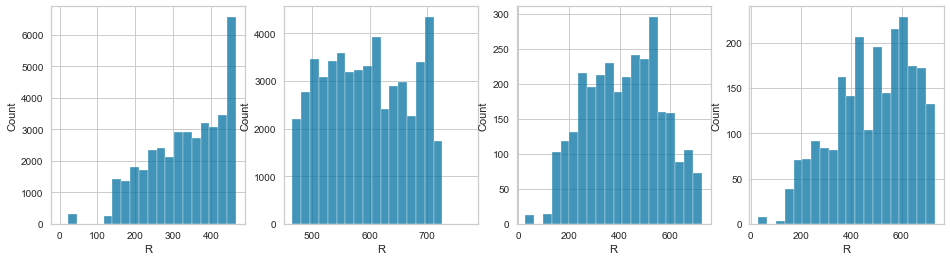

In [29]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    sns.histplot(ax=ax[i], data=data_stat14.loc[data_stat14['label']==i, 'R'], bins=20)

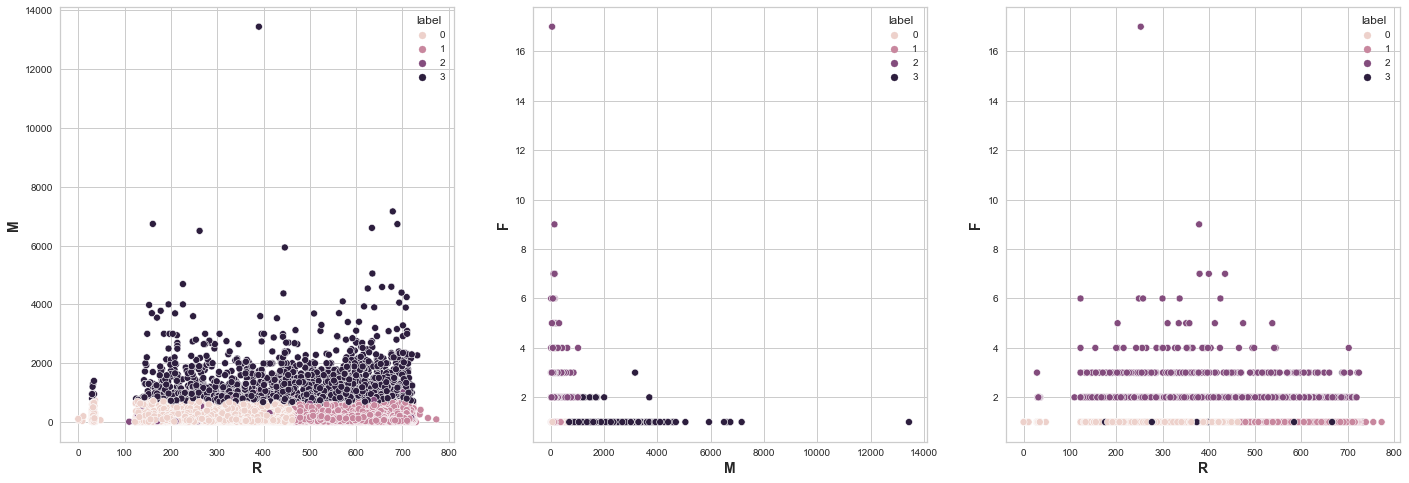

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(24, 8))
sns.scatterplot(ax=ax[0], data=data_stat14, x='R', y='M', hue='label', alpha=1)
sns.scatterplot(ax=ax[1], data=data_stat14, x='M', y='F', hue='label', alpha=1)
sns.scatterplot(ax=ax[2], data=data_stat14, x='R', y='F', hue='label', alpha=1)
ax[0].set_xlabel('R', fontsize=14, weight='bold')
ax[1].set_xlabel('M', fontsize=14, weight='bold')
ax[2].set_xlabel('R', fontsize=14, weight='bold')
ax[0].set_ylabel('M', fontsize=14, weight='bold')
ax[1].set_ylabel('F', fontsize=14, weight='bold')
ax[2].set_ylabel('F', fontsize=14, weight='bold')
fig.savefig('KMean_example.pdf');

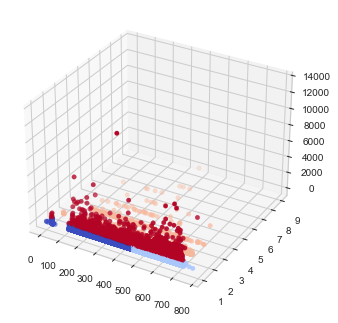

In [31]:
ax = plt.subplot(projection='3d')
data_stat_filtered = data_stat14.loc[data_stat14['F']<10]
ax.scatter3D(data_stat_filtered['R'], data_stat_filtered['F'], data_stat_filtered['M'], c=data_stat_filtered['label'], cmap='coolwarm');

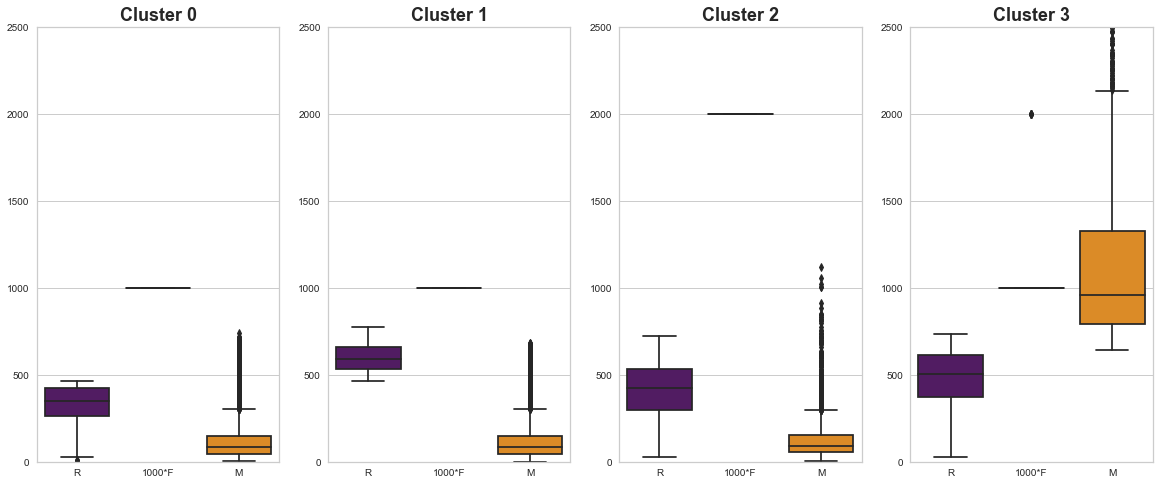

In [32]:
fig, ax = plt.subplots(1, 4, figsize=(20, 8))
for i in range(4):
    data_plot14 = data_stat14.loc[data_stat14['label']==i, ['R', 'F', 'M']]
    data_plot14['F'] = data_plot14['F'] * 1000
    sns.boxplot(ax= ax[i], data=data_plot14, palette='inferno')
    ax[i].set_title(f"Cluster {i}", fontsize=18, weight='bold')
    ax[i].set_xticklabels(['R', '1000*F', 'M'])
    ax[i].set_ylim(0, 2500)


## Clustering avec 3 clusters

In [33]:
# Nombre de clusters souhaités
n_clust = 3
km13 = KMeans(n_clusters= n_clust, random_state=0)
km13.fit(X_scaled1)

# Récupération des clusters attribués à chaque individu
clusters13 = km13.labels_
clusters13

array([1, 1, 2, ..., 2, 1, 2], dtype=int32)

In [34]:
#silhouette_score1 = silhouette_score(X_scaled, clusters, metric="euclidean").mean()

In [35]:
#silhouette_score1

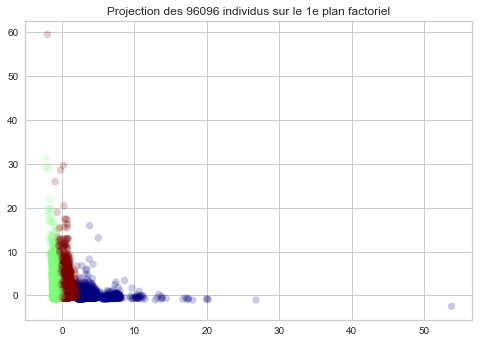

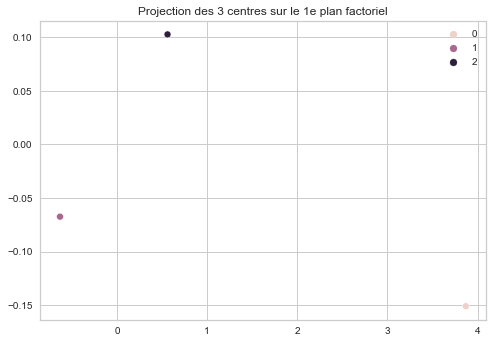

In [36]:
# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=3).fit(X_scaled1)
X_projected = pca.transform(X_scaled1)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters13.astype(np.float64), cmap = 'jet', alpha=.2)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show(block=False)

plt.figure()
centroids = km13.cluster_centers_
centroids_projected = pca.transform(centroids)
sns.scatterplot(x=centroids_projected[:,0],y=centroids_projected[:,1], hue=[0, 1, 2])
plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids)))
plt.show()

### Etude statistique de chaque cluster

In [37]:
data_stat13 = data.loc[:, ['R', 'F', 'M']]
data_stat13['label'] = clusters13

In [38]:
data_stat13['label'].value_counts()

1    53482
2    39617
0     2997
Name: label, dtype: int64

In [39]:
compare_stats(data_stat13, 'label')

0             1             2
count count  2997.000000  53482.000000  3.961700e+04
R     mean    417.122789    595.106279  3.346253e+02
      min      29.000000    464.000000  5.684342e-14
      max     724.000000    773.000000  4.810000e+02
F     mean      2.116116      1.000000  1.000000e+00
      min       2.000000      1.000000  1.000000e+00
      max      17.000000      1.000000  1.000000e+00
M     mean    133.441518    140.807449  1.462179e+02
      min       5.990000      0.000000  2.290000e+00
      max    3694.000000   7160.000000  1.344000e+04

<AxesSubplot:xlabel='label', ylabel='M'>

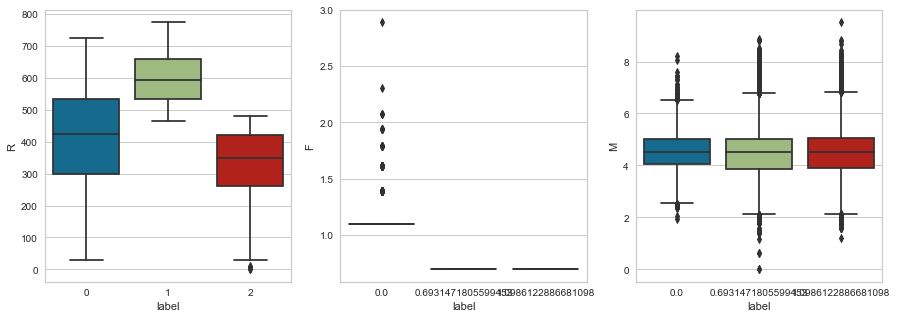

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(ax= ax[0], data=data_stat13, x='label', y='R')
sns.boxplot(ax= ax[1], data=np.log(1+data_stat13), x='label', y='F')
sns.boxplot(ax= ax[2], data=np.log(1+data_stat13), x='label', y='M')

In [41]:
# Profil 1 : un seul achat, achat récent (< 1752 jours)
# Profil 0 : un seul achat, achat ancien (> 1751 jours)
# Profil 3 : 2 achats et plus 
# la feature Montant n'est pas utilisée si 3 clusters _ Le clustering à 4 clusters est préféré

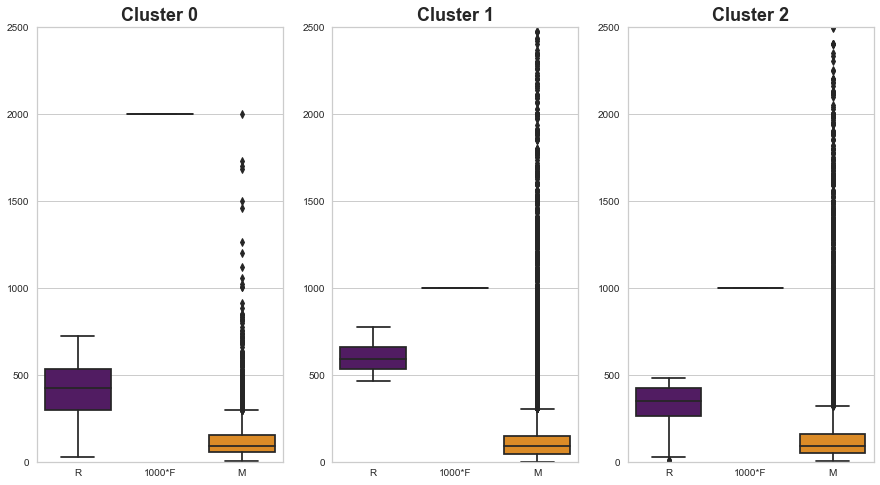

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(15, 8))
for i in range(3):
    data_plot13 = data_stat13.loc[data_stat13['label']==i, ['R', 'F', 'M']]
    data_plot13['F'] = data_plot13['F'] * 1000
    sns.boxplot(ax= ax[i], data=data_plot13, palette='inferno')
    ax[i].set_title(f"Cluster {i}", fontsize=18, weight='bold')
    ax[i].set_xticklabels(['R', '1000*F', 'M'])
    ax[i].set_ylim(0, 2500)

## Clustering hiérarchique

In [43]:
from sklearn.cluster import AgglomerativeClustering

In [44]:
X_sample144 = dataK.sample(n=10000, random_state=0)
scl144 = StandardScaler()
X_scaled_sample144 = scl144.fit_transform(X_sample144)
clust_agg144 = AgglomerativeClustering(linkage='ward', n_clusters=4, compute_distances=True)
clust_agg144.fit(X_scaled_sample144)

AgglomerativeClustering(compute_distances=True, n_clusters=4)

In [45]:
from scipy.cluster.hierarchy import dendrogram

In [46]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts] ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [47]:
#plot_dendrogram(clust_agg)

In [48]:
label144 = clust_agg144.fit_predict(X_scaled_sample144)

In [49]:
data_sample1444 = pd.DataFrame(X_sample144)
silhouette_samples(data_sample1444, labels=label144).mean()

0.22210160539644158

In [50]:
data_stats144 = scl144.inverse_transform(X_scaled_sample144)
data_stats144 = pd.DataFrame(columns=['R', 'F', 'M'], data=data_stats144)
data_stats144['label'] = label144

In [51]:
data_stats144['label'].value_counts()

0    6916
2    2661
1     311
3     112
Name: label, dtype: int64

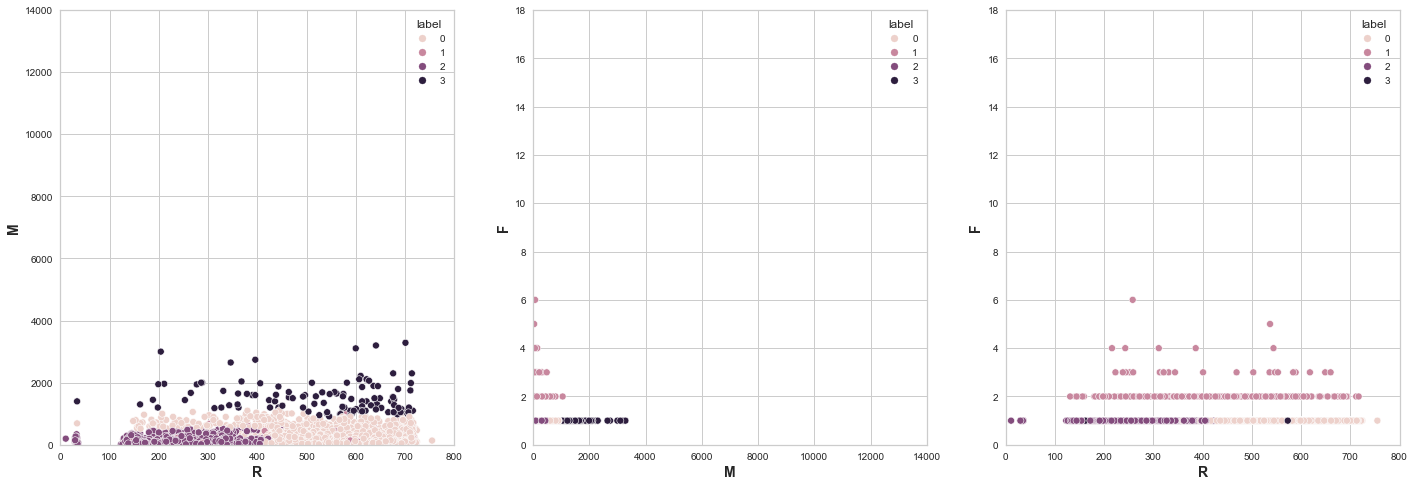

In [52]:
fig, ax = plt.subplots(1, 3, figsize=(24, 8))
sns.scatterplot(ax=ax[0], data=data_stats144, x='R', y='M', hue='label', alpha=1)
sns.scatterplot(ax=ax[1], data=data_stats144, x='M', y='F', hue='label', alpha=1)
sns.scatterplot(ax=ax[2], data=data_stats144, x='R', y='F', hue='label', alpha=1)
ax[0].set_xlabel('R', fontsize=14, weight='bold')
ax[0].set_xlim(0, 800)
ax[1].set_xlabel('M', fontsize=14, weight='bold')
ax[1].set_xlim(0, 14000)
ax[2].set_xlabel('R', fontsize=14, weight='bold')
ax[2].set_xlim(0, 800)
ax[0].set_ylabel('M', fontsize=14, weight='bold')
ax[0].set_ylim(0, 14000)
ax[1].set_ylabel('F', fontsize=14, weight='bold')
ax[1].set_ylim(0, 18)
ax[2].set_ylabel('F', fontsize=14, weight='bold')
ax[2].set_ylim(0, 18)
fig.savefig('hierarchique_example.pdf');

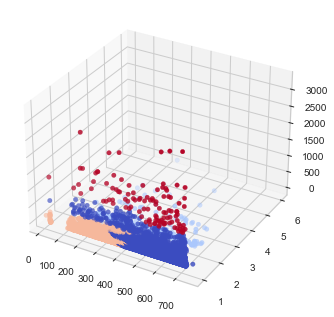

In [53]:
ax = plt.subplot(projection='3d')
#data_stat_filtered = data_stat14.loc[data_stat14['F']<10]
ax.scatter3D(data_stats144['R'], 
             data_stats144['F'], 
             data_stats144['M'], 
             c=data_stats144['label'], 
             cmap='coolwarm');

In [54]:
compare_stats(data_stats144, 'label')

0            1            2            3
count count  6916.000000   311.000000  2661.000000   112.000000
R     mean    561.373193   426.231511   287.502818   526.196429
      min      34.000000   131.000000    11.000000    34.000000
      max     755.000000   717.000000   449.000000   716.000000
F     mean      1.000000     2.122186     1.000000     1.000000
      min       1.000000     2.000000     1.000000     1.000000
      max       1.000000     6.000000     1.000000     1.000000
M     mean    135.379385   127.791857   108.965188  1525.755804
      min       2.200000    12.500000     4.500000   916.000000
      max    1109.000000  1054.000000   550.000000  3284.730000

<AxesSubplot:xlabel='label', ylabel='M'>

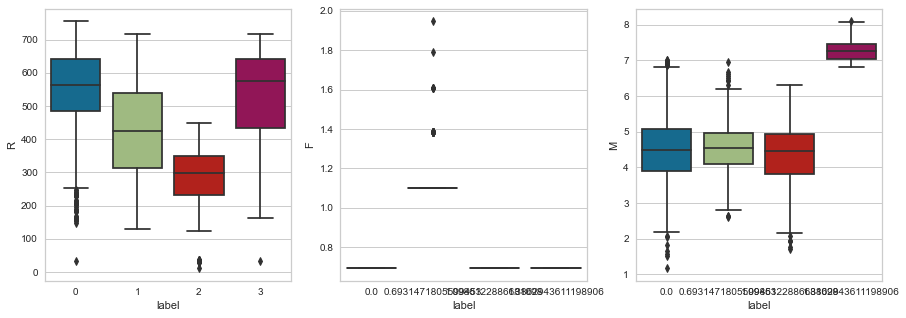

In [55]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(ax= ax[0], data=data_stats144, x='label', y='R')
sns.boxplot(ax= ax[1], data=np.log(1+data_stats144), x='label', y='F')
sns.boxplot(ax= ax[2], data=np.log(1+data_stats144), x='label', y='M')

In [56]:
# Résultats relativement comparable à Kmeans même si la partition semble moins ajustée car les clusters sont moins bien séparés

## DBSCAN

In [57]:
from sklearn.cluster import DBSCAN

In [58]:
model_dbscan = DBSCAN(eps=1.8, min_samples=20)
X_sample_dbscan = dataK.sample(n=50000)
scl_dbscan = StandardScaler()
X_scaled_sample_dbscan = scl_dbscan.fit_transform(X_sample_dbscan)
model_dbscan.fit(X_scaled_sample_dbscan)

DBSCAN(eps=1.8, min_samples=20)

In [59]:
labels_dbscan = model_dbscan.labels_

In [60]:
data_sample_dbscan = pd.DataFrame(X_scaled_sample_dbscan).sample(n=10000, replace=False)
index = data_sample_dbscan.index
silhouette_samples(data_sample_dbscan, labels_dbscan[index]).mean()

0.716770131231101

In [61]:
data_dbscan = scl_dbscan.inverse_transform(X_scaled_sample_dbscan)
data_dbscan = pd.DataFrame(columns=['R', 'F', 'M'], data=data_dbscan)
data_dbscan['label'] = labels_dbscan

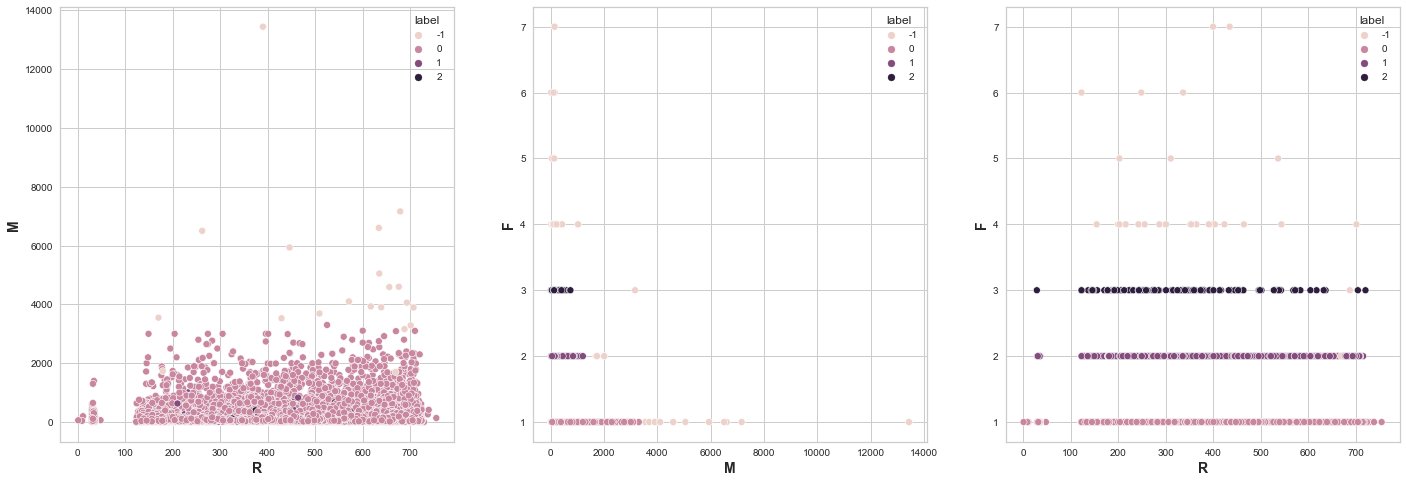

In [62]:
fig, ax = plt.subplots(1, 3, figsize=(24, 8))
sns.scatterplot(ax=ax[0], data=data_dbscan, x='R', y='M', hue='label', alpha=1)
sns.scatterplot(ax=ax[1], data=data_dbscan, x='M', y='F', hue='label', alpha=1)
sns.scatterplot(ax=ax[2], data=data_dbscan, x='R', y='F', hue='label', alpha=1)
ax[0].set_xlabel('R', fontsize=14, weight='bold')
ax[1].set_xlabel('M', fontsize=14, weight='bold')
ax[2].set_xlabel('R', fontsize=14, weight='bold')
ax[0].set_ylabel('M', fontsize=14, weight='bold')
ax[1].set_ylabel('F', fontsize=14, weight='bold')
ax[2].set_ylabel('F', fontsize=14, weight='bold')
fig.savefig('DBSCAN_example.pdf');

In [63]:
data_dbscan['label'].value_counts()

 0    48426
 1     1424
 2      102
-1       48
Name: label, dtype: int64

/opt/anaconda3/envs/baseClone/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/opt/anaconda3/envs/baseClone/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


<AxesSubplot:xlabel='label', ylabel='M'>

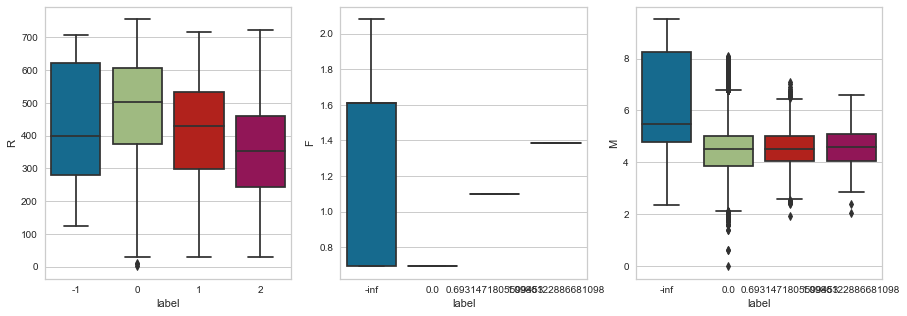

In [64]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(ax= ax[0], data=data_dbscan, x='label', y='R')
sns.boxplot(ax= ax[1], data=np.log(1+data_dbscan), x='label', y='F')
sns.boxplot(ax= ax[2], data=np.log(1+data_dbscan), x='label', y='M')

In [65]:
compare_stats(data_dbscan, 'label')

-1             0            1           2
count count     48.000000  48426.000000  1424.000000  102.000000
R     mean     424.812500    483.621360   418.422753  359.764706
      min      123.000000      1.000000    30.000000   29.000000
      max      707.000000    755.000000   716.000000  721.000000
F     mean       3.104167      1.000000     2.000000    3.000000
      min        1.000000      1.000000     2.000000    3.000000
      max        7.000000      1.000000     2.000000    3.000000
M     mean    2101.345165    142.262538   127.846959  131.468627
      min        9.733333      0.000000     5.990000    6.900000
      max    13440.000000   3300.000000  1200.000000  733.333333

In [66]:
# La séparation des clusters n'est effectuée que sur le nombre d'achats et donc n'apporte rien

# Ajout feature review

In [67]:
dataK2 = data.loc[:, ['R', 'F', 'M', 'review_score_mean']]

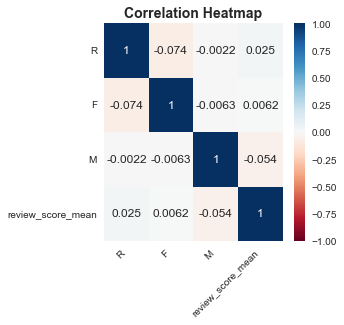

In [282]:
plt.figure(figsize=(4, 4))
sns.heatmap(dataK2.corr(),annot=True,cmap='RdBu', vmin=-1, vmax=1)
plt.title('Correlation Heatmap',fontsize=14, weight='bold')
plt.yticks(rotation =0)
plt.xticks(rotation =45, ha='right', va='top')
plt.show()

In [69]:
X_scaled2 = preprocessing.StandardScaler().fit_transform(dataK2)

### Distortion score

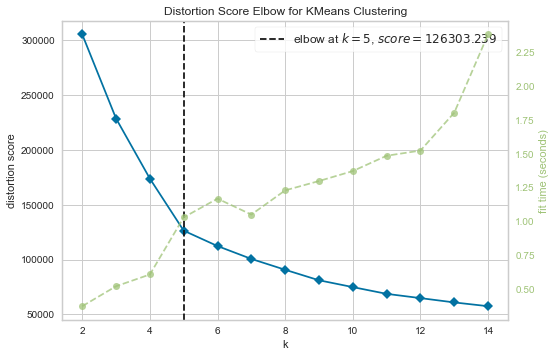

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [70]:
model2 = KMeans()
visualizer2 = KElbowVisualizer(model2, k=(2,15))
visualizer2.fit(X_scaled2)    
visualizer2.poof()  

### Silhouette

In [71]:
# Echantillon
dataK_sample2 = dataK2.sample(10000)
X_scaled_sample2 = StandardScaler().fit_transform(dataK_sample2)

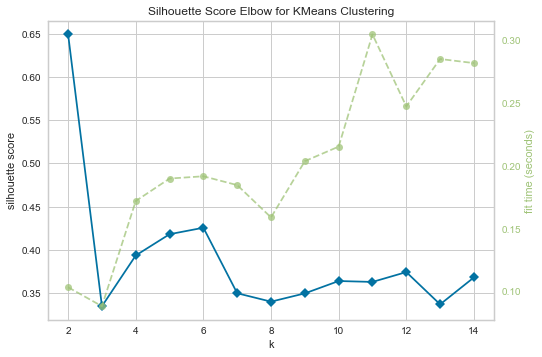

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [72]:
model2 = KMeans()
visualizer2 = KElbowVisualizer(model2, k=(2,15), metric='silhouette', locate_elbow=False)
visualizer2.fit(X_scaled_sample2)    
visualizer2.poof()  

### Stability

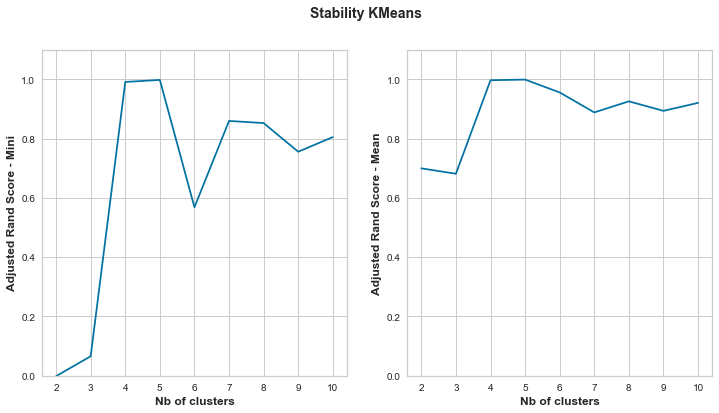

In [292]:
stability_KMeans(X_scaled2, 2, 10)

### Silhouette score

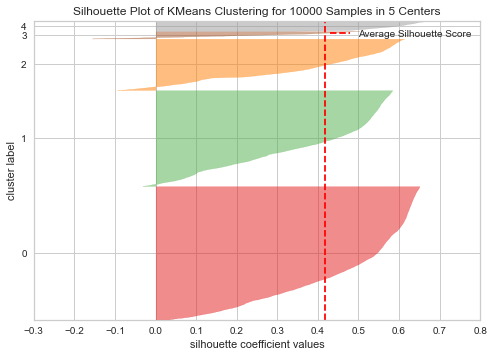

In [74]:
model2 = KMeans(n_clusters=5)
visualizer2 = SilhouetteVisualizer(model2)
visualizer2.fit(X_scaled_sample2) 
visualizer2.poof();   

## Clustering avec 5 clusters

In [75]:
X_scaled25 = StandardScaler().fit_transform(dataK2)
# Nombre de clusters souhaités
n_clust = 5
km25 = KMeans(n_clusters= n_clust, random_state=0)
km25.fit(X_scaled25)

# Récupération des clusters attribués à chaque individu
clusters25 = km25.labels_

In [76]:
data_sample25 = pd.DataFrame(X_scaled25).sample(n=10000, replace=False)
index = data_sample25.index
silhouette_samples(data_sample25, clusters25[index]).mean()

0.42045230735121525

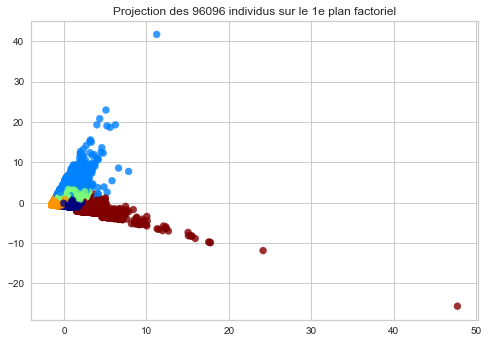

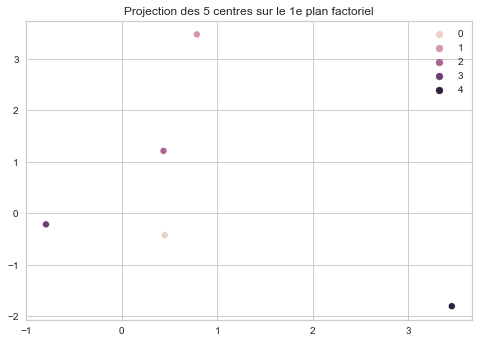

In [77]:
# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=3).fit(X_scaled25)
X_projected = pca.transform(X_scaled25)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters25.astype(np.float64), cmap = 'jet', alpha=.8)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show(block=False)

plt.figure()
centroids = km25.cluster_centers_
centroids_projected = pca.transform(centroids)
sns.scatterplot(x=centroids_projected[:,0],y=centroids_projected[:,1], hue=[0, 1, 2, 3, 4])
plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids)))
plt.show()

### Etude statistique de chaque cluster

In [78]:
data_stat25 = dataK2.copy()
data_stat25['label'] = clusters25
data_stat25['label'].value_counts()

3    42235
0    31749
2    17078
4     2987
1     2047
Name: label, dtype: int64

In [79]:
compare_stats(data_stat25, 'label')

0             1             2  \
count             count  31749.000000   2047.000000  1.707800e+04   
R                 mean     330.112067    486.612604  4.804954e+02   
                  min       29.000000     30.000000  5.684342e-14   
                  max      468.000000    732.000000  7.730000e+02   
F                 mean       1.000000      1.005374  1.000000e+00   
                  min        1.000000      1.000000  1.000000e+00   
                  max        1.000000      3.000000  1.000000e+00   
M                 mean     116.398962   1245.710741  1.341237e+02   
                  min        2.290000    668.000000  0.000000e+00   
                  max      799.000000  13440.000000  7.884200e+02   
review_score_mean mean       4.627528      3.890386  1.605839e+00   
                  min        2.000000      1.000000  1.000000e+00   
                  max        5.000000      5.000000  3.285606e+00   

                                    3            4  
count             count  42235.000000  2987.000000  
R                 mean     601.532118   417.143288  
                  min      465.000000    29.000000  
                  max      729.000000   724.000000  
F                 mean       1.000000     2.116170  
                  min        1.000000     2.000000  
                  max        1.000000    17.000000  
M                 mean     113.808035   127.397337  
                  min        0.000000     5.990000  
                  max      712.900000  1119.210000  
review_score_mean mean       4.667763     4.109078  
                  min        2.660179     1.000000  
                  max        5.000000     5.000000

<AxesSubplot:xlabel='label', ylabel='review_score_mean'>

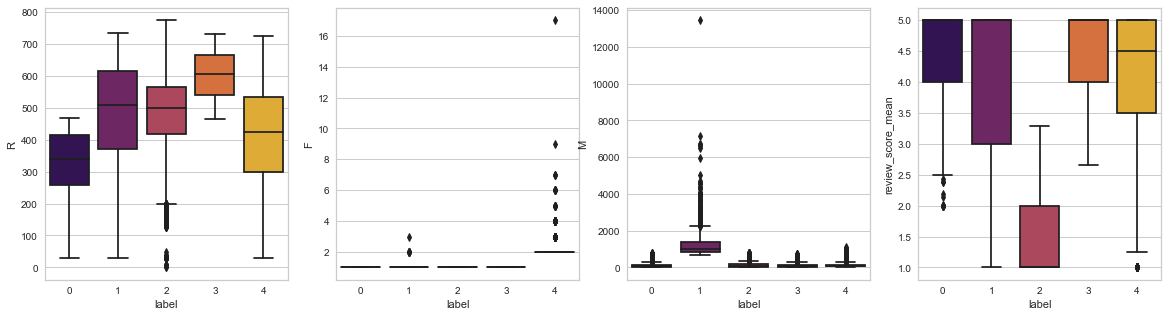

In [80]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.boxplot(ax= ax[0], data=data_stat25, x='label', y='R', palette='inferno')
sns.boxplot(ax= ax[1], data=data_stat25, x='label', y='F', palette='inferno')
sns.boxplot(ax= ax[2], data=data_stat25, x='label', y='M', palette='inferno')
sns.boxplot(ax= ax[3], data=data_stat25, x='label', y='review_score_mean', palette='inferno')

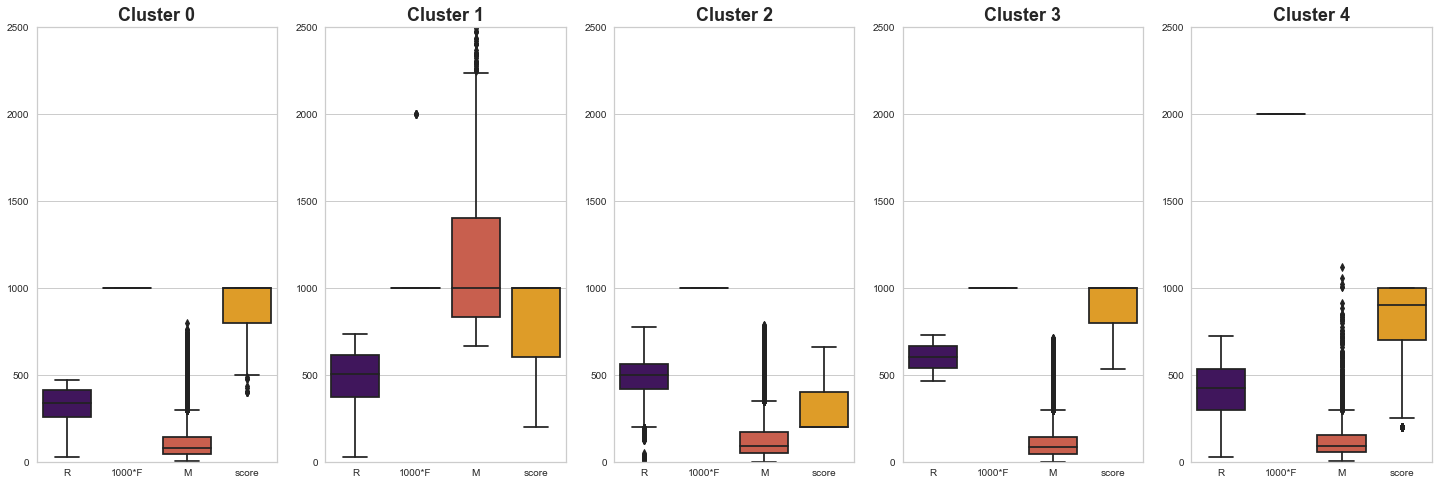

In [81]:
fig, ax = plt.subplots(1, 5, figsize=(25, 8))
for i in range(5):
    data_plot25 = data_stat25.loc[data_stat25['label']==i, ['R', 'F', 'M', 'review_score_mean']]
    data_plot25['F'] = data_plot25['F'] * 1000
    data_plot25['review_score_mean'] = data_plot25['review_score_mean'] * 200
    sns.boxplot(ax= ax[i], data=data_plot25, palette='inferno')
    ax[i].set_title(f"Cluster {i}", fontsize=18, weight='bold')
    ax[i].set_xticklabels(['R', '1000*F', 'M', 'score'])
    ax[i].set_ylim(0, 2500)
fig.savefig('boxplot_review.pdf')

In [82]:
# Profil 4 : plusieurs achats
# Profil 3 : 1 achat - montant inférieur à 800 euros - score > 2.5 - achat ancien 
# Profil 0 : 1 achat - montant inférieur à 800 euros - score > 3 - achat récent 
# Profil 2 : 1 achat - montant inférieur à 800 euros - score < 3
# Profil 1 : montant supérieur à 700 euros

In [83]:
cmap = plt.get_cmap('inferno')
colors25 = np.linspace(0.1, 0.9, 5)

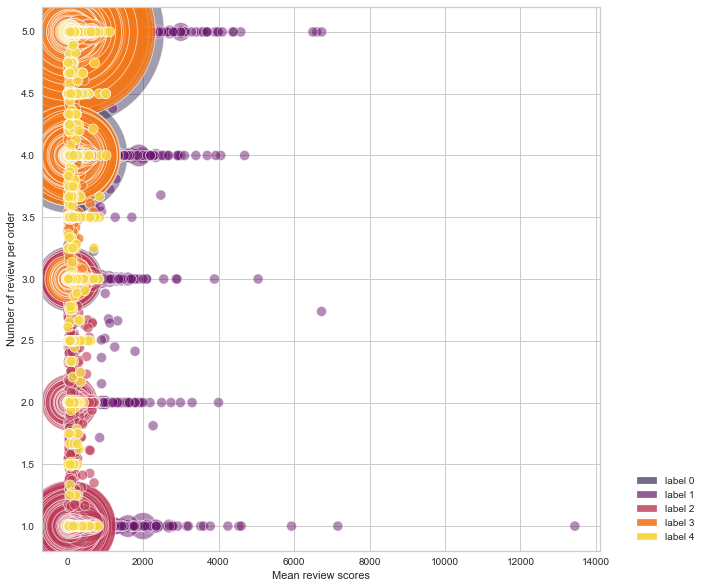

In [84]:
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerPatch
fig, ax = plt.subplots(figsize=(10, 10))
for l in range(5):
    sizes = {} 
    for (yt, yp) in zip((
        data_stat25.loc[data_stat25['label']==l,'M'].to_list()), 
        (data_stat25.loc[data_stat25['label']==l, 'review_score_mean'].to_list())):
        if (yt, yp) in sizes:
            sizes[(yt, yp)] += 1
        else:
            sizes[(yt, yp)] = 1
    keys = sizes.keys()
    sns.scatterplot(ax=ax, data=keys,
        x=[k[0] for k in keys],
        y=[k[1] for k in keys],
        s=[100*sizes[k]**0.9 for k in keys], color=[cmap(colors25[l])], alpha=(0.4+0.1*l))
#ax.set_ylim(0.8, 2.2)
#ax.set_xlim(0, 6)
ax.set(xlabel='Mean review scores', ylabel='Number of review per order')
legend_elements = [Patch(facecolor=cmap(colors25[0]),label='label 0'), 
                   Patch(facecolor=cmap(colors25[1]),label='label 1'), 
                   Patch(facecolor=cmap(colors25[2]),label='label 2'), 
                   Patch(facecolor=cmap(colors25[3]),label='label 3'), 
                   Patch(facecolor=cmap(colors25[4]),label='label 4')]    
leg = plt.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(1.05, 0))
for i, lh in enumerate(leg.legendHandles): 
    lh.set_alpha(0.6+0.1*i)

# Ajout feature Voucher

In [85]:
dataK3= data.loc[:, ['R', 'F', 'M', 'voucher']]

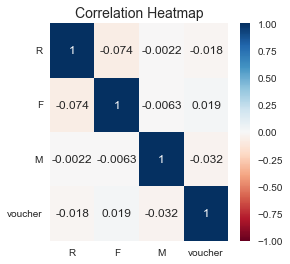

In [283]:
plt.figure(figsize=(4, 4))
sns.heatmap(dataK3.corr(),annot=True,cmap='RdBu', vmin=-1, vmax=1)
plt.title('Correlation Heatmap',fontsize=14)
plt.yticks(rotation =0)
plt.show()

In [87]:
X_scaled3 = preprocessing.StandardScaler().fit_transform(dataK3)

### Distortion score

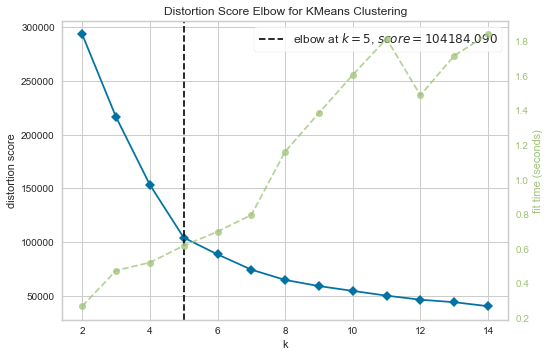

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [88]:
model3 = KMeans()
visualizer3 = KElbowVisualizer(model3, k=(2,15))
visualizer3.fit(X_scaled3)    # Fit the data to the visualizer
visualizer3.poof()  

### Silhouette

In [89]:
# Echantillon
dataK_sample3 = dataK3.sample(10000)
X_scaled_sample3 = StandardScaler().fit_transform(dataK_sample3)

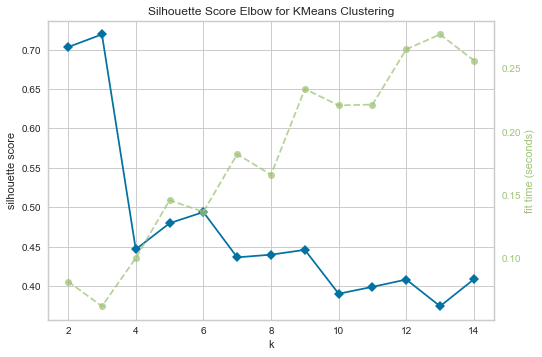

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [90]:
visualizer3 = KElbowVisualizer(model3, k=(2,15), metric='silhouette', locate_elbow=False)
visualizer3.fit(X_scaled_sample3)    
visualizer3.poof()  

### Stability

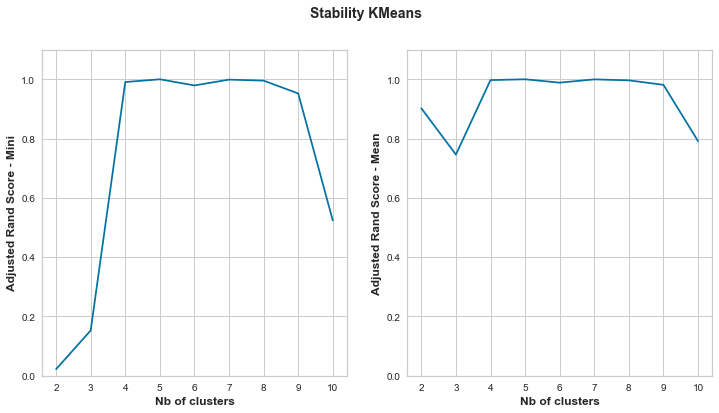

In [293]:
stability_KMeans(X_scaled3, 2, 10)

### Silhouette score

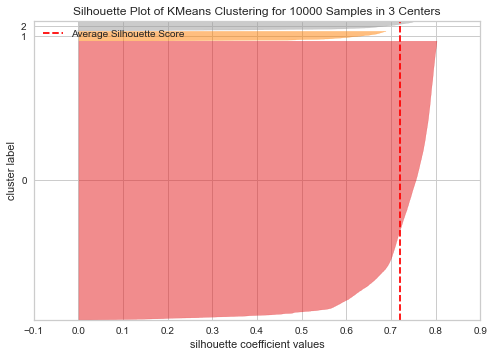

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 10000 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [92]:
model3 = KMeans(n_clusters=3)
visualizer3 = SilhouetteVisualizer(model3)
visualizer3.fit(X_scaled_sample3) 
visualizer3.poof()    

## Clustering avec 3 clusters

In [93]:
X_scaled33 = StandardScaler().fit_transform(dataK3)
# Nombre de clusters souhaités
n_clust = 3
km33 = KMeans(n_clusters= n_clust, random_state=0)
km33.fit(X_scaled33)

# Récupération des clusters attribués à chaque individu
clusters33 = km33.labels_

In [94]:
data_sample33 = pd.DataFrame(X_scaled33).sample(n=10000, replace=False)
index = data_sample33.index
silhouette_samples(data_sample33, clusters33[index]).mean()

0.7232589374383582

### Etude statistique de chaque cluster

In [95]:
data_stat33 = dataK3.copy()
data_stat33['label'] = clusters33
data_stat33['label'].value_counts()

1    90149
2     3010
0     2937
Name: label, dtype: int64

In [96]:
compare_stats(data_stat33, 'label')

0             1            2
count   count  2937.000000  9.014900e+04  3010.000000
R       mean    417.109976  4.847870e+02   467.218605
        min      29.000000  5.684342e-14    30.000000
        max     724.000000  7.290000e+02   773.000000
F       mean      2.118488  1.000000e+00     1.019934
        min       2.000000  1.000000e+00     1.000000
        max      17.000000  1.000000e+00     2.000000
M       mean    134.475913  1.444375e+02   102.142706
        min       6.900000  0.000000e+00     2.200000
        max    3694.000000  1.344000e+04  2266.610000
voucher mean      2.975479  1.523350e-01    88.964013
        min       0.000000  0.000000e+00    44.429371
        max     100.000000  4.569421e+01   100.000000

<AxesSubplot:xlabel='label', ylabel='voucher'>

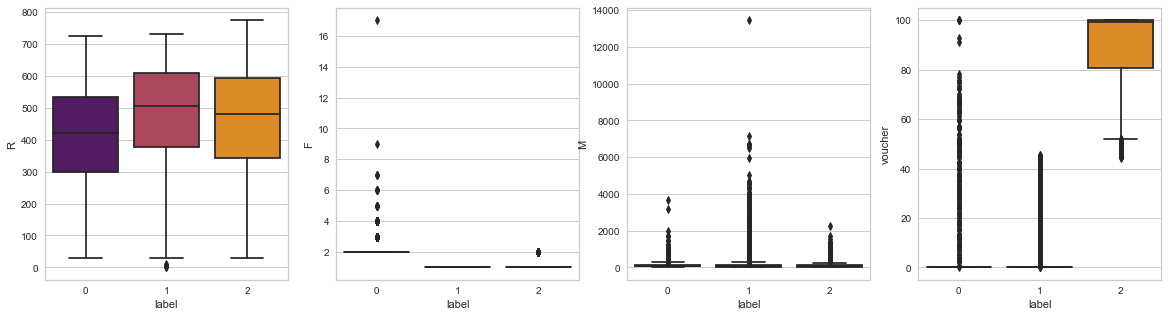

In [97]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.boxplot(ax= ax[0], data=data_stat33, x='label', y='R', palette='inferno')
sns.boxplot(ax= ax[1], data=data_stat33, x='label', y='F', palette='inferno')
sns.boxplot(ax= ax[2], data=data_stat33, x='label', y='M', palette='inferno')
sns.boxplot(ax= ax[3], data=data_stat33, x='label', y='voucher', palette='inferno')

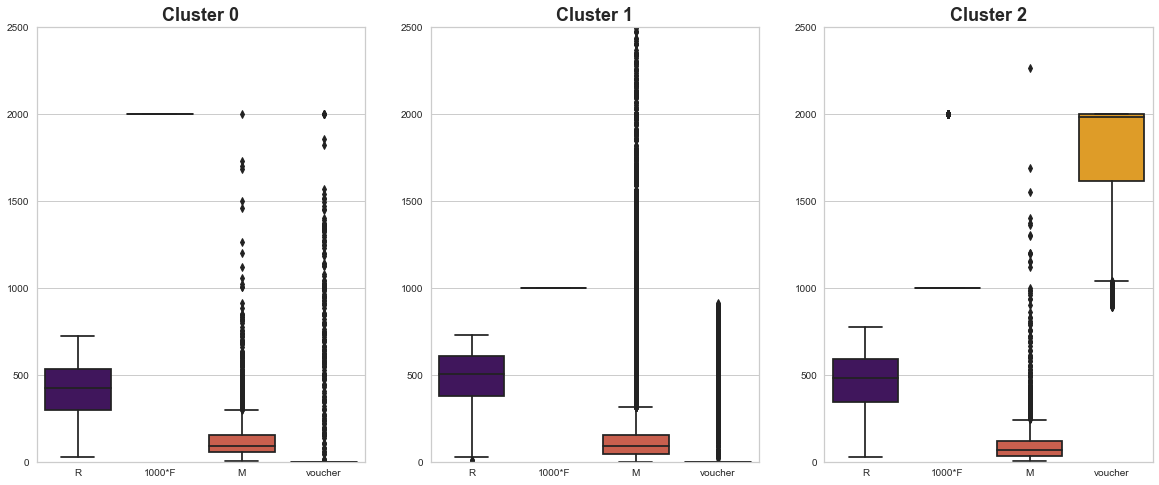

In [98]:
fig, ax = plt.subplots(1, 3, figsize=(20, 8))
for i in range(3):
    data_plot33 = data_stat33.loc[data_stat33['label']==i, ['R', 'F', 'M', 'voucher']]
    data_plot33['F'] = data_plot33['F'] * 1000
    data_plot33['voucher'] = data_plot33['voucher'] * 20
    sns.boxplot(ax= ax[i], data=data_plot33, palette='inferno')
    ax[i].set_title(f"Cluster {i}", fontsize=18, weight='bold')
    ax[i].set_xticklabels(['R', '1000*F', 'M', 'voucher'])
    ax[i].set_ylim(0, 2500)

In [99]:
# Le silhouette score est certe très bon mais R et M ne participe en rien au clustering et donc 
# cette partition est peu utile du point de vue métier (un groupe utilisateur de voucher, un groupe plus d'une commande et un autre une unique commande peu de voucher)

## Clustering avec 5 clusters

In [100]:
X_scaled35 = StandardScaler().fit_transform(dataK3)
# Nombre de clusters souhaités
n_clust = 5
km35 = KMeans(n_clusters= n_clust, random_state=0)
km35.fit(X_scaled35)

# Récupération des clusters attribués à chaque individu
clusters35 = km35.labels_

In [101]:
data_sample35 = pd.DataFrame(X_scaled35).sample(n=10000, replace=False)
index = data_sample35.index
silhouette_samples(data_sample35, clusters35[index]).mean()

0.48699477035422667

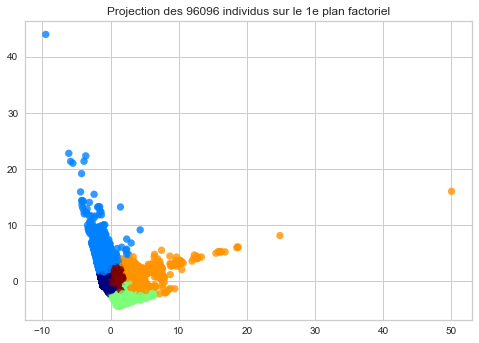

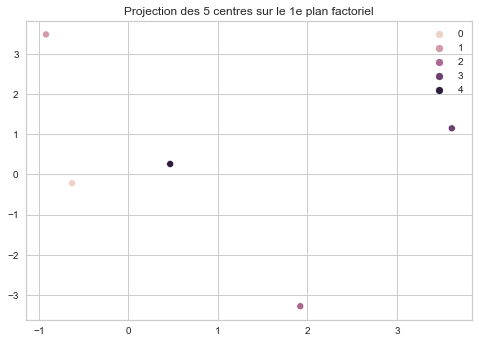

In [102]:
# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=3).fit(X_scaled35)
X_projected = pca.transform(X_scaled35)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters35.astype(np.float64), cmap = 'jet', alpha=.8)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show(block=False)

plt.figure()
centroids = km35.cluster_centers_
centroids_projected = pca.transform(centroids)
sns.scatterplot(x=centroids_projected[:,0],y=centroids_projected[:,1], hue=[0, 1, 2, 3, 4])
plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids)))
plt.show()

### Etude statistique de chaque cluster

In [103]:
data_stat35 = dataK3.copy()
data_stat35['label'] = clusters35
data_stat35['label'].value_counts()

0    50458
4    37441
2     2983
3     2927
1     2287
Name: label, dtype: int64

In [104]:
compare_stats(data_stat35, 'label')

0             1            2            3  \
count   count  50458.000000   2287.000000  2983.000000  2927.000000   
R       mean     595.590253    484.719283   467.736842   417.130851   
        min      466.000000     30.000000    30.000000    29.000000   
        max      729.000000    732.000000   773.000000   724.000000   
F       mean       1.000000      1.004810     1.020114     2.118551   
        min        1.000000      1.000000     1.000000     2.000000   
        max        1.000000      3.000000     2.000000    17.000000   
M       mean     116.960122   1185.269190    98.263602   128.311366   
        min        0.000000    639.920000     2.200000     6.900000   
        max      682.980000  13440.000000  1375.000000  1119.210000   
voucher mean       0.146771      0.492836    89.264086     2.962869   
        min        0.000000      0.000000    44.790827     0.000000   
        max       46.691227    100.000000   100.000000   100.000000   

                          4  
count   count  3.744100e+04  
R       mean   3.353915e+02  
        min    5.684342e-14  
        max    4.660000e+02  
F       mean   1.000000e+00  
        min    1.000000e+00  
        max    1.000000e+00  
M       mean   1.186488e+02  
        min    2.290000e+00  
        max    7.399800e+02  
voucher mean   1.809129e-01  
        min    0.000000e+00  
        max    4.797178e+01

<AxesSubplot:xlabel='label', ylabel='voucher'>

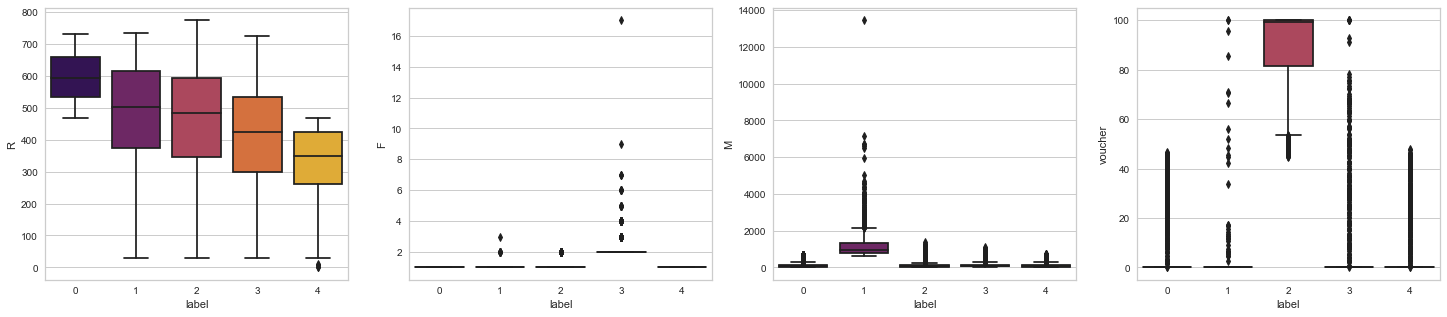

In [105]:
fig, ax = plt.subplots(1, 4, figsize=(25, 5))
sns.boxplot(ax= ax[0], data=data_stat35, x='label', y='R', palette='inferno')
sns.boxplot(ax= ax[1], data=data_stat35, x='label', y='F', palette='inferno')
sns.boxplot(ax= ax[2], data=data_stat35, x='label', y='M', palette='inferno')
sns.boxplot(ax= ax[3], data=data_stat35, x='label', y='voucher', palette='inferno')

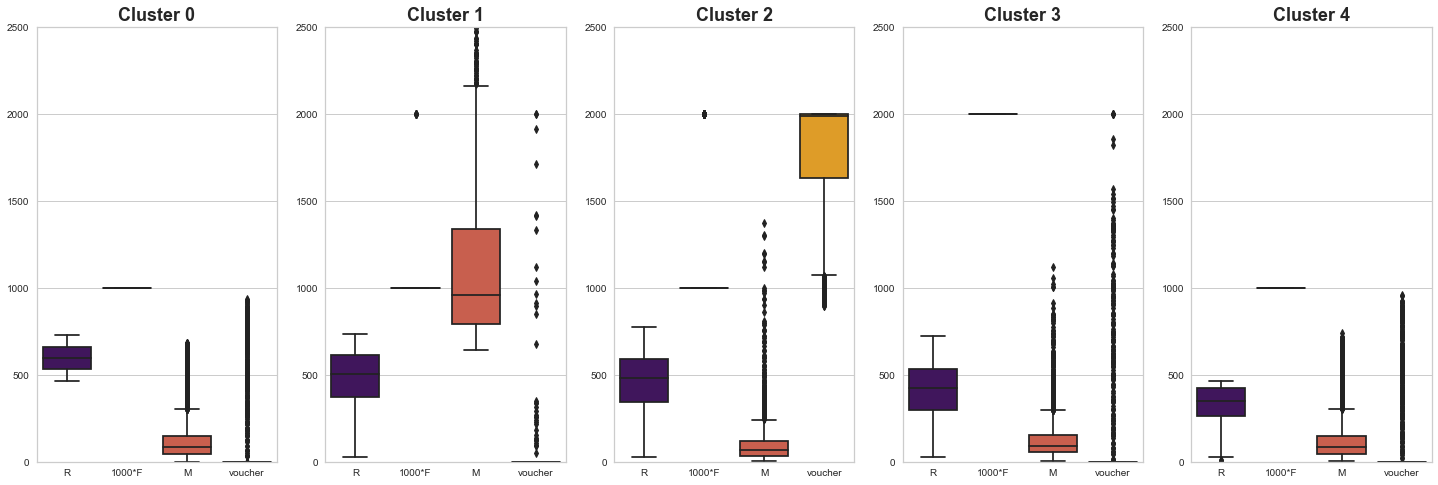

In [106]:
fig, ax = plt.subplots(1, 5, figsize=(25, 8))
for i in range(5):
    data_plot35 = data_stat35.loc[data_stat35['label']==i, ['R', 'F', 'M', 'voucher']]
    data_plot35['F'] = data_plot35['F'] * 1000
    #data_plot50['review_score_mean_mean'] = data_plot50['review_score_mean_mean'] * 200
    data_plot35['voucher'] = data_plot35['voucher'] * 20
    sns.boxplot(ax= ax[i], data=data_plot35, palette='inferno')
    ax[i].set_title(f"Cluster {i}", fontsize=18, weight='bold')
    ax[i].set_xticklabels(['R', '1000*F', 'M', 'voucher'])
    ax[i].set_ylim(0, 2500)    
fig.savefig('boxplot_voucher.pdf')

In [107]:
compare_stats(data_stat35, 'label')

0             1            2            3  \
count   count  50458.000000   2287.000000  2983.000000  2927.000000   
R       mean     595.590253    484.719283   467.736842   417.130851   
        min      466.000000     30.000000    30.000000    29.000000   
        max      729.000000    732.000000   773.000000   724.000000   
F       mean       1.000000      1.004810     1.020114     2.118551   
        min        1.000000      1.000000     1.000000     2.000000   
        max        1.000000      3.000000     2.000000    17.000000   
M       mean     116.960122   1185.269190    98.263602   128.311366   
        min        0.000000    639.920000     2.200000     6.900000   
        max      682.980000  13440.000000  1375.000000  1119.210000   
voucher mean       0.146771      0.492836    89.264086     2.962869   
        min        0.000000      0.000000    44.790827     0.000000   
        max       46.691227    100.000000   100.000000   100.000000   

                          4  
count   count  3.744100e+04  
R       mean   3.353915e+02  
        min    5.684342e-14  
        max    4.660000e+02  
F       mean   1.000000e+00  
        min    1.000000e+00  
        max    1.000000e+00  
M       mean   1.186488e+02  
        min    2.290000e+00  
        max    7.399800e+02  
voucher mean   1.809129e-01  
        min    0.000000e+00  
        max    4.797178e+01

In [108]:
# Cluster 3 : 2 commandes 
# Cluster 2 : 1 commande - Voucher > 44%
# Cluster 4 : 1 commande - Voucher < 47% - achat récent (<1755 days)
# Cluster 0 : 1 commande - Voucher < 47%- achat ancient (>1755 days)
# Cluster 1 : 1 commande - Montant > 670 

# Avec features review + Voucher

In [109]:
dataK4 = data.loc[:, ['R', 'F', 'M', 'voucher', 'review_score_mean']]

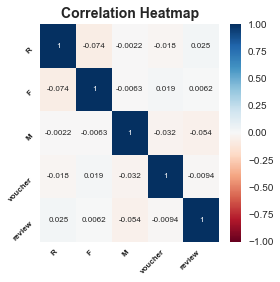

In [284]:
fig = plt.figure(figsize=(4, 4))
data_heat = dataK4.rename(columns={'review_score_mean':'review'})
sns.heatmap(data_heat.corr(),annot=True,cmap='RdBu', annot_kws={'size':8}, vmin=-1, vmax=1)
plt.title('Correlation Heatmap',fontsize=14, weight='bold')
plt.yticks(rotation =45, va='top', fontsize=8, weight='bold')
plt.xticks(rotation =45, ha='right', va='top', fontsize=8, weight='bold')
fig.savefig('heatmap.pdf');

In [111]:
X_scaled4 = preprocessing.StandardScaler().fit_transform(dataK4)

### Distortion score

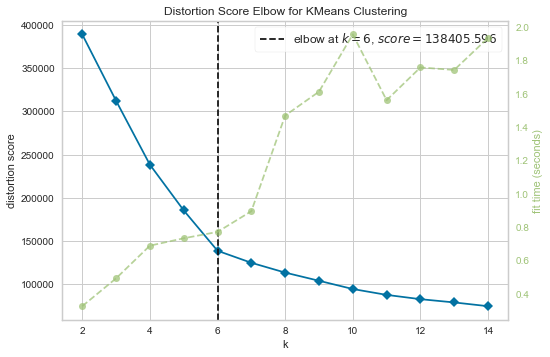

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [112]:
model4 = KMeans()
visualizer4 = KElbowVisualizer(model4, k=(2,15))
visualizer4.fit(X_scaled4)    
visualizer4.poof()  

### Silhouette

In [113]:
# Echantillon
dataK_sample4 = dataK4.sample(10000)
X_scaled_sample4 = StandardScaler().fit_transform(dataK_sample4)

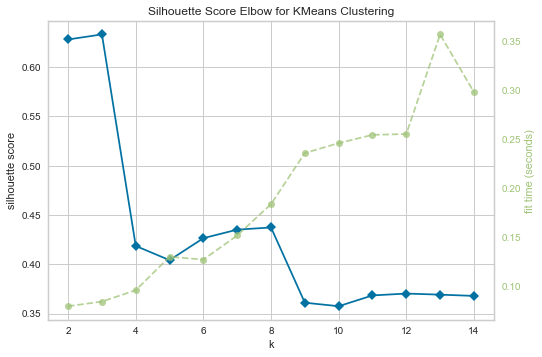

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [114]:
visualizer4 = KElbowVisualizer(model4, k=(2,15), metric='silhouette', locate_elbow=False)
visualizer4.fit(X_scaled_sample4)    
visualizer4.poof()  

### Stability

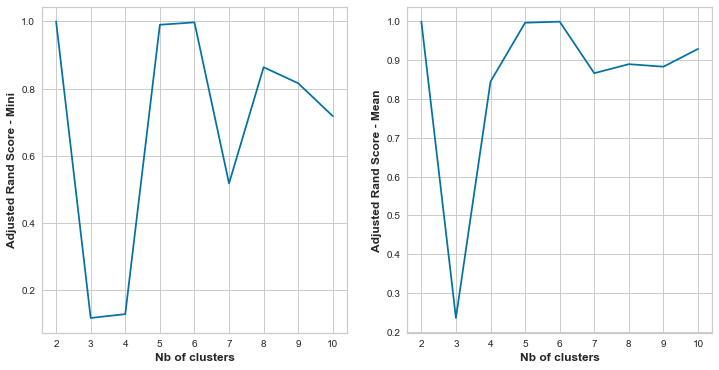

In [115]:
stability_KMeans(X_scaled4, 2, 10)

### Silhouette score

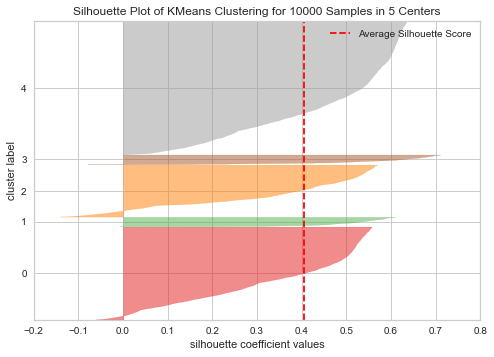

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 10000 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [116]:
model4 = KMeans(n_clusters=5)
visualizer4 = SilhouetteVisualizer(model4)
visualizer4.fit(X_scaled_sample4) 
visualizer4.poof()    

## Clustering avec 5 clusters

In [117]:
X_scaled45 = StandardScaler().fit_transform(dataK4)
# Nombre de clusters souhaités
n_clust = 5
km45 = KMeans(n_clusters= n_clust, random_state=0)
km45.fit(X_scaled45)

# Récupération des clusters attribués à chaque individu
clusters45 = km45.labels_

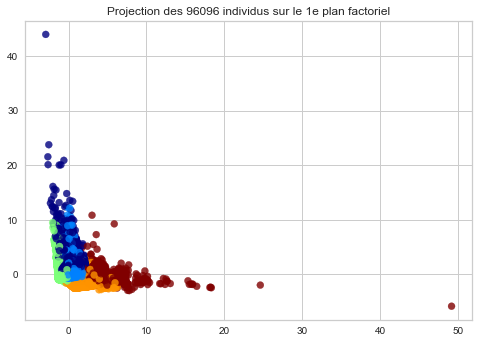

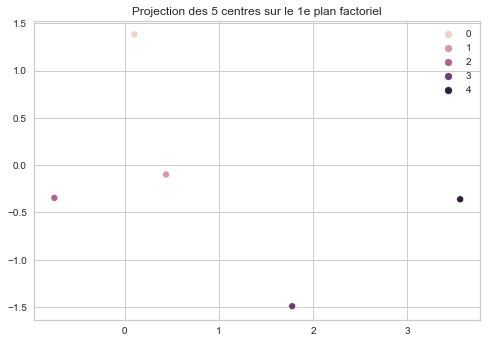

In [118]:
# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=4).fit(X_scaled45)
X_projected = pca.transform(X_scaled45)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters45.astype(np.float64), cmap = 'jet', alpha=.8)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show(block=False)

plt.figure()
centroids = km45.cluster_centers_
centroids_projected = pca.transform(centroids)
sns.scatterplot(x=centroids_projected[:,0],y=centroids_projected[:,1], hue=[0, 1, 2, 3, 4])
plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids)))
plt.show()

### Etude statistique de chaque cluster

In [119]:
data_stat45 = dataK4.copy()
data_stat45['label'] = clusters45
data_stat45['label'].value_counts()

2    41943
1    31413
0    16824
3     2978
4     2938
Name: label, dtype: int64

In [120]:
compare_stats(data_stat45, 'label')

0             1             2  \
count             count  1.682400e+04  31413.000000  41943.000000   
R                 mean   4.807655e+02    330.728711    601.733877   
                  min    5.684342e-14     29.000000    465.000000   
                  max    7.240000e+02    490.000000    729.000000   
F                 mean   1.000000e+00      1.000000      1.000000   
                  min    1.000000e+00      1.000000      1.000000   
                  max    1.000000e+00      1.000000      1.000000   
M                 mean   1.857716e+02    139.114659    131.840802   
                  min    0.000000e+00      2.290000      0.000000   
                  max    1.344000e+04   3999.900000   3284.730000   
voucher           mean   2.019060e-01      0.180251      0.145783   
                  min    0.000000e+00      0.000000      0.000000   
                  max    5.083075e+01     47.971776     47.801147   
review_score_mean mean   1.592044e+00      4.625787      4.662383   
                  min    1.000000e+00      2.000000      2.660179   
                  max    5.000000e+00      5.000000      5.000000   

                                   3            4  
count             count  2978.000000  2938.000000  
R                 mean    467.753862   417.074541  
                  min      30.000000    29.000000  
                  max     773.000000   724.000000  
F                 mean      1.019812     2.118448  
                  min       1.000000     2.000000  
                  max       2.000000    17.000000  
M                 mean    101.769565   134.446768  
                  min       2.200000     6.900000  
                  max    2266.610000  3694.000000  
voucher           mean     89.410178     3.000801  
                  min      44.916647     0.000000  
                  max     100.000000   100.000000  
review_score_mean mean      4.032574     4.107068  
                  min       1.000000     1.000000  
                  max       5.000000     5.000000

<AxesSubplot:xlabel='label', ylabel='review_score_mean'>

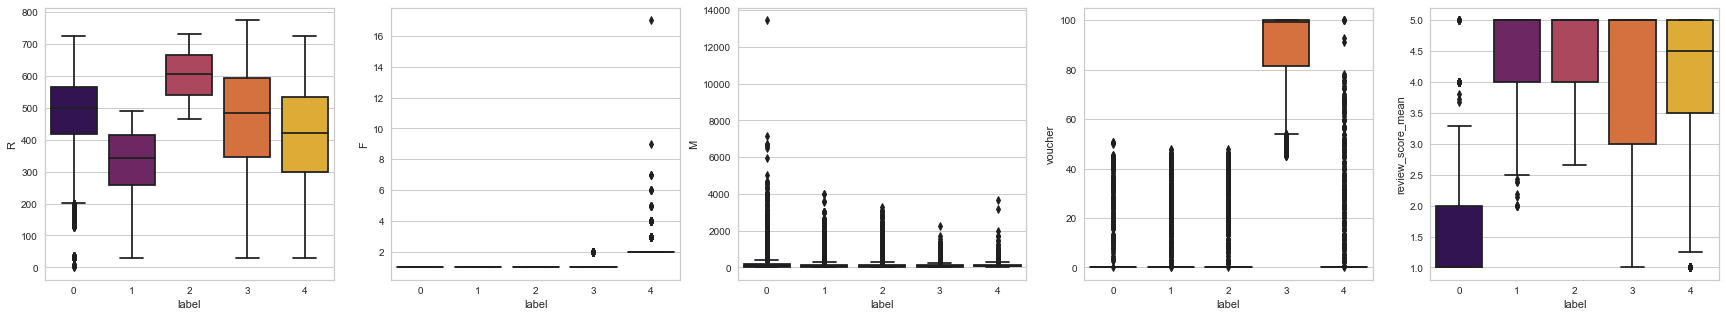

In [121]:
fig, ax = plt.subplots(1, 5, figsize=(30, 5))
sns.boxplot(ax= ax[0], data=data_stat45, x='label', y='R', palette='inferno')
sns.boxplot(ax= ax[1], data=data_stat45, x='label', y='F', palette='inferno')
sns.boxplot(ax= ax[2], data=data_stat45, x='label', y='M', palette='inferno')
sns.boxplot(ax= ax[3], data=data_stat45, x='label', y='voucher', palette='inferno')
sns.boxplot(ax= ax[4], data=data_stat45, x='label', y='review_score_mean', palette='inferno')

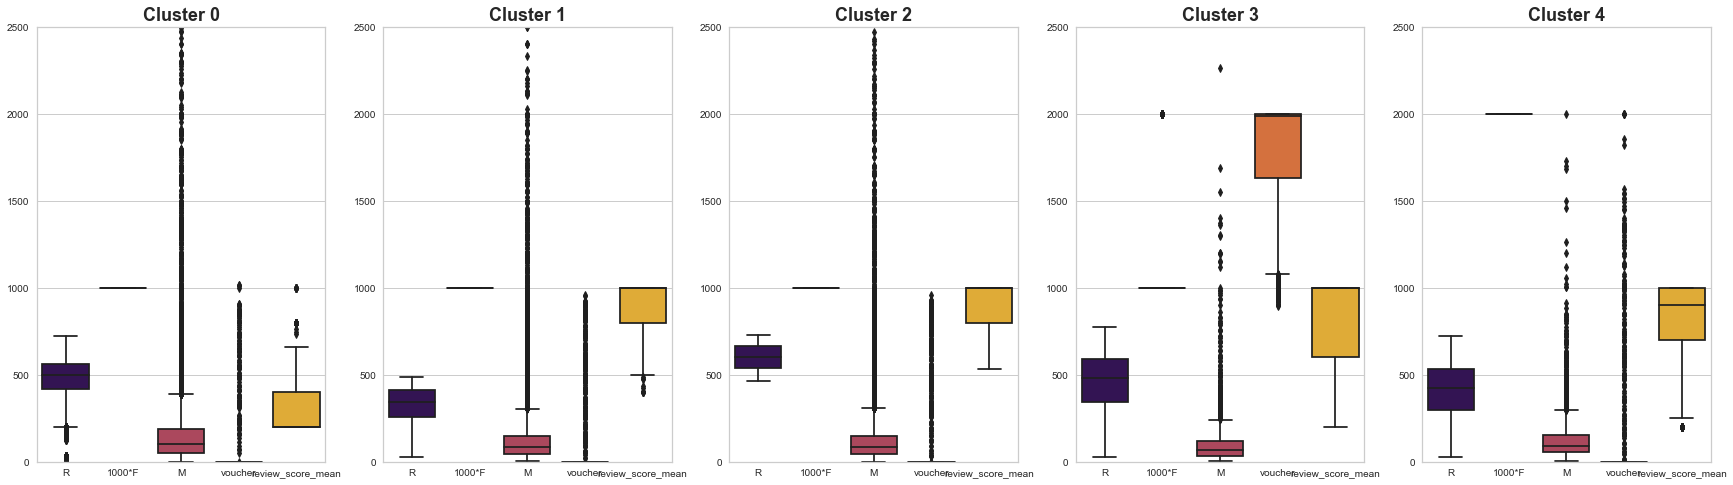

In [122]:
fig, ax = plt.subplots(1, 5, figsize=(30, 8))
for i in range(5):
    data_plot45 = data_stat45.loc[data_stat45['label']==i, ['R', 'F', 'M', 'voucher', 'review_score_mean']]
    data_plot45['F'] = data_plot45['F'] * 1000
    data_plot45['review_score_mean'] = data_plot45['review_score_mean'] * 200
    data_plot45['voucher'] = data_plot45['voucher'] * 20
    sns.boxplot(ax= ax[i], data=data_plot45, palette='inferno')
    ax[i].set_title(f"Cluster {i}", fontsize=18, weight='bold')
    ax[i].set_xticklabels(['R', '1000*F', 'M', 'voucher', 'review_score_mean'])
    ax[i].set_ylim(0, 2500)

In [123]:
# En mettant ces 2 features simultanément, avec 5 clusters, il n'y a plus aucune distinction liée au montant

## Clustering avec 6 clusters

In [124]:
X_scaled46 = StandardScaler().fit_transform(dataK4)
# Nombre de clusters souhaités
n_clust = 6
km46 = KMeans(n_clusters= n_clust, random_state=0)
km46.fit(X_scaled46)

# Récupération des clusters attribués à chaque individu
clusters46 = km46.labels_

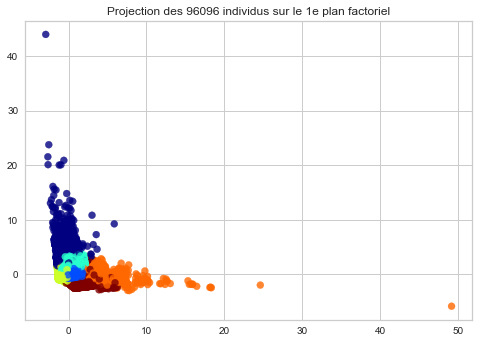

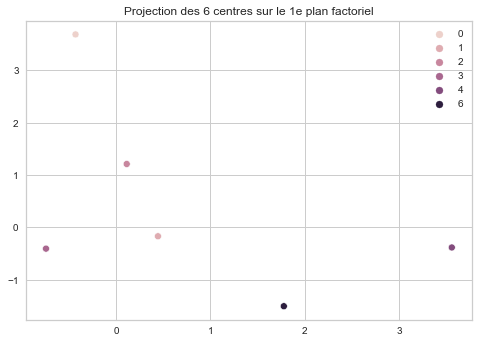

In [125]:
# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=4).fit(X_scaled46)
X_projected = pca.transform(X_scaled46)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters46.astype(np.float64), cmap = 'jet', alpha=.8)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show(block=False)

plt.figure()
centroids = km46.cluster_centers_
centroids_projected = pca.transform(centroids)
sns.scatterplot(x=centroids_projected[:,0],y=centroids_projected[:,1], hue=[0, 1, 2, 3, 4, 6])
plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids)))
plt.show()

### Etude statistique de chaque cluster

In [126]:
data_stat46 = dataK4.copy()
data_stat46['label'] = clusters46
data_stat46['label'].value_counts()

3    40946
1    30755
2    16513
5     2970
4     2928
0     1984
Name: label, dtype: int64

In [127]:
compare_stats(data_stat46, 'label')

0             1             2  \
count             count   1984.000000  30755.000000  1.651300e+04   
R                 mean     486.360383    330.716794  4.808685e+02   
                  min       30.000000     29.000000  5.684342e-14   
                  max      732.000000    470.000000  7.240000e+02   
F                 mean       1.005544      1.000000  1.000000e+00   
                  min        1.000000      1.000000  1.000000e+00   
                  max        3.000000      1.000000  1.000000e+00   
M                 mean    1259.388910    117.706791  1.354193e+02   
                  min      679.000000      2.290000  0.000000e+00   
                  max    13440.000000    799.000000  7.980000e+02   
voucher           mean       0.543060      0.179621  1.942271e-01   
                  min        0.000000      0.000000  0.000000e+00   
                  max      100.000000     47.971776  5.083075e+01   
review_score_mean mean       3.890109      4.627577  1.605067e+00   
                  min        1.000000      2.000000  1.000000e+00   
                  max        5.000000      5.000000  3.285606e+00   

                                    3            4            5  
count             count  40946.000000  2928.000000  2970.000000  
R                 mean     601.951057   417.095287   467.670370  
                  min      466.000000    29.000000    30.000000  
                  max      729.000000   724.000000   773.000000  
F                 mean       1.000000     2.118511     1.019865  
                  min        1.000000     2.000000     1.000000  
                  max        1.000000    17.000000     2.000000  
M                 mean     114.822274   128.284228    98.079345  
                  min        0.000000     6.900000     2.200000  
                  max      735.000000  1119.210000  1375.000000  
voucher           mean       0.148113     2.988281    89.437796  
                  min        0.000000     0.000000    44.916647  
                  max       47.801147   100.000000   100.000000  
review_score_mean mean       4.668807     4.109824     4.033062  
                  min        2.660179     1.000000     1.000000  
                  max        5.000000     5.000000     5.000000

<AxesSubplot:xlabel='label', ylabel='review_score_mean'>

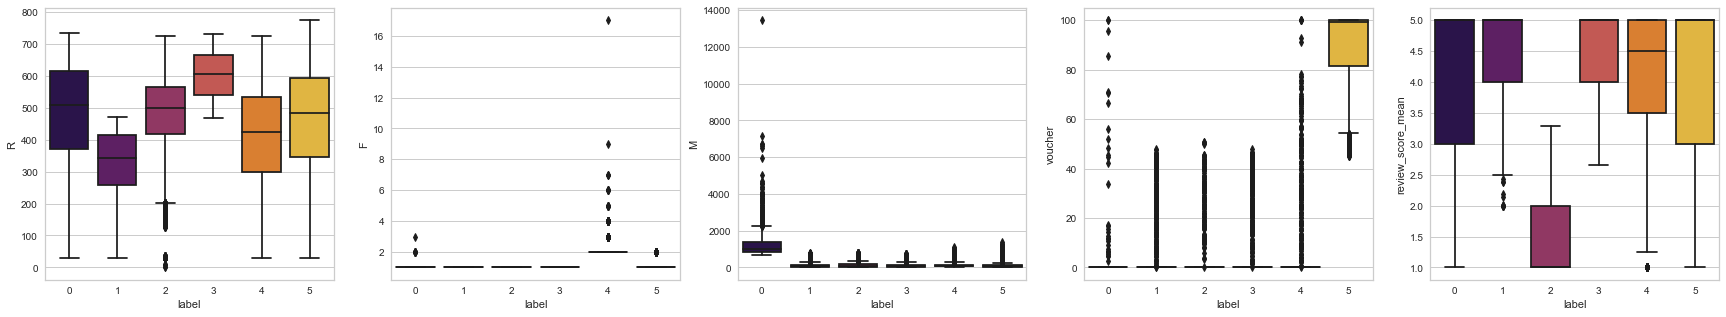

In [128]:
fig, ax = plt.subplots(1, 5, figsize=(30, 5))
sns.boxplot(ax= ax[0], data=data_stat46, x='label', y='R', palette='inferno')
sns.boxplot(ax= ax[1], data=data_stat46, x='label', y='F', palette='inferno')
sns.boxplot(ax= ax[2], data=data_stat46, x='label', y='M', palette='inferno')
sns.boxplot(ax= ax[3], data=data_stat46, x='label', y='voucher', palette='inferno')
sns.boxplot(ax= ax[4], data=data_stat46, x='label', y='review_score_mean', palette='inferno')

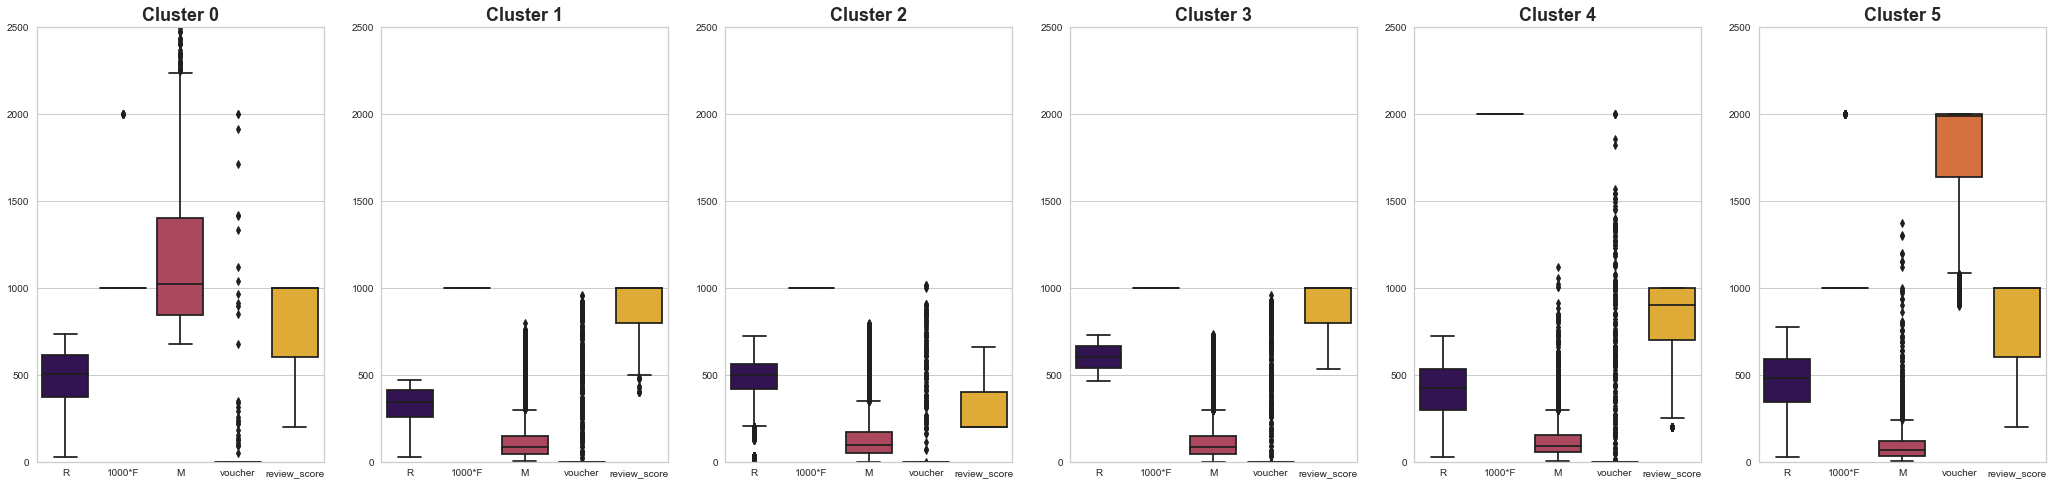

In [129]:
fig, ax = plt.subplots(1, 6, figsize=(36, 8))
for i in range(6):
    data_plot46 = data_stat46.loc[data_stat46['label']==i, ['R', 'F', 'M', 'voucher', 'review_score_mean']]
    data_plot46['F'] = data_plot46['F'] * 1000
    data_plot46['review_score_mean'] = data_plot46['review_score_mean'] * 200
    data_plot46['voucher'] = data_plot46['voucher'] * 20
    sns.boxplot(ax= ax[i], data=data_plot46, palette='inferno')
    ax[i].set_title(f"Cluster {i}", fontsize=18, weight='bold')
    ax[i].set_xticklabels(['R', '1000*F', 'M', 'voucher', 'review_score'])
    ax[i].set_ylim(0, 2500)

In [130]:
compare_stats(data_stat46, 'label')

0             1             2  \
count             count   1984.000000  30755.000000  1.651300e+04   
R                 mean     486.360383    330.716794  4.808685e+02   
                  min       30.000000     29.000000  5.684342e-14   
                  max      732.000000    470.000000  7.240000e+02   
F                 mean       1.005544      1.000000  1.000000e+00   
                  min        1.000000      1.000000  1.000000e+00   
                  max        3.000000      1.000000  1.000000e+00   
M                 mean    1259.388910    117.706791  1.354193e+02   
                  min      679.000000      2.290000  0.000000e+00   
                  max    13440.000000    799.000000  7.980000e+02   
voucher           mean       0.543060      0.179621  1.942271e-01   
                  min        0.000000      0.000000  0.000000e+00   
                  max      100.000000     47.971776  5.083075e+01   
review_score_mean mean       3.890109      4.627577  1.605067e+00   
                  min        1.000000      2.000000  1.000000e+00   
                  max        5.000000      5.000000  3.285606e+00   

                                    3            4            5  
count             count  40946.000000  2928.000000  2970.000000  
R                 mean     601.951057   417.095287   467.670370  
                  min      466.000000    29.000000    30.000000  
                  max      729.000000   724.000000   773.000000  
F                 mean       1.000000     2.118511     1.019865  
                  min        1.000000     2.000000     1.000000  
                  max        1.000000    17.000000     2.000000  
M                 mean     114.822274   128.284228    98.079345  
                  min        0.000000     6.900000     2.200000  
                  max      735.000000  1119.210000  1375.000000  
voucher           mean       0.148113     2.988281    89.437796  
                  min        0.000000     0.000000    44.916647  
                  max       47.801147   100.000000   100.000000  
review_score_mean mean       4.668807     4.109824     4.033062  
                  min        2.660179     1.000000     1.000000  
                  max        5.000000     5.000000     5.000000

In [131]:
# Profil 4 : plusieurs commandes 
# Profil 5 : voucher > 45%
# Profil 0 : montant > 705
# Profil 1: 1 commande - score > 3 - achat récent (< 470)
# Profil 3 : 1 commande - score > 3 - achat ancien (> 466)
# Profil 2 : 1 commande - score < 3 

# Ajout feature week

In [132]:
dataK5 = data.loc[:, ['R', 'F', 'M', 'week']]

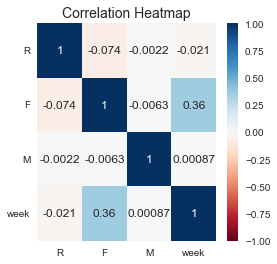

In [285]:
plt.figure(figsize=(4, 4))
sns.heatmap(dataK5.corr(),annot=True,cmap='RdBu', vmin=-1, vmax=1)
plt.title('Correlation Heatmap',fontsize=14)
plt.yticks(rotation =0)
plt.show()

In [134]:
X_scaled5 = preprocessing.StandardScaler().fit_transform(dataK5)

### Distortion score

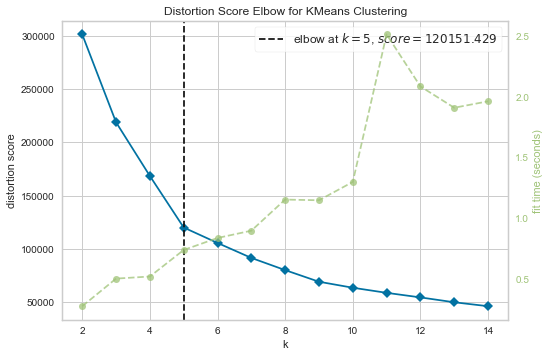

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [135]:
model5 = KMeans()
visualizer5 = KElbowVisualizer(model5, k=(2,15))
visualizer5.fit(X_scaled5)    
visualizer5.poof()  

### Silhouette

In [136]:
# Echantillon
dataK_sample5 = dataK5.sample(10000)
X_scaled_sample5 = StandardScaler().fit_transform(dataK_sample5)

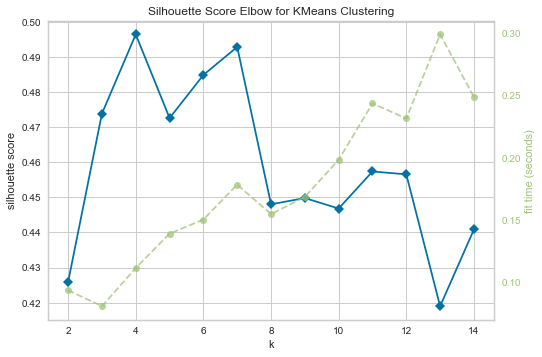

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [137]:
visualizer5 = KElbowVisualizer(model5, k=(2,15), metric='silhouette', locate_elbow=False)
visualizer5.fit(X_scaled_sample5)    
visualizer5.poof()  

### Stability

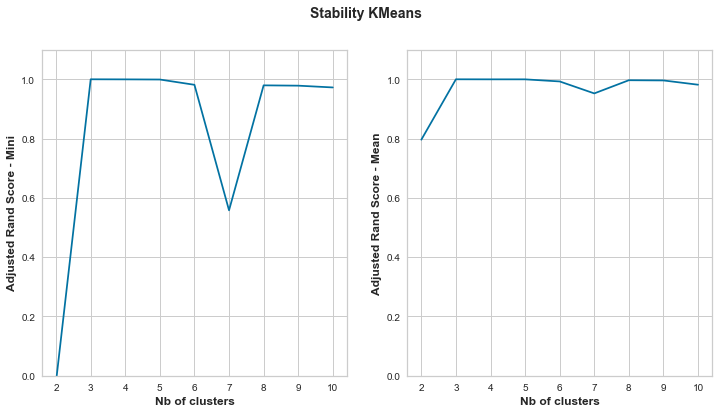

In [294]:
stability_KMeans(X_scaled5, 2, 10)

### Silhouette score

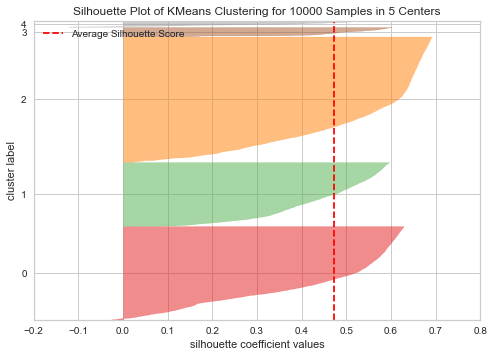

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 10000 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [139]:
model5 = KMeans(n_clusters=5)
visualizer5 = SilhouetteVisualizer(model5)
visualizer5.fit(X_scaled_sample5) 
visualizer5.poof()    

## Clustering avec 5 clusters

In [140]:
X_scaled55 = StandardScaler().fit_transform(dataK5)
# Nombre de clusters souhaités
n_clust = 5
km55 = KMeans(n_clusters= n_clust, random_state=0)
km55.fit(X_scaled55)

# Récupération des clusters attribués à chaque individu
clusters55 = km55.labels_

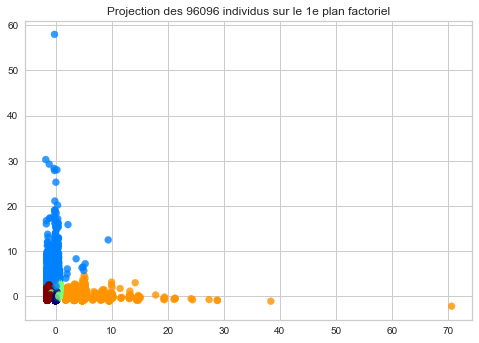

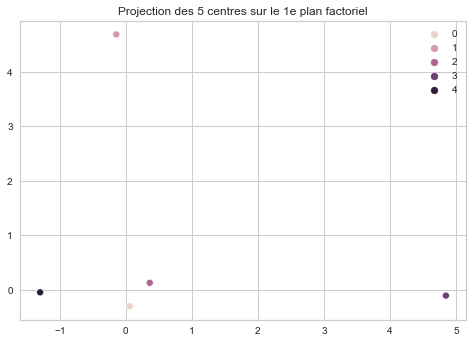

In [141]:
# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=3).fit(X_scaled55)
X_projected = pca.transform(X_scaled55)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters55.astype(np.float64), cmap = 'jet', alpha=.8)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show(block=False)

plt.figure()
centroids = km55.cluster_centers_
centroids_projected = pca.transform(centroids)
sns.scatterplot(x=centroids_projected[:,0],y=centroids_projected[:,1], hue=[0, 1, 2, 3, 4])
plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids)))
plt.show()

### Etude statistique de chaque cluster

In [142]:
data_stat55 = dataK5.copy()
data_stat55['label'] = clusters55
data_stat55['label'].value_counts()

0    40875
2    29221
4    20874
3     2987
1     2139
Name: label, dtype: int64

In [143]:
compare_stats(data_stat55, 'label')

0             1             2            3  \
count count  40875.000000   2139.000000  2.922100e+04  2987.000000   
R     mean     593.499817    486.584853  3.312364e+02   417.055239   
      min      463.000000     30.000000  5.684342e-14    29.000000   
      max      773.000000    732.000000  4.640000e+02   724.000000   
F     mean       1.000000      1.005143  1.000000e+00     2.116170   
      min        1.000000      1.000000  1.000000e+00     2.000000   
      max        1.000000      3.000000  1.000000e+00    17.000000   
M     mean     116.597262   1223.168255  1.194637e+02   127.424384   
      min        0.000000    659.000000  2.290000e+00     5.990000   
      max      704.500000  13440.000000  7.559900e+02  1200.000000   
week  mean       1.000000      0.798504  9.978440e-01     1.624707   
      min        1.000000      0.000000  0.000000e+00     0.000000   
      max        1.000000      3.000000  1.000000e+00    13.000000   

                        4  
count count  20874.000000  
R     mean     484.311967  
      min      125.000000  
      max      755.000000  
F     mean       1.000000  
      min        1.000000  
      max        1.000000  
M     mean     118.308262  
      min        2.200000  
      max      735.000000  
week  mean       0.000000  
      min        0.000000  
      max        0.000000

<AxesSubplot:xlabel='label', ylabel='week'>

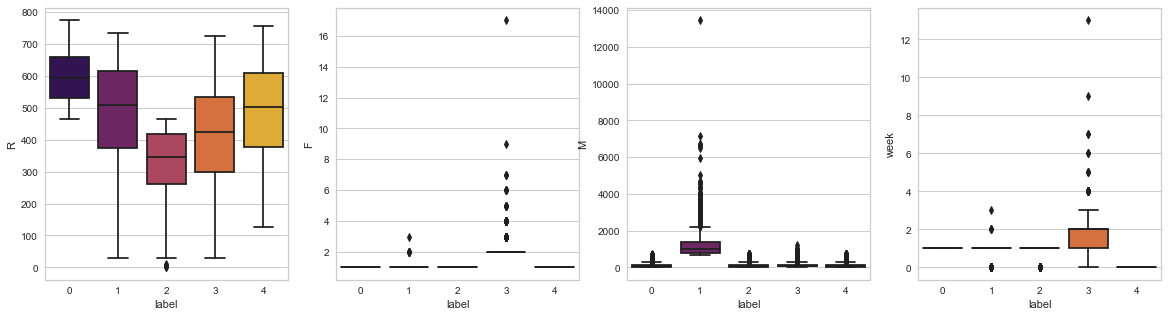

In [144]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.boxplot(ax= ax[0], data=data_stat55, x='label', y='R', palette='inferno')
sns.boxplot(ax= ax[1], data=data_stat55, x='label', y='F', palette='inferno')
sns.boxplot(ax= ax[2], data=data_stat55, x='label', y='M', palette='inferno')
sns.boxplot(ax= ax[3], data=data_stat55, x='label', y='week', palette='inferno')

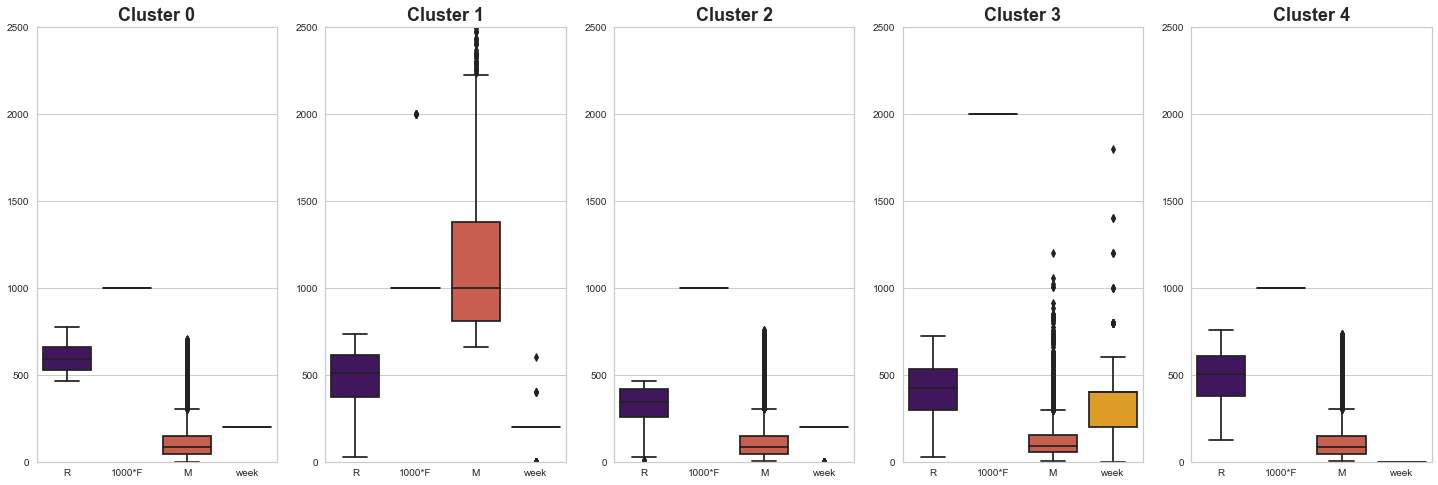

In [145]:
fig, ax = plt.subplots(1, 5, figsize=(25, 8))
for i in range(5):
    data_plot55 = data_stat55.loc[data_stat55['label']==i, ['R', 'F', 'M', 'week']]
    data_plot55['F'] = data_plot55['F'] * 1000
    data_plot55['week'] = data_plot55['week'] * 200
    sns.boxplot(ax= ax[i], data=data_plot55, palette='inferno')
    ax[i].set_title(f"Cluster {i}", fontsize=18, weight='bold')
    ax[i].set_xticklabels(['R', '1000*F', 'M', 'week'])
    ax[i].set_ylim(0, 2500)

## Clustering avec 6 clusters

In [146]:
X_scaled56 = StandardScaler().fit_transform(dataK5)
# Nombre de clusters souhaités
n_clust = 6
km56 = KMeans(n_clusters= n_clust, random_state=0)
km56.fit(X_scaled56)

# Récupération des clusters attribués à chaque individu
clusters56 = km56.labels_

In [147]:
data_sample56 = pd.DataFrame(X_scaled56).sample(n=10000, replace=False)
index = data_sample56.index
silhouette_samples(data_sample56, clusters56[index]).mean()

0.47389205915927385

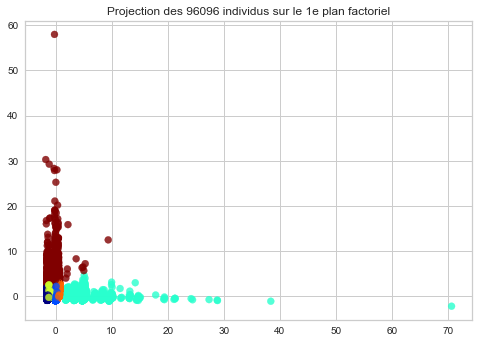

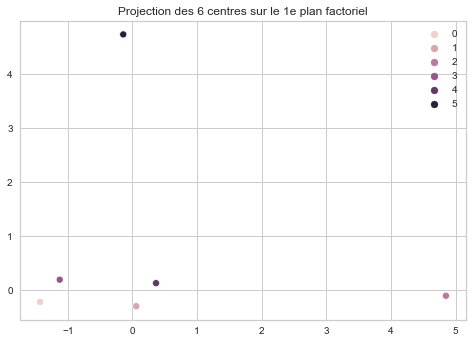

In [148]:
# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=3).fit(X_scaled56)
X_projected = pca.transform(X_scaled56)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters56.astype(np.float64), cmap = 'jet', alpha=.8)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show(block=False)

plt.figure()
centroids = km56.cluster_centers_
centroids_projected = pca.transform(centroids)
sns.scatterplot(x=centroids_projected[:,0],y=centroids_projected[:,1], hue=[0, 1, 2, 3, 4, 5])
plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids)))
plt.show()

### Etude statistique de chaque cluster

In [149]:
data_stat56 = dataK5.copy()
data_stat56['label'] = clusters56
data_stat56['label'].value_counts()

1    40884
4    29180
0    11875
3     9079
2     2987
5     2091
Name: label, dtype: int64

In [150]:
compare_stats(data_stat56, 'label')

0             1            2             3  \
count count  11875.000000  40884.000000  2987.000000  9.079000e+03   
R     mean     594.812463    593.517880   417.055239  3.363528e+02   
      min      468.000000    463.000000    29.000000  5.684342e-14   
      max      755.000000    773.000000   724.000000  4.620000e+02   
F     mean       1.000000      1.000000     2.116170  1.000000e+00   
      min        1.000000      1.000000     2.000000  1.000000e+00   
      max        1.000000      1.000000    17.000000  1.000000e+00   
M     mean     118.859604    116.811593   127.424384  1.190160e+02   
      min        2.200000      0.000000     5.990000  3.850000e+00   
      max      750.000000    712.900000  1200.000000  7.980000e+02   
week  mean       0.000000      1.000000     1.624707  0.000000e+00   
      min        0.000000      1.000000     0.000000  0.000000e+00   
      max        0.000000      1.000000    13.000000  0.000000e+00   

                        4             5  
count count  29180.000000   2091.000000  
R     mean     331.885881    488.635103  
      min        1.000000     30.000000  
      max      464.000000    732.000000  
F     mean       1.000000      1.005261  
      min        1.000000      1.000000  
      max        1.000000      3.000000  
M     mean     119.709478   1234.736656  
      min        2.290000    669.900000  
      max      755.990000  13440.000000  
week  mean       1.000000      0.802009  
      min        1.000000      0.000000  
      max        1.000000      3.000000

<AxesSubplot:xlabel='label', ylabel='week'>

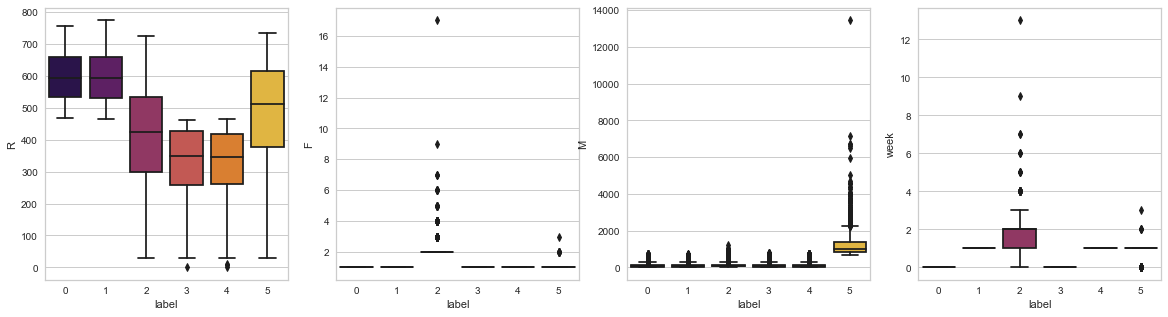

In [151]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.boxplot(ax= ax[0], data=data_stat56, x='label', y='R', palette='inferno')
sns.boxplot(ax= ax[1], data=data_stat56, x='label', y='F', palette='inferno')
sns.boxplot(ax= ax[2], data=data_stat56, x='label', y='M', palette='inferno')
sns.boxplot(ax= ax[3], data=data_stat56, x='label', y='week', palette='inferno')

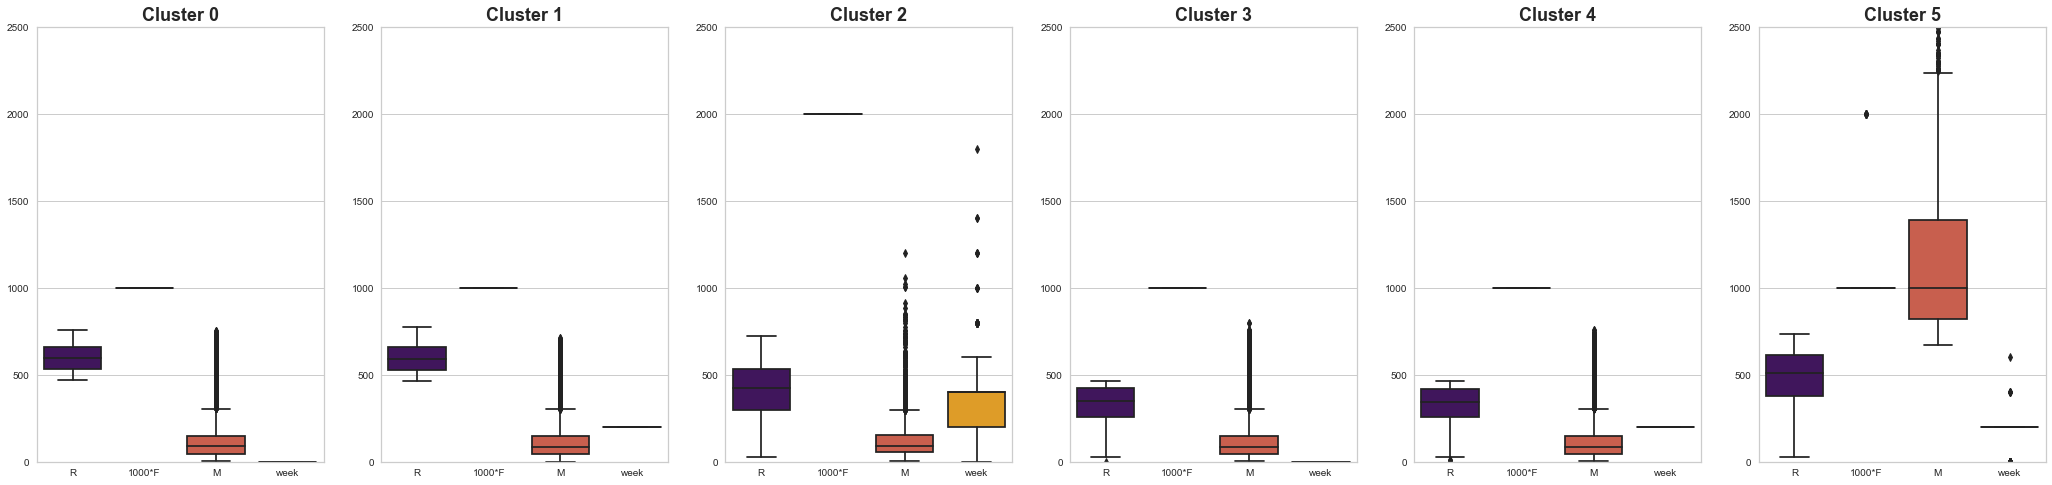

In [152]:
fig, ax = plt.subplots(1, 6, figsize=(36, 8))
for i in range(6):
    data_plot56 = data_stat56.loc[data_stat56['label']==i, ['R', 'F', 'M', 'week']]
    data_plot56['F'] = data_plot56['F'] * 1000
    data_plot56['week'] = data_plot56['week'] * 200
    sns.boxplot(ax= ax[i], data=data_plot56, palette='inferno')
    ax[i].set_title(f"Cluster {i}", fontsize=18, weight='bold')
    ax[i].set_xticklabels(['R', '1000*F', 'M', 'week'])
    ax[i].set_ylim(0, 2500)
fig.savefig('boxplot_week.pdf')

In [153]:
# Profil 2 : plusieurs achats
# Profil 1 : 1 achat - montant inférieur à 800 euros - achat la semaine - achat ancien 
# Profil 4 : 1 achat - montant inférieur à 800 euros - achat la semaine - achat récent 
# Profil 0 : 1 achat - montant inférieur à 800 euros - achat le week-end - achat ancien
# Profil 3 : 1 achat - montant inférieur à 800 euros - achat le week-end - achat récent
# Profil 5 : montant supérieur à 700 euros

In [154]:
compare_stats(data_stat55, 'label')

0             1             2            3  \
count count  40875.000000   2139.000000  2.922100e+04  2987.000000   
R     mean     593.499817    486.584853  3.312364e+02   417.055239   
      min      463.000000     30.000000  5.684342e-14    29.000000   
      max      773.000000    732.000000  4.640000e+02   724.000000   
F     mean       1.000000      1.005143  1.000000e+00     2.116170   
      min        1.000000      1.000000  1.000000e+00     2.000000   
      max        1.000000      3.000000  1.000000e+00    17.000000   
M     mean     116.597262   1223.168255  1.194637e+02   127.424384   
      min        0.000000    659.000000  2.290000e+00     5.990000   
      max      704.500000  13440.000000  7.559900e+02  1200.000000   
week  mean       1.000000      0.798504  9.978440e-01     1.624707   
      min        1.000000      0.000000  0.000000e+00     0.000000   
      max        1.000000      3.000000  1.000000e+00    13.000000   

                        4  
count count  20874.000000  
R     mean     484.311967  
      min      125.000000  
      max      755.000000  
F     mean       1.000000  
      min        1.000000  
      max        1.000000  
M     mean     118.308262  
      min        2.200000  
      max      735.000000  
week  mean       0.000000  
      min        0.000000  
      max        0.000000

# Avec features review, voucher et week

In [155]:
dataK6 = data.loc[:, ['R', 'F', 'M', 'voucher', 'review_score_mean', 'week']]

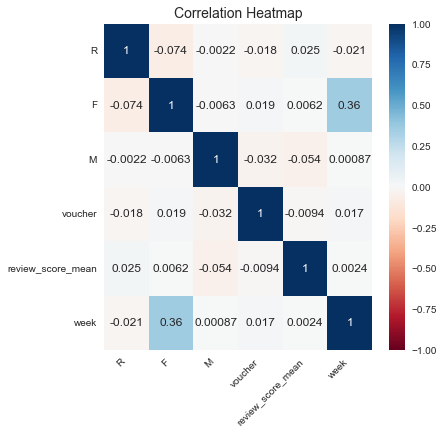

In [286]:
plt.figure(figsize=(6, 6))
sns.heatmap(dataK6.corr(),annot=True,cmap='RdBu', vmin=-1, vmax=1)
plt.title('Correlation Heatmap',fontsize=14)
plt.yticks(rotation =0)
plt.xticks(rotation =45, ha='right', va='top')
plt.show()

In [157]:
X_scaled6 = preprocessing.StandardScaler().fit_transform(dataK6)

### Distortion score

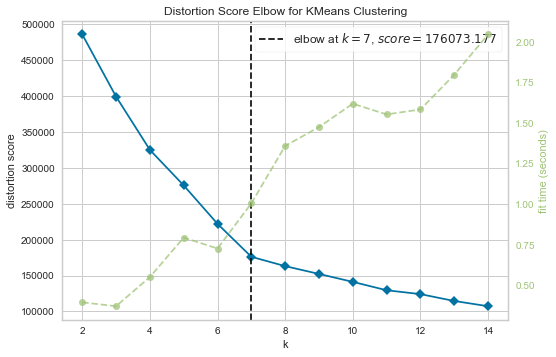

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [158]:
model6 = KMeans()
visualizer6 = KElbowVisualizer(model6, k=(2,15))
visualizer6.fit(X_scaled6)    
visualizer6.poof()  

In [159]:
# Echantillon
dataK_sample6 = dataK6.sample(10000)
X_scaled_sample6 = StandardScaler().fit_transform(dataK_sample6)

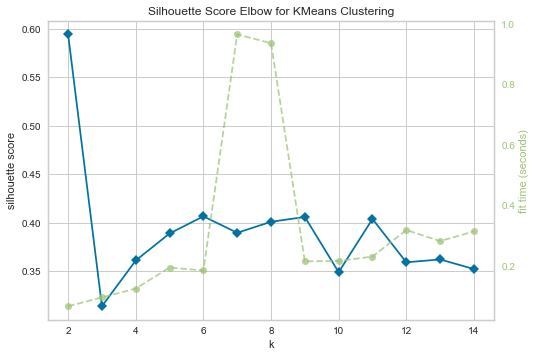

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [160]:
visualizer6 = KElbowVisualizer(model6, k=(2,15), metric='silhouette', locate_elbow=False)
visualizer6.fit(X_scaled_sample6)    
visualizer6.poof()  

### Stability

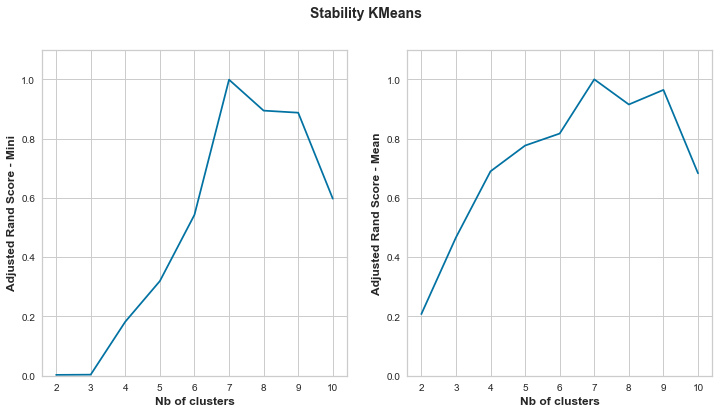

In [295]:
from sklearn.metrics import adjusted_rand_score
stability_KMeans(X_scaled_sample6, 2, 10)

## Clustering avec 7 clusters

In [162]:
X_scaled67 = StandardScaler().fit_transform(dataK6)
# Nombre de clusters souhaités
n_clust = 7
km67 = KMeans(n_clusters= n_clust, random_state=0)
km67.fit(X_scaled67)

# Récupération des clusters attribués à chaque individu
clusters67 = km67.labels_

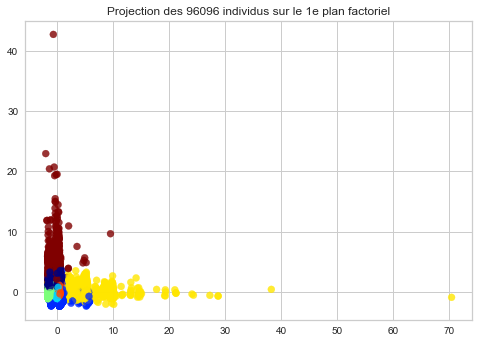

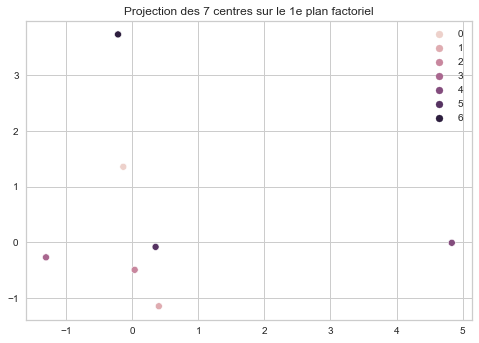

In [163]:
# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=4).fit(X_scaled67)
X_projected = pca.transform(X_scaled67)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters67.astype(np.float64), cmap = 'jet', alpha=.8)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show(block=False)

plt.figure()
centroids = km67.cluster_centers_
centroids_projected = pca.transform(centroids)
sns.scatterplot(x=centroids_projected[:,0],y=centroids_projected[:,1], hue=[0, 1, 2, 3, 4, 5, 6])
plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids)))
plt.show()

### Etude statistique de chaque cluster

In [164]:
data_stat67 = dataK6.copy()
data_stat67['label'] = clusters67

data_stat67['label'].value_counts()

2    32761
5    23878
3    17353
0    14408
1     2960
4     2930
6     1806
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='week'>

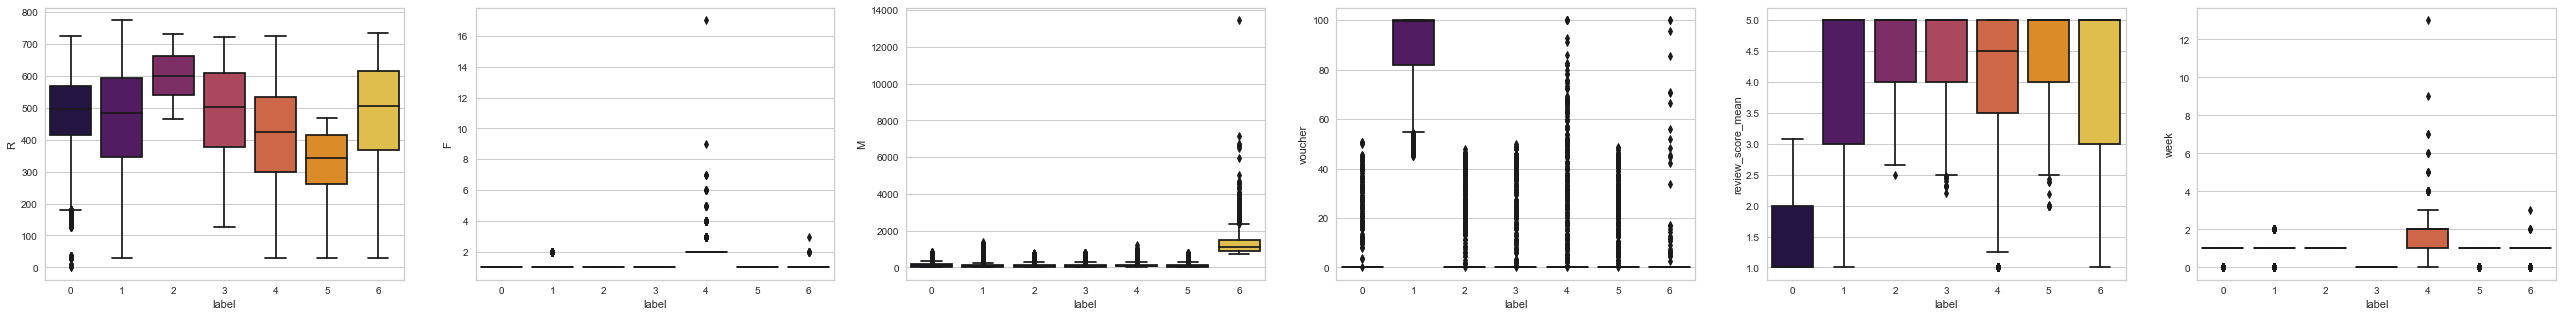

In [165]:
fig, ax = plt.subplots(1, 6, figsize=(45, 5))
sns.boxplot(ax= ax[0], data=data_stat67, x='label', y='R', palette='inferno')
sns.boxplot(ax= ax[1], data=data_stat67, x='label', y='F', palette='inferno')
sns.boxplot(ax= ax[2], data=data_stat67, x='label', y='M', palette='inferno')
sns.boxplot(ax= ax[3], data=data_stat67, x='label', y='voucher', palette='inferno')
sns.boxplot(ax= ax[4], data=data_stat67, x='label', y='review_score_mean', palette='inferno')
sns.boxplot(ax= ax[5], data=data_stat67, x='label', y='week', palette='inferno')

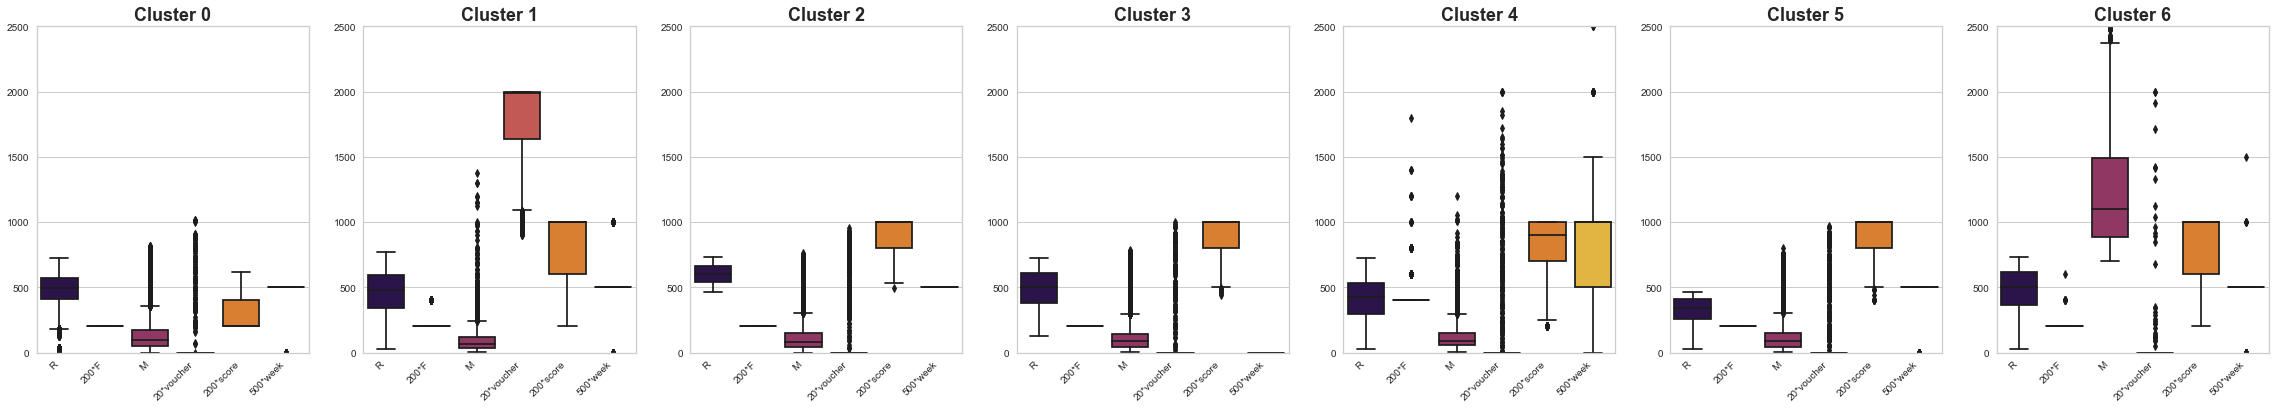

In [166]:
fig, ax = plt.subplots(1, 7, figsize=(40, 6))
for i in range(7):
    data_plot67 = data_stat67.loc[data_stat67['label']==i, ['R', 'F', 'M', 'voucher', 'review_score_mean', 'week']]
    data_plot67['F'] = data_plot67['F'] * 200
    data_plot67['review_score_mean'] = data_plot67['review_score_mean'] * 200
    data_plot67['voucher'] = data_plot67['voucher'] * 20
    data_plot67['week'] = data_plot67['week'] * 500
    sns.boxplot(ax= ax[i], data=data_plot67, palette='inferno')
    ax[i].set_title(f"Cluster {i}", fontsize=18, weight='bold')
    ax[i].set_xticklabels(['R', '200*F', 'M', '20*voucher', '200*score', '500*week'], rotation=45, horizontalalignment='right')
    ax[i].set_ylim(0, 2500)

In [167]:
# Profil 6 : 2 achats ou moins - gros montant (plus de 1290) 
# Profil 4: >= 2 achats  
# Profil 1 : =< 2 achats - montant < 1375 et voucher > 45% 
# Profil 2 : 1 achat - montant < 820 et voucher < 52% - achat en semaine - récent (<1753) 
# Profil 5 : 1 achat - montant < 820 et voucher < 52% - achat ancien (>1752) 
# Profil 3 : 1 achat - montant < 820 et voucher < 52% -  achat week-end 
# Profil 0 : 1 achat - montant < 820 et voucher < 52% -  score<3

#La séparation des clusters n'est pas optimum

In [168]:
compare_stats(data_stat67, 'label')

0            1             2  \
count             count  1.440800e+04  2960.000000  32761.000000   
R                 mean   4.776978e+02   467.836486    600.070663   
                  min    5.684342e-14    30.000000    465.000000   
                  max    7.240000e+02   773.000000    729.000000   
F                 mean   1.000000e+00     1.019257      1.000000   
                  min    1.000000e+00     1.000000      1.000000   
                  max    1.000000e+00     2.000000      1.000000   
M                 mean   1.401083e+02    98.080034    115.739173   
                  min    0.000000e+00     2.200000      0.000000   
                  max    8.199000e+02  1375.000000    759.900000   
voucher           mean   1.885969e-01    89.547916      0.156168   
                  min    0.000000e+00    44.916647      0.000000   
                  max    5.083075e+01   100.000000     47.801147   
review_score_mean mean   1.398246e+00     4.031147      4.620384   
                  min    1.000000e+00     1.000000      2.489252   
                  max    3.086370e+00     5.000000      5.000000   
week              mean   7.933787e-01     0.809797      1.000000   
                  min    0.000000e+00     0.000000      1.000000   
                  max    1.000000e+00     2.000000      1.000000   

                                    3            4             5             6  
count             count  17353.000000  2930.000000  23878.000000   1806.000000  
R                 mean     485.580188   416.927986    330.194782    484.936877  
                  min      125.000000    29.000000     29.000000     30.000000  
                  max      721.000000   724.000000    467.000000    732.000000  
F                 mean       1.000000     2.118430      1.000000      1.006091  
                  min        1.000000     2.000000      1.000000      1.000000  
                  max        1.000000    17.000000      1.000000      3.000000  
M                 mean     116.673697   128.169298    119.569626   1310.806316  
                  min        3.850000     6.900000      2.290000    705.140000  
                  max      783.140000  1200.000000    799.000000  13440.000000  
voucher           mean       0.186850     3.049252      0.171874      0.596585  
                  min        0.000000     0.000000      0.000000      0.000000  
                  max       49.865364   100.000000     48.582996    100.000000  
review_score_mean mean       4.566285     4.109750      4.606016      3.884287  
                  min        2.212690     1.000000      2.000000      1.000000  
                  max        5.000000     5.000000      5.000000      5.000000  
week              mean       0.000000     1.622526      0.998241      0.783499  
                  min        0.000000     0.000000      0.000000      0.000000  
                  max        0.000000    13.000000      1.000000      3.000000

# Tentatives de réduction dimentionnelle puis clustering
### ACP

In [169]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [170]:
# nombre de composantes à calculer
n_comp = 6
features = dataK6.columns

std_scale = StandardScaler().fit(dataK6.values)
X_scaled = std_scale.transform(dataK6.values)
pca = PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=6)

In [171]:
reduced_data = pd.DataFrame(pca.transform(X_scaled))
(pca.score(X_scaled))

-8.43990422754221

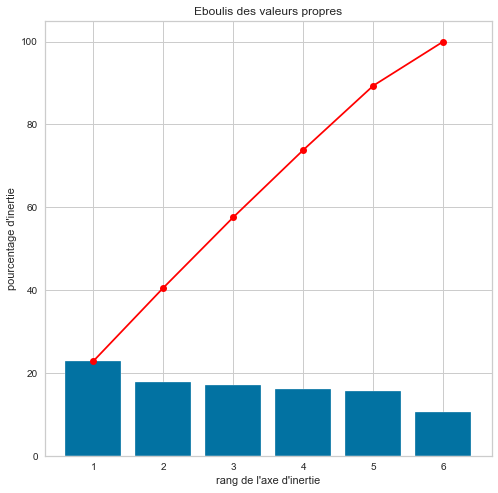

In [172]:
# Eboulis des valeurs propres
scree = pca.explained_variance_ratio_*100
fig, ax = plt.subplots(figsize=(8, 8))
ax = plt.bar(np.arange(len(scree))+1, scree)
ax = plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
ax = plt.xlabel("rang de l'axe d'inertie")
ax = plt.ylabel("pourcentage d'inertie")
ax = plt.title("Eboulis des valeurs propres")


In [173]:
# On constate que chaque axe factoriel contribue à peu près de la même manière à la variance des données (autour de 18%).
# Donc la réduction dimensionnelle n'a pas de sens

### T-SNE 3 composantes

In [174]:
from sklearn.manifold import TSNE

X1 = dataK6
X = X1.sample(10000, random_state=0)
index = X.index
scl = StandardScaler()

In [175]:
X_scaled_tsne = scl.fit_transform(X)

In [176]:
X_tsne = TSNE(n_components=3).fit_transform(X_scaled_tsne)

/opt/anaconda3/envs/baseClone/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/baseClone/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


#### Choix nombre clusters

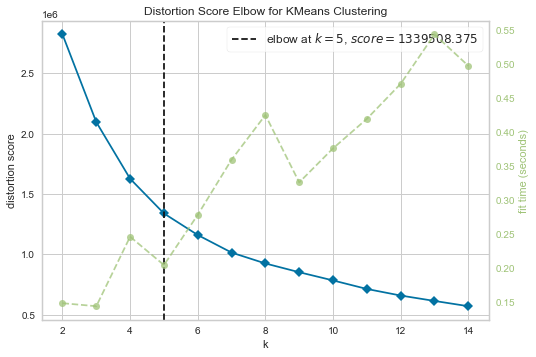

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [177]:
model_tsne = KMeans()
visualizer_tsne = KElbowVisualizer(model_tsne, k=(2,15))
visualizer_tsne.fit(X_tsne)    
visualizer_tsne.poof()  

#### Silhouette

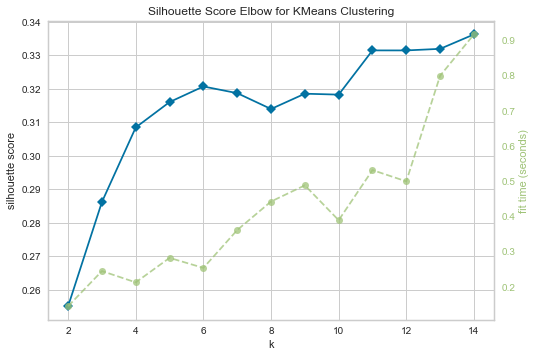

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [178]:
visualizer_tsne = KElbowVisualizer(model_tsne, k=(2,15), metric='silhouette', locate_elbow=False)
visualizer_tsne.fit(X_tsne)    
visualizer_tsne.poof()  

#### Stability

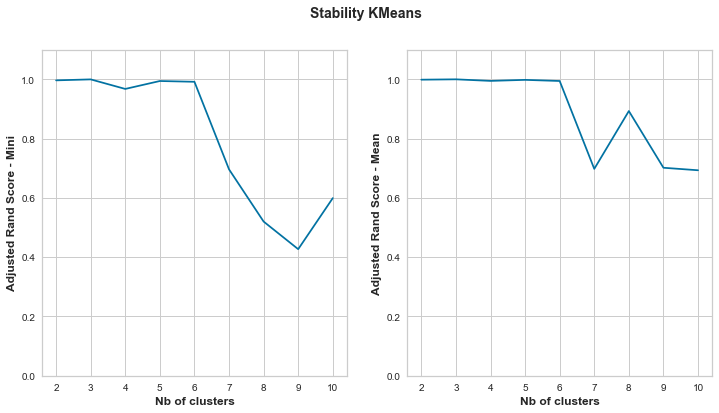

In [296]:
from sklearn.metrics import adjusted_rand_score
stability_KMeans(X_tsne, 2, 10)

#### Clustering 6 clusters

In [180]:
# Nombre de clusters souhaités
n_clust = 6
km_tsne = KMeans(n_clusters= n_clust, random_state=42)
km_tsne.fit(X_tsne)

# Récupération des clusters attribués à chaque individu
clusters_tsne = km_tsne.labels_

In [181]:
pd.DataFrame(clusters_tsne).value_counts()

1    1824
4    1815
5    1805
3    1664
0    1507
2    1385
dtype: int64

In [182]:
data_stat_tsne = pd.DataFrame(X_tsne).rename(columns={0: 'F1', 1: 'F2', 2: 'F3'})
data_stat_tsne['label'] = clusters_tsne

In [183]:
compare_stats(data_stat_tsne, 'label')

0            1            2            3            4  \
count count  1507.000000  1824.000000  1385.000000  1664.000000  1815.000000   
F1    mean      0.991254     0.682124    -1.049045    -0.448902    13.825174   
      min     -12.616296   -13.443127   -11.596927   -10.155250     1.346898   
      max      16.833670    16.271059    11.879038    10.105079    27.426153   
F2    mean    -12.932806    16.150433     7.238443    -5.949097    -2.570658   
      min     -20.284233     5.683933    -2.990373   -17.708820   -17.148556   
      max      -2.173629    25.028051    20.384809     6.223700    13.587714   
F3    mean    -10.615679     3.916331   -14.209474    16.075539     2.129840   
      min     -21.522278    -9.736918   -24.404335     2.148093   -13.629494   
      max       2.584998    17.926109    -2.415285    24.975952    15.275569   

                       5  
count count  1805.000000  
F1    mean    -17.032091  
      min     -25.172832  
      max      -4.274829  
F2    mean     -1.588756  
      min     -19.791735  
      max      16.639069  
F3    mean     -0.796623  
      min     -15.537452  
      max      11.881317

In [184]:
cmap = plt.get_cmap('viridis')
colors = np.linspace(0, 1, 6)
color=[cmap(colors[i]) for i in range(6)]

In [185]:
data_stat_tsne.iloc[:, 1].shape

(10000,)

<AxesSubplot:xlabel='F2', ylabel='F3'>

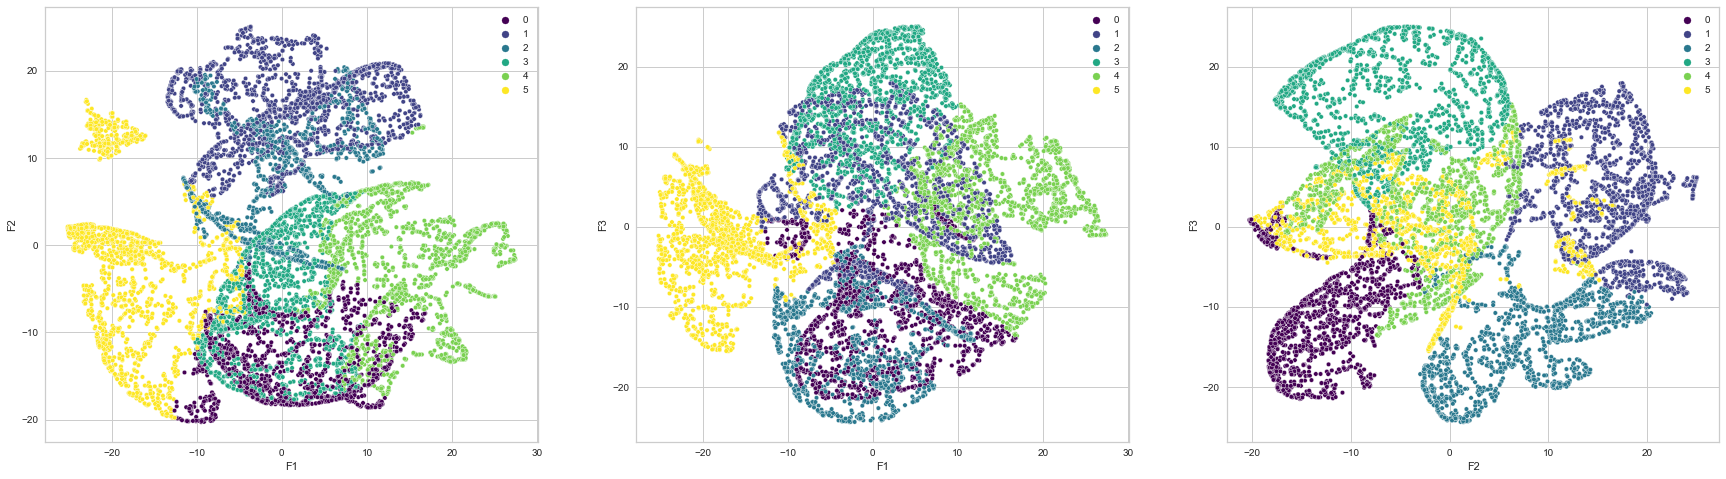

In [186]:
fig, ax = plt.subplots(1, 3, figsize=(30, 8))
sns.scatterplot(ax=ax[0], x=data_stat_tsne.iloc[:, 0], y=data_stat_tsne.iloc[:, 1], hue=clusters_tsne, palette=color, s=20)
sns.scatterplot(ax=ax[1], x=data_stat_tsne.iloc[:, 0], y=data_stat_tsne.iloc[:, 2], hue=clusters_tsne, palette=color, s=20)
sns.scatterplot(ax=ax[2], x=data_stat_tsne.iloc[:, 1], y=data_stat_tsne.iloc[:, 2], hue=clusters_tsne, palette=color, s=20)

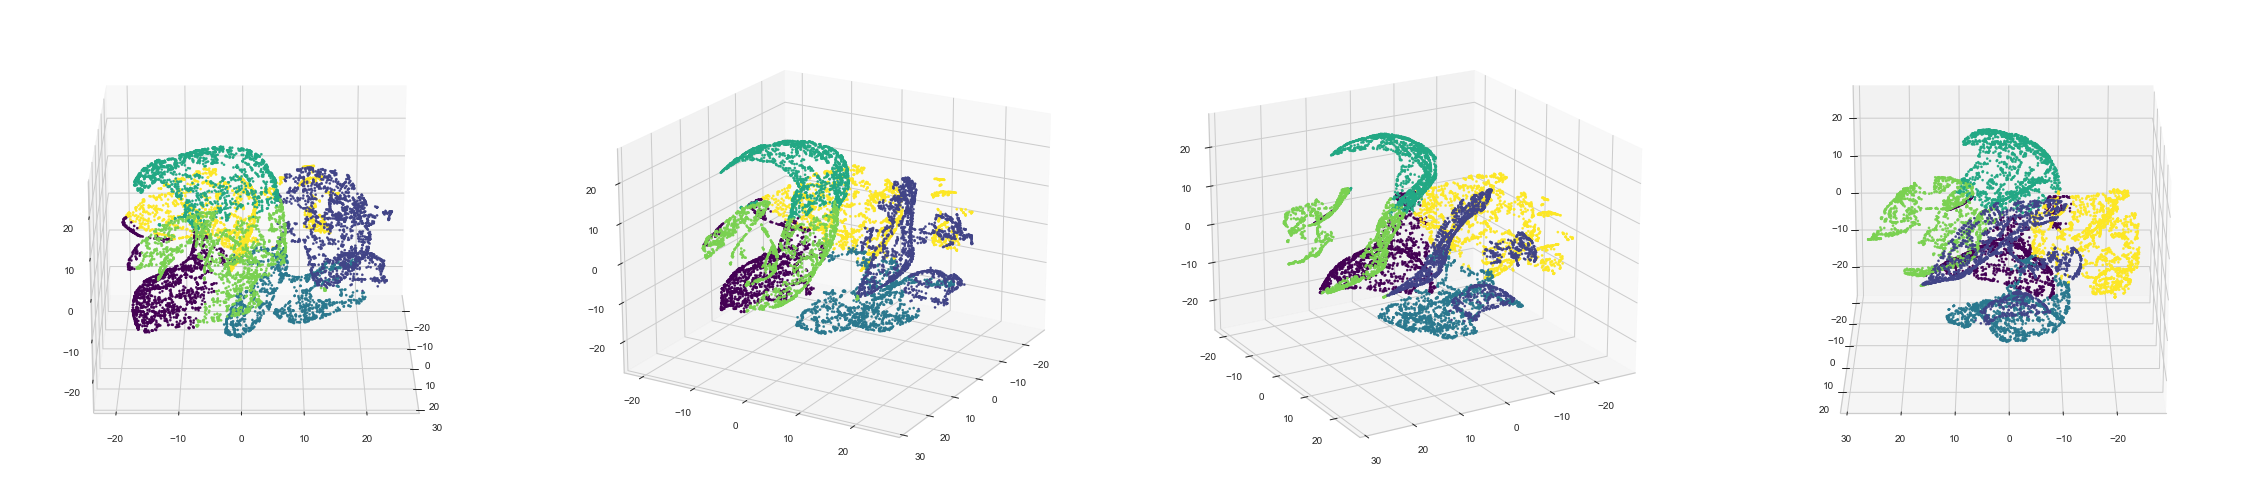

In [187]:
fig= plt.figure(figsize =(40, 20))

x=X_tsne[:, 0]
y=X_tsne[:, 1]
z=X_tsne[:, 2]
labels = clusters_tsne
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, projection='3d')
    ax.scatter3D(x, y, z, c=labels, cmap='viridis', alpha=1, s=5)
    ax.view_init(20, 30*i)

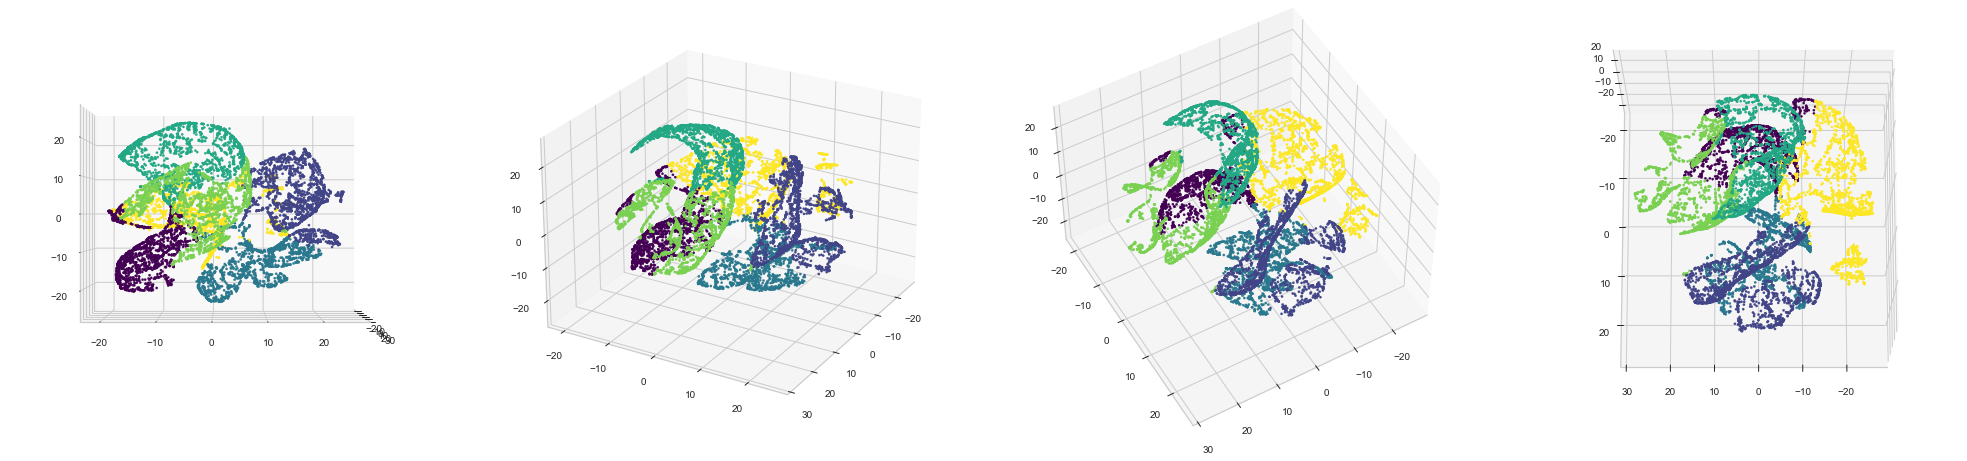

In [188]:
fig= plt.figure(figsize =(35, 15))

x=X_tsne[:, 0]
y=X_tsne[:, 1]
z=X_tsne[:, 2]
labels = clusters_tsne
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, projection='3d')
    ax.scatter3D(x, y, z, c=labels, cmap='viridis', alpha=1, s=5)
    ax.view_init(25*i, 30*i)

<AxesSubplot:xlabel='label', ylabel='F3'>

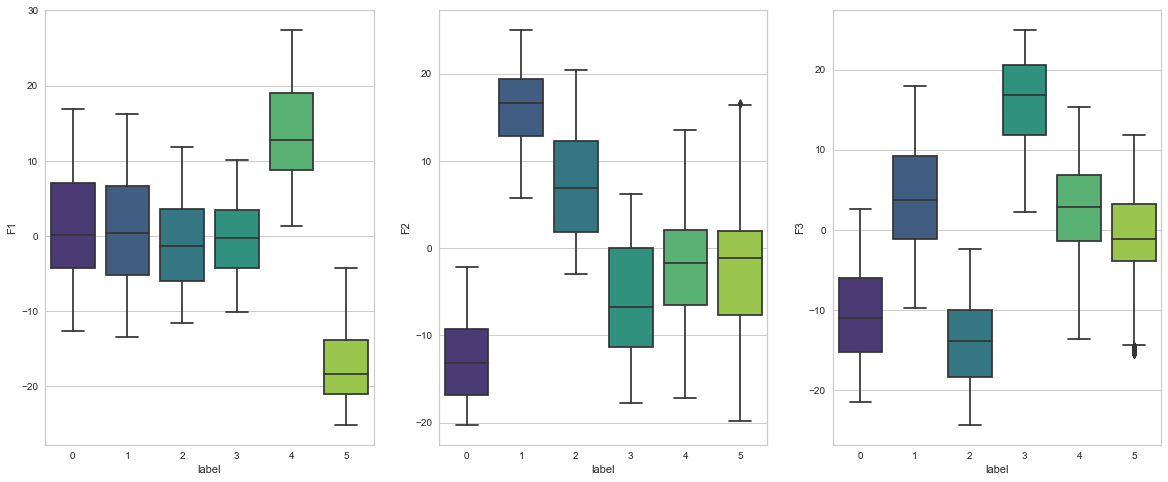

In [189]:
fig, ax = plt.subplots(1, 3, figsize=(20, 8))
sns.boxplot(ax= ax[0], data=data_stat_tsne, x='label', y='F1', palette='viridis')
sns.boxplot(ax= ax[1], data=data_stat_tsne, x='label', y='F2', palette='viridis')
sns.boxplot(ax= ax[2], data=data_stat_tsne, x='label', y='F3', palette='viridis')


In [190]:
dataK6 = dataK6.rename(columns={'voucher_sum': 'voucher', 'review_score_mean_mean': 'score', 'week_sum': 'week' })
data_cluster = dataK6.iloc[index, :]
data_cluster['label'] = clusters_tsne

/var/folders/cg/rgv17yks2975h8b2p1c414640000gn/T/ipykernel_731/2718780086.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cluster['label'] = clusters_tsne


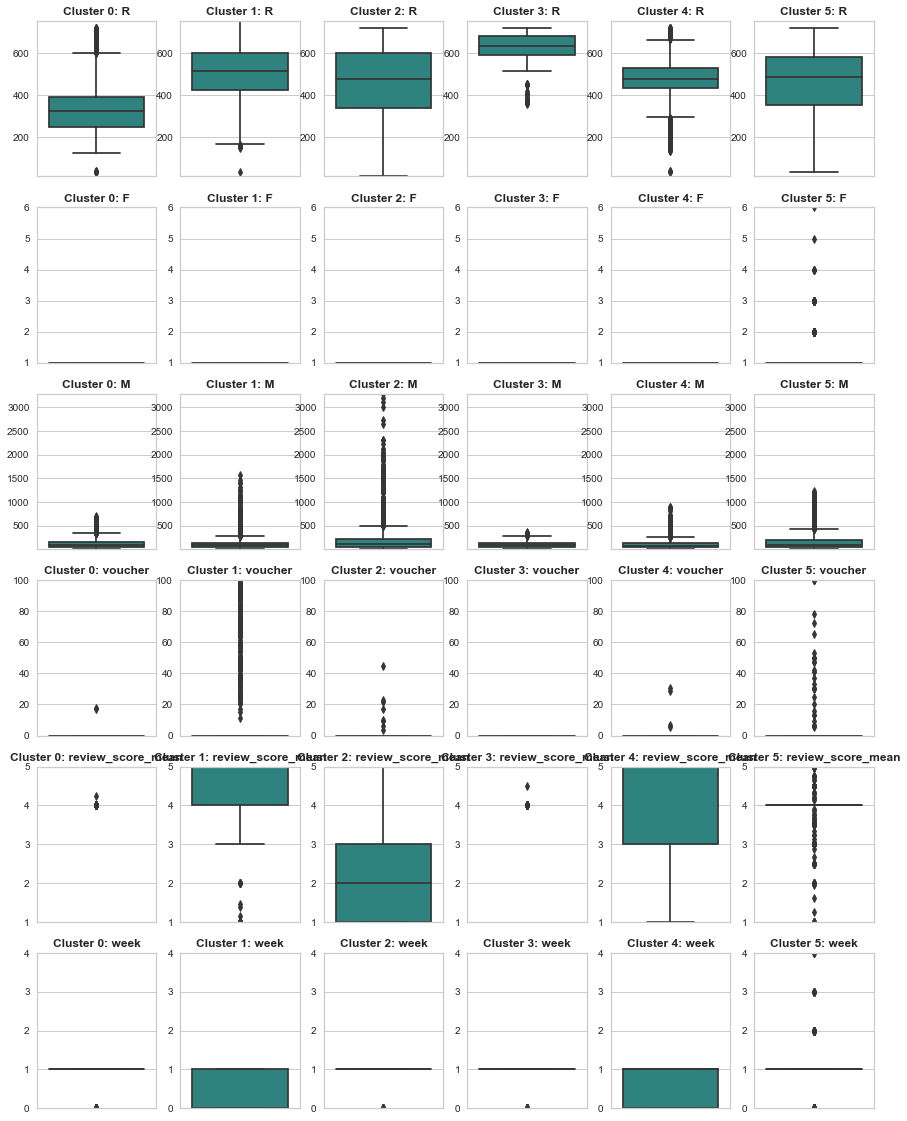

In [191]:
fig, ax = plt.subplots(6, 6, figsize=(15, 20))

for i in range(6):
    for j in range(6):
        data_plot_cluster = data_cluster.loc[data_cluster['label']==j, :]
        sns.boxplot(ax=ax[i][j], data=data_plot_cluster, y=data_cluster.columns[i] ,palette='viridis', orient='v')
        ax[i][j].set_title(f"Cluster {j}: {data_cluster.columns[i]}", fontsize=12, weight='bold')
        ax[i][j].set_xticklabels('')
        ax[i][j].set(ylabel='')
        ax[i][j].set_ylim(data_cluster.loc[:, data_cluster.columns[i]].min(), data_cluster.loc[:, data_cluster.columns[i]].max())

### T-SNE 2 composantes

In [192]:
X_tsne2 = TSNE(n_components=2).fit_transform(X_scaled_tsne)

/opt/anaconda3/envs/baseClone/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/baseClone/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


#### Choix nombre clusters

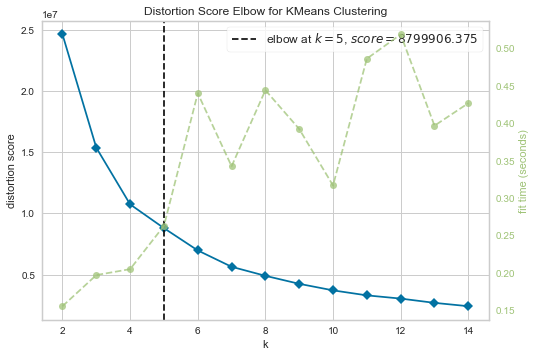

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [193]:
model_tsne = KMeans()
visualizer_tsne = KElbowVisualizer(model_tsne, k=(2,15))
visualizer_tsne.fit(X_tsne2)    
visualizer_tsne.poof()  

#### Silhouette

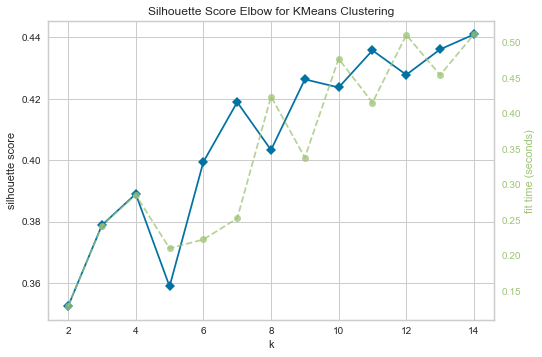

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [194]:
visualizer_tsne = KElbowVisualizer(model_tsne, k=(2,15), metric='silhouette', locate_elbow=False)
visualizer_tsne.fit(X_tsne2)    
visualizer_tsne.poof()  

#### Stability

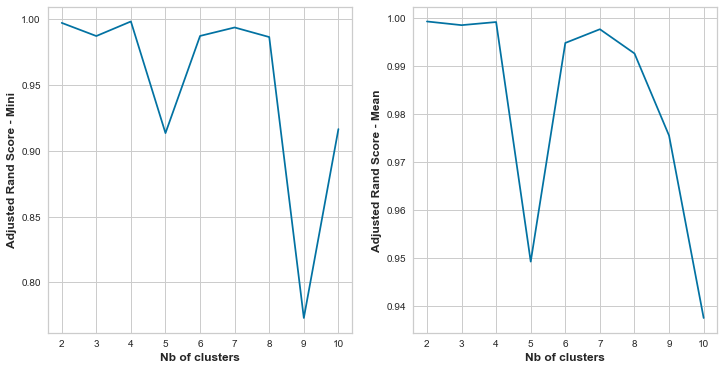

In [195]:
from sklearn.metrics import adjusted_rand_score
stability_KMeans(X_tsne2, 2, 10)

#### Clustering 6 clusters

In [196]:
# Nombre de clusters souhaités
n_clust = 6
km_tsne2 = KMeans(n_clusters= n_clust, random_state=42)
km_tsne2.fit(X_tsne2)

# Récupération des clusters attribués à chaque individu
clusters_tsne2 = km_tsne2.labels_

In [197]:
pd.DataFrame(clusters_tsne2).value_counts()

3    1794
1    1734
4    1689
0    1643
5    1616
2    1524
dtype: int64

In [198]:
data_stat_tsne2 = pd.DataFrame(X_tsne2).rename(columns={0: 'F1', 1: 'F2', 2: 'F3'})
data_stat_tsne2['label'] = clusters_tsne2

In [199]:
compare_stats(data_stat_tsne2, 'label')

0            1            2            3            4  \
count count  1643.000000  1734.000000  1524.000000  1794.000000  1689.000000   
F1    mean    -17.700243    -3.385164   -24.349768    47.106289   -58.443810   
      min     -59.221710   -36.880318   -67.830353    12.916041  -101.845177   
      max      14.208745    30.064217    22.240433    76.116592   -27.345171   
F2    mean    -52.512905    11.133337    63.812885   -42.681705    -5.576210   
      min     -91.374725   -25.052929    38.152657   -79.960670   -48.604580   
      max     -17.551928    37.647701    92.133156    -7.902580    38.373131   

                       5  
count count  1616.000000  
F1    mean     56.005539  
      min      16.702356  
      max      84.378281  
F2    mean     33.239048  
      min       2.973085  
      max      67.178963

In [200]:
cmap = plt.get_cmap('viridis')
colors = np.linspace(0, 1, 6)
color=[cmap(colors[i]) for i in range(6)]

<AxesSubplot:xlabel='F1', ylabel='F2'>

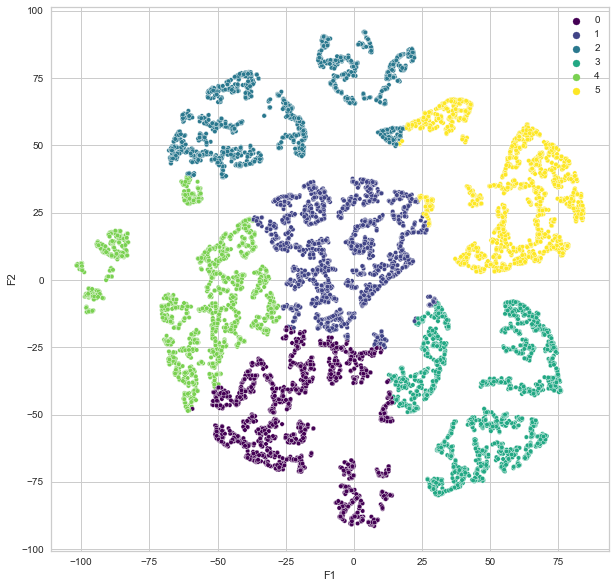

In [201]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(ax=ax, x=data_stat_tsne2.iloc[:, 0], y=data_stat_tsne2.iloc[:, 1], hue=clusters_tsne2, palette=color, s=20)


<AxesSubplot:xlabel='label', ylabel='F2'>

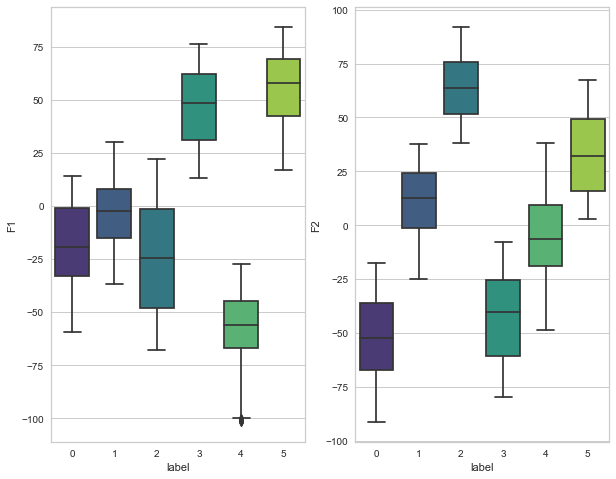

In [202]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
sns.boxplot(ax= ax[0], data=data_stat_tsne2, x='label', y='F1', palette='viridis')
sns.boxplot(ax= ax[1], data=data_stat_tsne2, x='label', y='F2', palette='viridis')

In [203]:
compare_stats(data_stat_tsne2, 'label')

0            1            2            3            4  \
count count  1643.000000  1734.000000  1524.000000  1794.000000  1689.000000   
F1    mean    -17.700243    -3.385164   -24.349768    47.106289   -58.443810   
      min     -59.221710   -36.880318   -67.830353    12.916041  -101.845177   
      max      14.208745    30.064217    22.240433    76.116592   -27.345171   
F2    mean    -52.512905    11.133337    63.812885   -42.681705    -5.576210   
      min     -91.374725   -25.052929    38.152657   -79.960670   -48.604580   
      max     -17.551928    37.647701    92.133156    -7.902580    38.373131   

                       5  
count count  1616.000000  
F1    mean     56.005539  
      min      16.702356  
      max      84.378281  
F2    mean     33.239048  
      min       2.973085  
      max      67.178963

In [204]:
dataK6 = dataK6.rename(columns={'voucher_sum': 'voucher', 'review_score_mean_mean': 'score', 'week_sum': 'week' })
data_cluster2 = dataK6.iloc[index, :]
data_cluster2['label'] = clusters_tsne2

/var/folders/cg/rgv17yks2975h8b2p1c414640000gn/T/ipykernel_731/1803166523.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cluster2['label'] = clusters_tsne2


/var/folders/cg/rgv17yks2975h8b2p1c414640000gn/T/ipykernel_731/3234148542.py:10: UserWarning: Attempting to set identical bottom == top == 1.0 results in singular transformations; automatically expanding.
  ax[i][j].set_ylim(data_plot_cluster2.loc[:, data_plot_cluster2.columns[i]].min(), data_plot_cluster2.loc[:, data_plot_cluster2.columns[i]].max())
/var/folders/cg/rgv17yks2975h8b2p1c414640000gn/T/ipykernel_731/3234148542.py:10: UserWarning: Attempting to set identical bottom == top == 1.0 results in singular transformations; automatically expanding.
  ax[i][j].set_ylim(data_plot_cluster2.loc[:, data_plot_cluster2.columns[i]].min(), data_plot_cluster2.loc[:, data_plot_cluster2.columns[i]].max())
/var/folders/cg/rgv17yks2975h8b2p1c414640000gn/T/ipykernel_731/3234148542.py:10: UserWarning: Attempting to set identical bottom == top == 1.0 results in singular transformations; automatically expanding.
  ax[i][j].set_ylim(data_plot_cluster2.loc[:, data_plot_cluster2.columns[i]].min(), data_

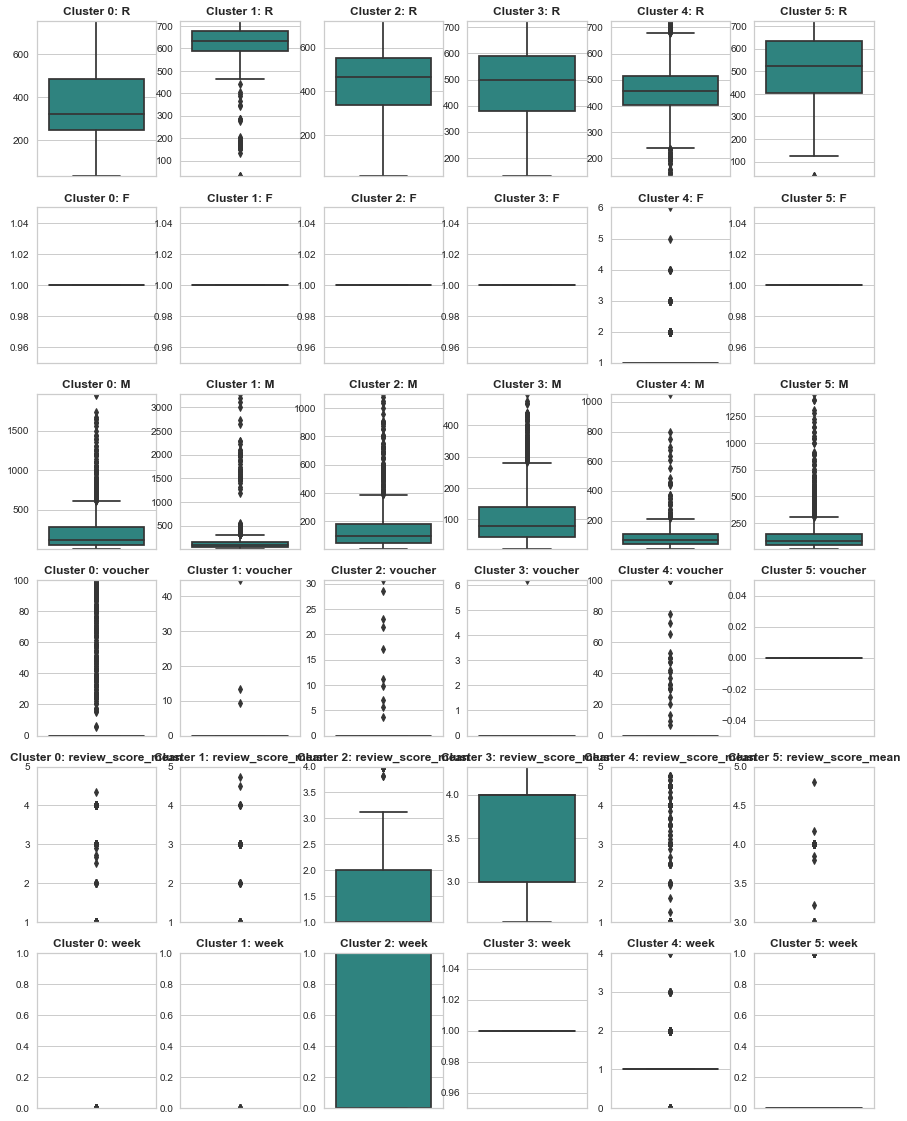

In [205]:
fig, ax = plt.subplots(6, 6, figsize=(15, 20))

for i in range(6):
    for j in range(6):
        data_plot_cluster2 = data_cluster2.loc[data_cluster2['label']==j, :]
        sns.boxplot(ax=ax[i][j], data=data_plot_cluster2, y=data_plot_cluster2.columns[i] ,palette='viridis', orient='v')
        ax[i][j].set_title(f"Cluster {j}: {data_plot_cluster2.columns[i]}", fontsize=12, weight='bold')
        ax[i][j].set_xticklabels('')
        ax[i][j].set(ylabel='')
        ax[i][j].set_ylim(data_plot_cluster2.loc[:, data_plot_cluster2.columns[i]].min(), data_plot_cluster2.loc[:, data_plot_cluster2.columns[i]].max())

### LLE 2 composantes

In [206]:
from sklearn.manifold import LocallyLinearEmbedding

X1 = dataK6
X = X1.sample(10000, random_state=0)
index = X.index
scl = StandardScaler()

In [207]:
X_scaled_LLE = scl.fit_transform(X)

In [208]:
X_LLE = LocallyLinearEmbedding(n_components=2).fit_transform(X_scaled_LLE)

#### Choix nombre clusters

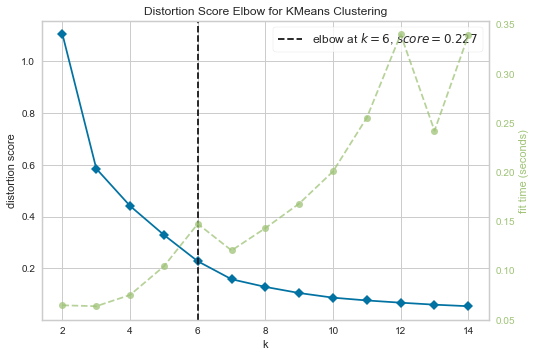

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [209]:
model_tsne = KMeans()
visualizer_tsne = KElbowVisualizer(model_tsne, k=(2,15))
visualizer_tsne.fit(X_LLE)    
visualizer_tsne.poof()  

#### Silhouette

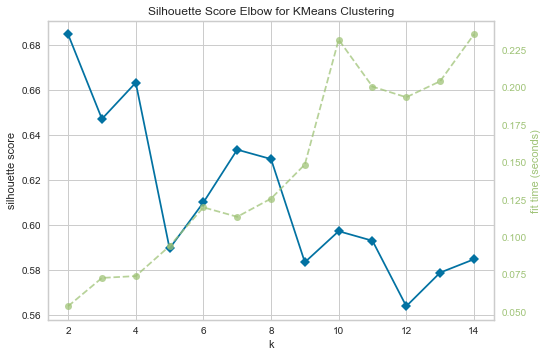

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [210]:
visualizer_tsne = KElbowVisualizer(model_tsne, k=(2,15), metric='silhouette', locate_elbow=False)
visualizer_tsne.fit(X_LLE)    
visualizer_tsne.poof()  

#### Stability

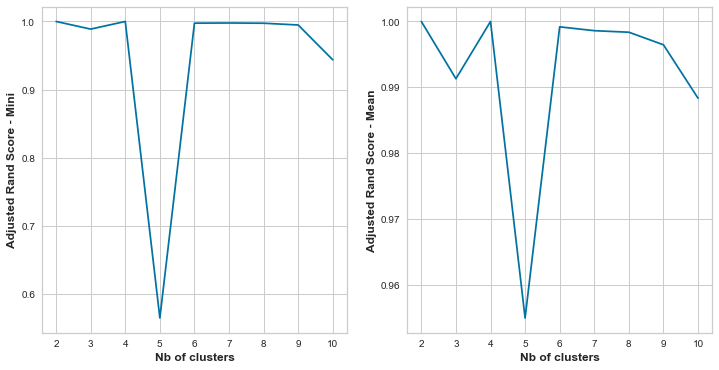

In [211]:
from sklearn.metrics import adjusted_rand_score
stability_KMeans(X_LLE, 2, 10)

#### Clustering 7 clusters

In [212]:
# Nombre de clusters souhaités
n_clust = 7
km_LLE5 = KMeans(n_clusters= n_clust, random_state=42)
km_LLE5.fit(X_LLE)

# Récupération des clusters attribués à chaque individu
clusters_LLE5 = km_LLE5.labels_

In [213]:
pd.DataFrame(clusters_LLE5).value_counts()

1    6108
4    1991
0     783
5     589
2     261
3     188
6      80
dtype: int64

In [214]:
data_stat_LLE5 = pd.DataFrame(X_LLE).rename(columns={0: 'F1', 1: 'F2', 2: 'F3'})
data_stat_LLE5['label'] = clusters_LLE5

In [215]:
compare_stats(data_stat_LLE5, 'label')

0            1           2           3            4  \
count count  783.000000  6108.000000  261.000000  188.000000  1991.000000   
F1    mean     0.027218    -0.000125   -0.000674   -0.026575     0.009908   
      min      0.018742    -0.013270   -0.001039   -0.065812     0.004896   
      max      0.057434     0.004887    0.000083   -0.013418     0.018524   
F2    mean     0.000102    -0.000406   -0.047111    0.001355    -0.000193   
      min     -0.008938    -0.011159   -0.065114   -0.000513    -0.003042   
      max      0.007285     0.014329   -0.034666    0.005034     0.004679   

                      5          6  
count count  589.000000  80.000000  
F1    mean    -0.000069   0.000422  
      min     -0.001747  -0.000484  
      max      0.000857   0.002163  
F2    mean    -0.021977   0.029268  
      min     -0.034249   0.014793  
      max     -0.011228   0.044840

In [216]:
cmap = plt.get_cmap('viridis')
colors = np.linspace(0, 1, 7)
color=[cmap(colors[i]) for i in range(7)]

<AxesSubplot:xlabel='F1', ylabel='F2'>

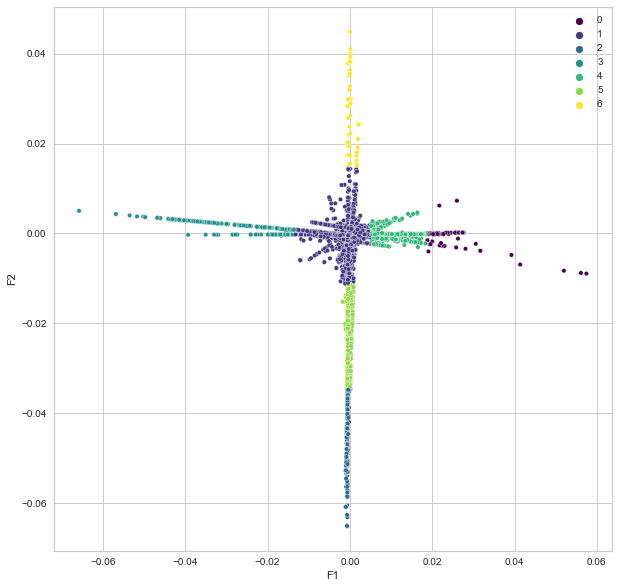

In [217]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(ax=ax, x=data_stat_LLE5.iloc[:, 0], y=data_stat_LLE5.iloc[:, 1], hue=clusters_LLE5, palette=color, s=20)


<AxesSubplot:xlabel='label', ylabel='F2'>

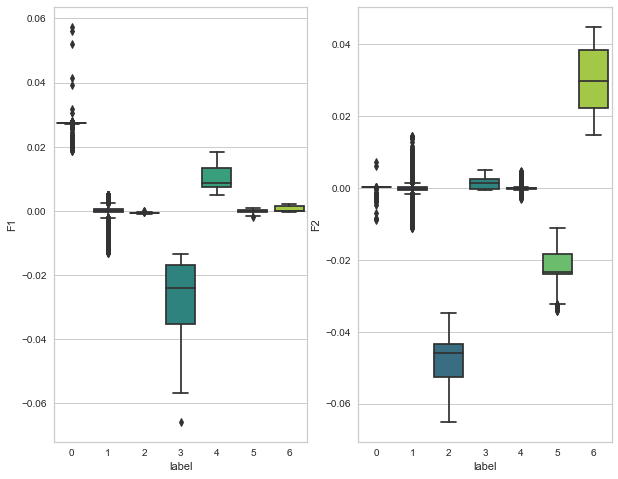

In [218]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
sns.boxplot(ax= ax[0], data=data_stat_LLE5, x='label', y='F1', palette='viridis')
sns.boxplot(ax= ax[1], data=data_stat_LLE5, x='label', y='F2', palette='viridis')

### LLE 3 composantes

In [219]:
X_LLE3 = LocallyLinearEmbedding(n_components=3).fit_transform(X_scaled_LLE)

#### Choix nombre clusters

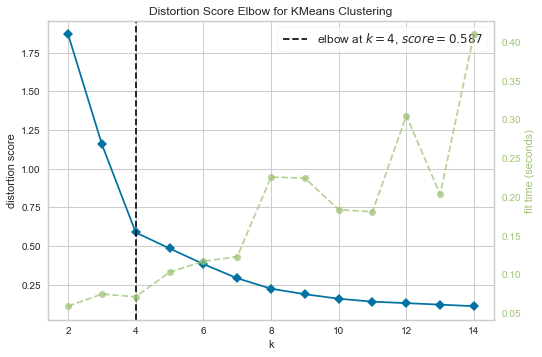

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [220]:
model_tsne = KMeans()
visualizer_tsne = KElbowVisualizer(model_tsne, k=(2,15))
visualizer_tsne.fit(X_LLE3)    
visualizer_tsne.poof()  

#### Silhouette

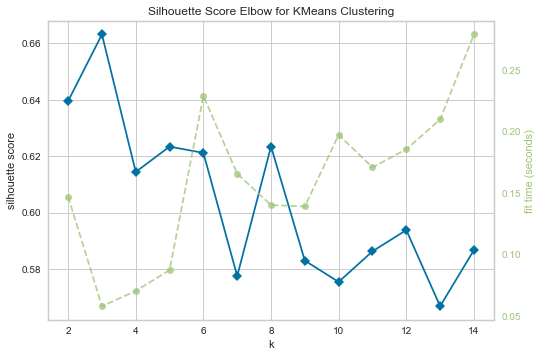

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [221]:
visualizer_tsne = KElbowVisualizer(model_tsne, k=(2,15), metric='silhouette', locate_elbow=False)
visualizer_tsne.fit(X_LLE3)    
visualizer_tsne.poof()  

#### Stability

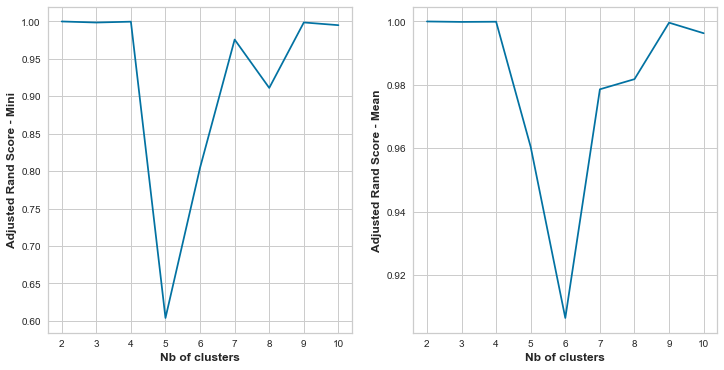

In [222]:
from sklearn.metrics import adjusted_rand_score
stability_KMeans(X_LLE3, 2, 10)

#### Clustering 5 clusters

In [223]:
# Nombre de clusters souhaités
n_clust = 5
km_LLE60 = KMeans(n_clusters= n_clust, random_state=42)
km_LLE60.fit(X_LLE3)

# Récupération des clusters attribués à chaque individu
clusters_LLE60 = km_LLE60.labels_

In [224]:
pd.DataFrame(clusters_LLE60).value_counts()

0    5797
3    2578
1     761
2     603
4     261
dtype: int64

In [225]:
data_stat_LLE60 = pd.DataFrame(X_LLE3).rename(columns={0: 'F1', 1: 'F2', 2: 'F3'})
data_stat_LLE60['label'] = clusters_LLE60

In [226]:
compare_stats(data_stat_LLE60, 'label')

0           1           2            3           4
count count  5797.000000  761.000000  603.000000  2578.000000  261.000000
F1    mean      0.001285    0.016834    0.000060    -0.014637    0.000796
      min      -0.006955   -0.002886   -0.001394    -0.055159   -0.000162
      max       0.055333    0.017697    0.002684    -0.000197    0.001097
F2    mean      0.000771   -0.031072    0.000236    -0.007280    0.000949
      min      -0.016303   -0.031944   -0.000735    -0.052905    0.000215
      max       0.039398   -0.015457    0.001749     0.020786    0.001356
F3    mean     -0.000327    0.000155    0.021697     0.000131    0.047076
      min      -0.044639    0.000078    0.010599    -0.009561    0.034528
      max       0.010660    0.003803    0.034302     0.016048    0.065151

In [227]:
cmap = plt.get_cmap('viridis')
colors = np.linspace(0, 1, 5)
color=[cmap(colors[i]) for i in range(5)]

<AxesSubplot:xlabel='F2', ylabel='F3'>

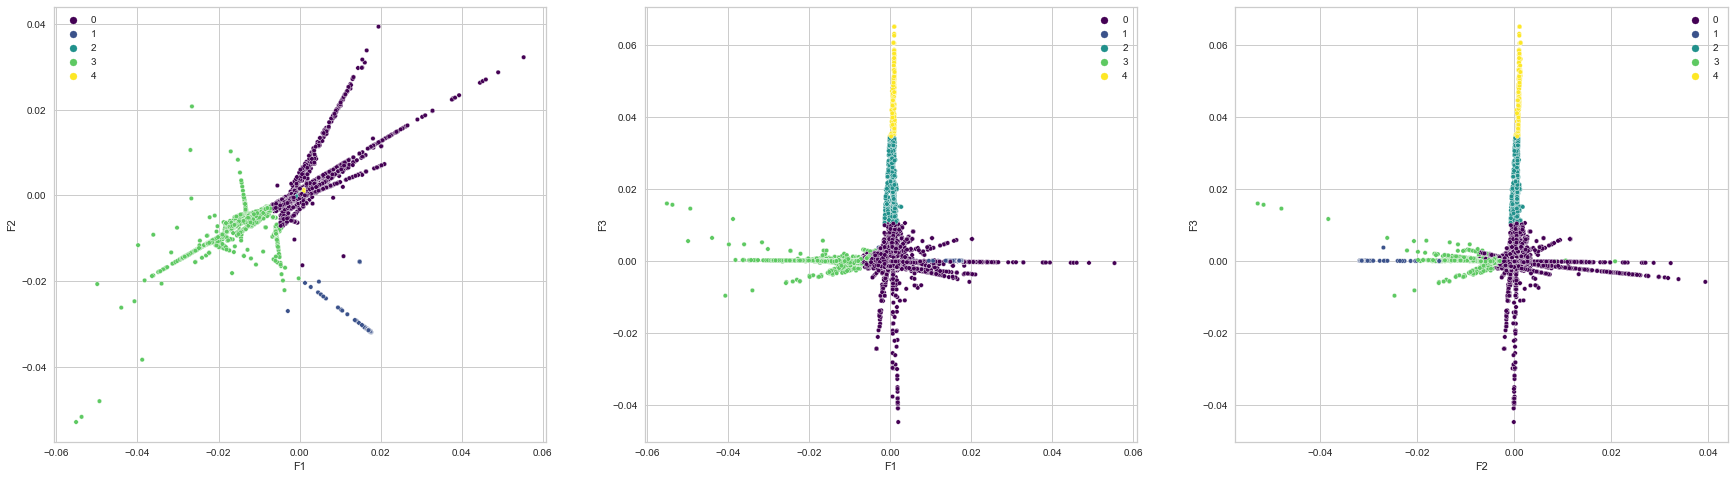

In [228]:
fig, ax = plt.subplots(1, 3, figsize=(30, 8))
sns.scatterplot(ax=ax[0], x=data_stat_LLE60.iloc[:, 0], y=data_stat_LLE60.iloc[:, 1], hue=clusters_LLE60, palette=color, s=20)
sns.scatterplot(ax=ax[1], x=data_stat_LLE60.iloc[:, 0], y=data_stat_LLE60.iloc[:, 2], hue=clusters_LLE60, palette=color, s=20)
sns.scatterplot(ax=ax[2], x=data_stat_LLE60.iloc[:, 1], y=data_stat_LLE60.iloc[:, 2], hue=clusters_LLE60, palette=color, s=20)

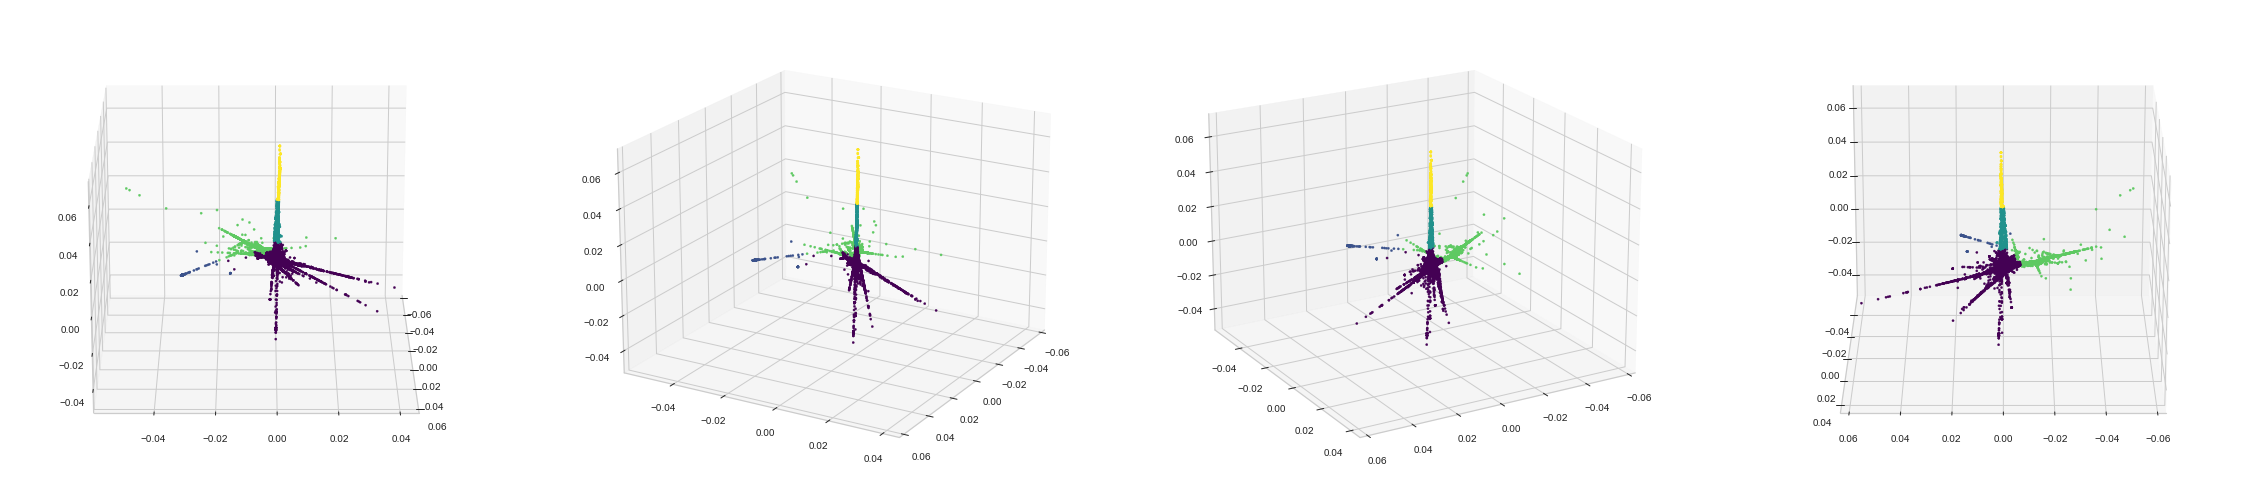

In [229]:
fig= plt.figure(figsize =(40, 20))

x=X_LLE3[:, 0]
y=X_LLE3[:, 1]
z=X_LLE3[:, 2]
labels = clusters_LLE60
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, projection='3d')
    ax.scatter3D(x, y, z, c=labels, cmap='viridis', alpha=1, s=5)
    ax.view_init(20, 30*i)

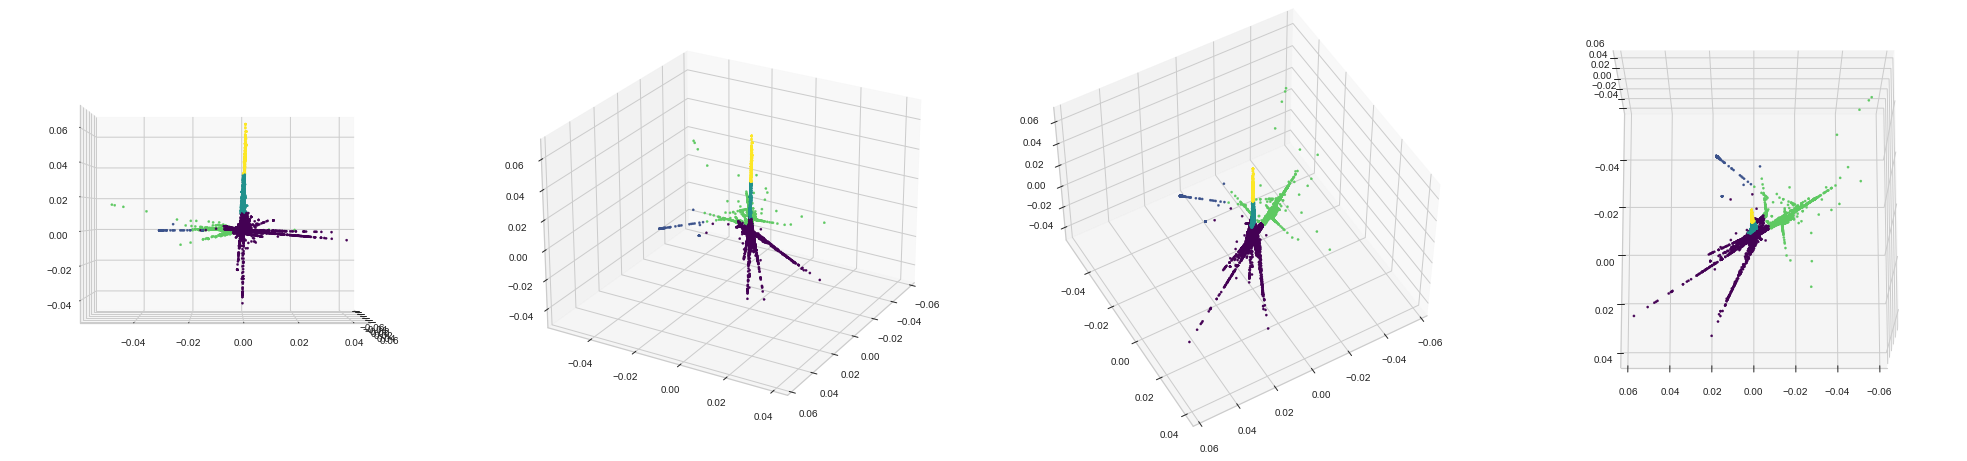

In [230]:
fig= plt.figure(figsize =(35, 15))

x=X_LLE3[:, 0]
y=X_LLE3[:, 1]
z=X_LLE3[:, 2]
labels = clusters_LLE60
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, projection='3d')
    ax.scatter3D(x, y, z, c=labels, cmap='viridis', alpha=1, s=5)
    ax.view_init(25*i, 30*i)

<AxesSubplot:xlabel='label', ylabel='F3'>

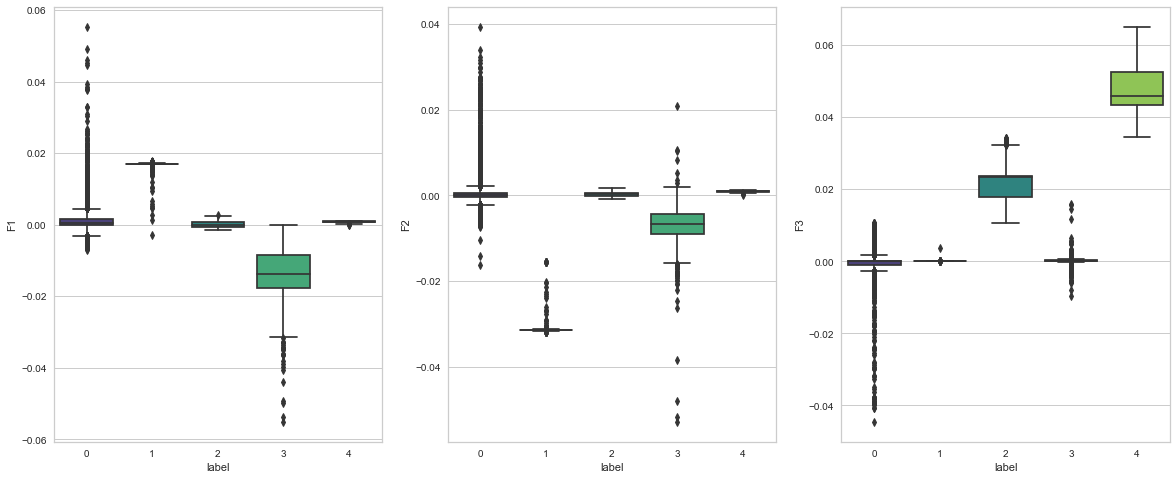

In [231]:
fig, ax = plt.subplots(1, 3, figsize=(20, 8))
sns.boxplot(ax= ax[0], data=data_stat_LLE60, x='label', y='F1', palette='viridis')
sns.boxplot(ax= ax[1], data=data_stat_LLE60, x='label', y='F2', palette='viridis')
sns.boxplot(ax= ax[2], data=data_stat_LLE60, x='label', y='F3', palette='viridis')


# Clustering - utilisation internet

In [232]:
dataK8 = data.loc[:, ['product_name_lenght_mean', 
                         'product_description_lenght_mean', 
                         'product_photos_qty_min',  
                         'nb_review_score_per_order', 
                     'nb_comments_per_order',
                         'nb_dif_sellers']]

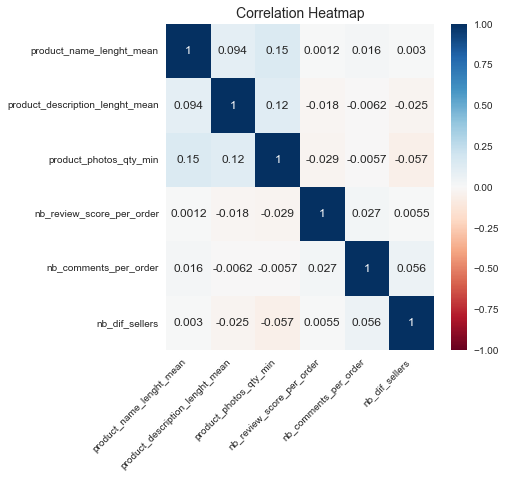

In [287]:
plt.figure(figsize=(6, 6))
sns.heatmap(dataK8.corr(),annot=True,cmap='RdBu', vmin=-1, vmax=1)
plt.title('Correlation Heatmap',fontsize=14)
plt.yticks(rotation =0)
plt.xticks(rotation =45, ha='right', va='top')
plt.show()

In [234]:
X_scaled8 = preprocessing.StandardScaler().fit_transform(dataK8)

### Distortion score

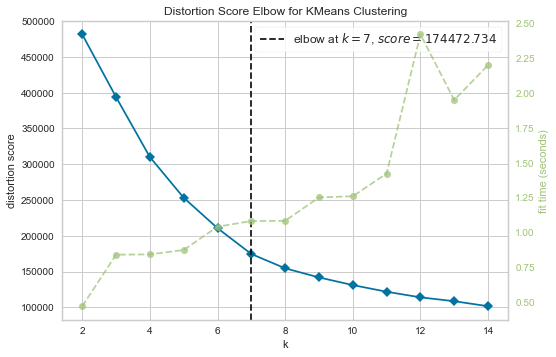

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [235]:
model8 = KMeans()
visualizer8 = KElbowVisualizer(model8, k=(2,15))
visualizer8.fit(X_scaled8)    
visualizer8.poof()  

In [236]:
# Echantillon
dataK_sample8 = dataK8.sample(10000)
X_scaled_sample8 = StandardScaler().fit_transform(dataK_sample8)

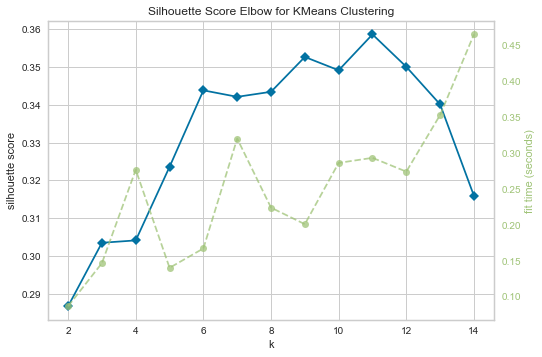

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [237]:
visualizer8 = KElbowVisualizer(model8, k=(2,15), metric='silhouette', locate_elbow=False)
visualizer8.fit(X_scaled_sample8)    
visualizer8.poof()  

### Stability

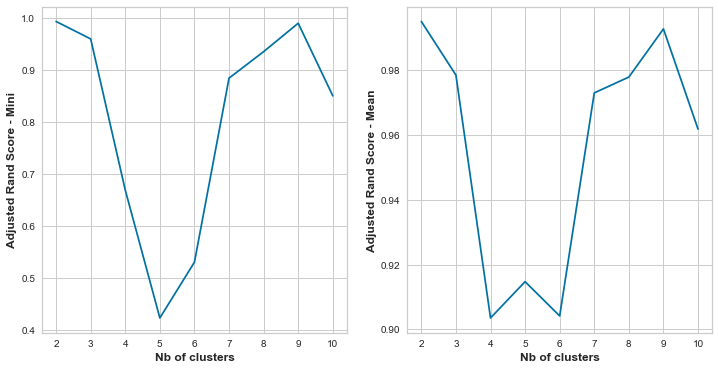

In [238]:
from sklearn.metrics import adjusted_rand_score
stability_KMeans(X_scaled_sample8, 2, 10)

## Clustering avec 7 clusters

In [239]:
X_scaled87 = StandardScaler().fit_transform(dataK8)
# Nombre de clusters souhaités
n_clust = 7
km87 = KMeans(n_clusters= n_clust, random_state=0)
km87.fit(X_scaled87)

# Récupération des clusters attribués à chaque individu
clusters87 = km87.labels_

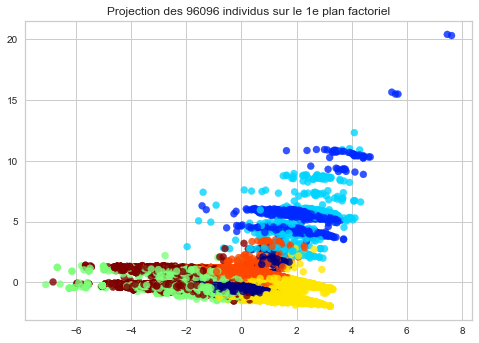

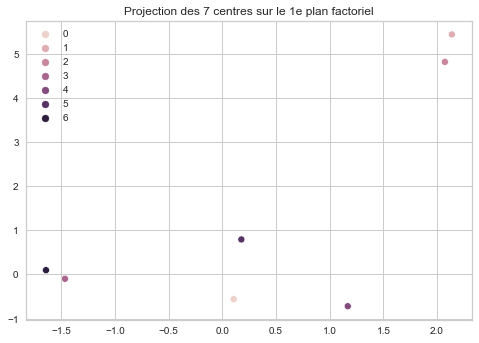

In [240]:
# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=4).fit(X_scaled87)
X_projected = pca.transform(X_scaled87)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters87.astype(np.float64), cmap = 'jet', alpha=.8)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show(block=False)

plt.figure()
centroids = km87.cluster_centers_
centroids_projected = pca.transform(centroids)
sns.scatterplot(x=centroids_projected[:,0],y=centroids_projected[:,1], hue=[0, 1, 2, 3, 4, 5, 6])
plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids)))
plt.show()

### Etude statistique de chaque cluster

In [241]:
data_stat87 = dataK8.copy()
data_stat87['label'] = clusters87

data_stat87['label'].value_counts()

0    30466
5    26969
4    16880
3    12324
6     7889
1     1145
2      423
Name: label, dtype: int64

In [242]:
data_stat87.head(1)

product_name_lenght_mean  product_description_lenght_mean  \
0                      60.0                            236.0   

   product_photos_qty_min  nb_review_score_per_order  nb_comments_per_order  \
0                     1.0                        1.0                    1.0   

   nb_dif_sellers  label  
0             1.0      5

<AxesSubplot:xlabel='label', ylabel='nb_dif_sellers'>

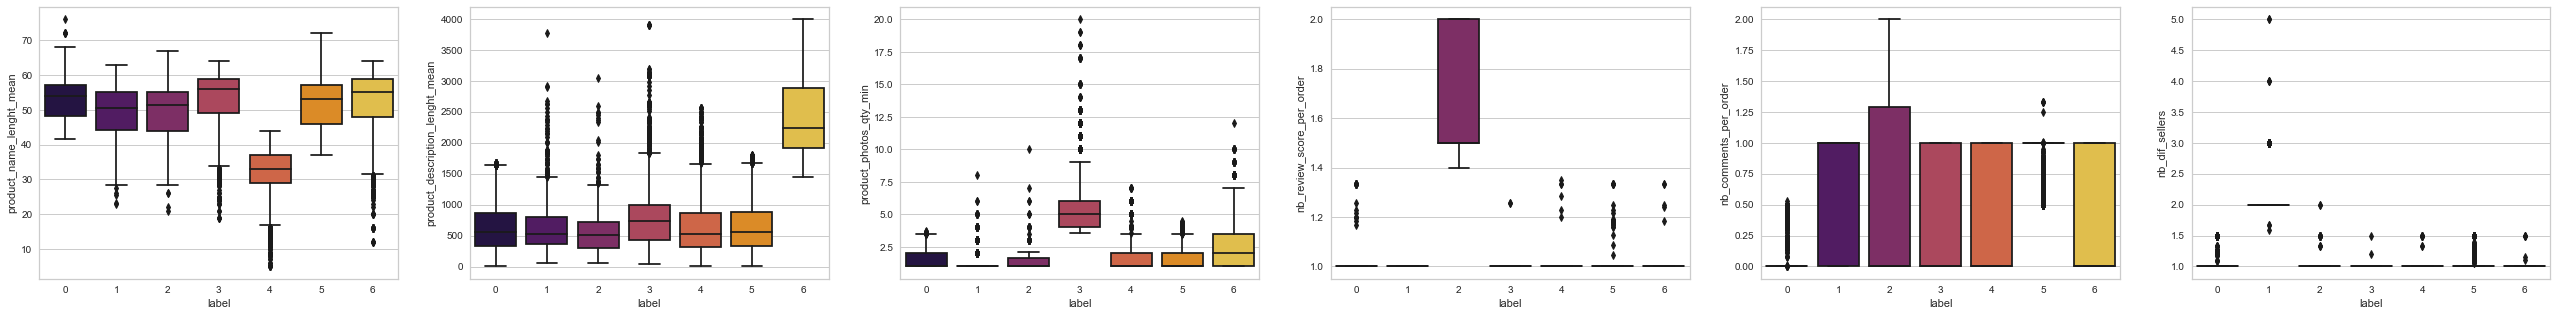

In [243]:
fig, ax = plt.subplots(1, 6, figsize=(45, 5))
sns.boxplot(ax= ax[0], data=data_stat87, x='label', y='product_name_lenght_mean', palette='inferno')
sns.boxplot(ax= ax[1], data=data_stat87, x='label', y='product_description_lenght_mean', palette='inferno')
sns.boxplot(ax= ax[2], data=data_stat87, x='label', y='product_photos_qty_min', palette='inferno')
sns.boxplot(ax= ax[3], data=data_stat87, x='label', y='nb_review_score_per_order', palette='inferno')
sns.boxplot(ax= ax[4], data=data_stat87, x='label', y='nb_comments_per_order', palette='inferno')
sns.boxplot(ax= ax[5], data=data_stat87, x='label', y='nb_dif_sellers', palette='inferno')

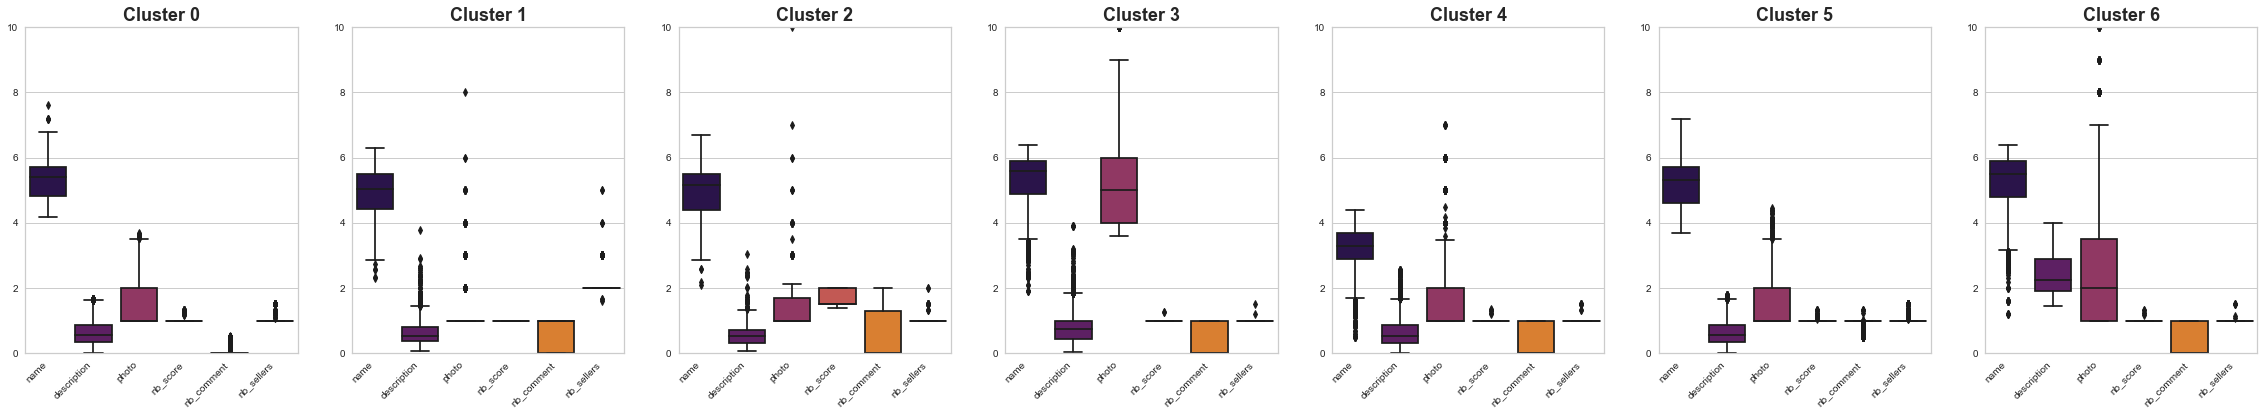

In [244]:
fig, ax = plt.subplots(1, 7, figsize=(40, 6))
for i in range(7):
    data_plot87 = data_stat87.loc[data_stat87['label']==i, ['product_name_lenght_mean', 
                                                            'product_description_lenght_mean', 
                                                            'product_photos_qty_min',  
                                                            'nb_review_score_per_order', 
                                                            'nb_comments_per_order', 
                                                            'nb_dif_sellers']]
    data_plot87['product_description_lenght_mean'] = data_plot87['product_description_lenght_mean'] / 1000
    data_plot87['product_name_lenght_mean'] = data_plot87['product_name_lenght_mean'] / 10
    #data_plot87['review_score_mean'] = data_plot87['review_score_mean'] * 200
    #data_plot87['voucher'] = data_plot87['voucher'] * 20
    #data_plot87['week'] = data_plot87['week'] * 500
    sns.boxplot(ax= ax[i], data=data_plot87, palette='inferno')
    ax[i].set_title(f"Cluster {i}", fontsize=18, weight='bold')
    ax[i].set_xticklabels(['name', 'description', 'photo', 'nb_score', 'nb_comment', 'nb_sellers'], rotation=45, horizontalalignment='right')
    ax[i].set_ylim(0, 10)

In [245]:
# Profil 1 : 2 vendeurs et plus
# profil 4 : nom court
# profil 0 : nom long
# Profil 3 : nombreuses photos
# profil 5 : description courte
# profil 6 : descrition longue
# profil 2 : plus de 1 review

In [246]:
compare_stats(data_stat87, 'label')

0            1            2  \
count                           count  3.046600e+04  1145.000000   423.000000   
product_name_lenght_mean        mean   5.273380e+01    49.065758    49.062423   
                                min    4.175000e+01    23.000000    21.000000   
                                max    7.600000e+01    63.000000    67.000000   
product_description_lenght_mean mean   6.221311e+02   650.467339   601.534188   
                                min    4.000000e+00    62.000000    62.000000   
                                max    1.676000e+03  3771.000000  3053.000000   
product_photos_qty_min          mean   1.536673e+00     1.357205     1.428218   
                                min    1.000000e+00     1.000000     1.000000   
                                max    3.692812e+00     8.000000    10.000000   
nb_review_score_per_order       mean   1.000185e+00     1.000000     1.699733   
                                min    1.000000e+00     1.000000     1.400000   
                                max    1.333333e+00     1.000000     2.000000   
nb_comments_per_order           mean   6.054946e-03     0.653878     0.602114   
                                min   -5.551115e-17     0.000000     0.000000   
                                max    5.307515e-01     1.000000     2.000000   
nb_dif_sellers                  mean   1.000817e+00     2.050588     1.023641   
                                min    1.000000e+00     1.589355     1.000000   
                                max    1.500000e+00     5.000000     2.000000   

                                                  3             4  \
count                           count  12324.000000  16880.000000   
product_name_lenght_mean        mean      53.089582     32.709574   
                                min       19.000000      5.000000   
                                max       64.000000     44.000000   
product_description_lenght_mean mean     767.699088    626.973437   
                                min       38.000000      4.000000   
                                max     3908.000000   2566.000000   
product_photos_qty_min          mean       5.601966      1.715169   
                                min        3.599236      1.000000   
                                max       20.000000      7.000000   
nb_review_score_per_order       mean       1.000042      1.000102   
                                min        1.000000      1.000000   
                                max        1.257147      1.349878   
nb_comments_per_order           mean       0.306870      0.301851   
                                min        0.000000      0.000000   
                                max        1.000000      1.000000   
nb_dif_sellers                  mean       1.000057      1.000276   
                                min        1.000000      1.000000   
                                max        1.500000      1.500000   

                                                  5            6  
count                           count  26969.000000  7889.000000  
product_name_lenght_mean        mean      51.470192    52.482813  
                                min       37.000000    12.000000  
                                max       72.000000    64.000000  
product_description_lenght_mean mean     639.741919  2441.957365  
                                min        4.000000  1454.500000  
                                max     1803.142882  3992.000000  
product_photos_qty_min          mean       1.755595     2.462306  
                                min        1.000000     1.000000  
                                max        4.464392    12.000000  
nb_review_score_per_order       mean       1.000168     1.000170  
                                min        1.000000     1.000000  
                                max        1.333333     1.333333  
nb_comments_per_order           mean       0.995777     0.384671  
                                min        

## Clustering avec 8 clusters

In [247]:
X_scaled88 = StandardScaler().fit_transform(dataK8)
# Nombre de clusters souhaités
n_clust = 9
km88 = KMeans(n_clusters= n_clust, random_state=0)
km88.fit(X_scaled88)

# Récupération des clusters attribués à chaque individu
clusters88 = km88.labels_

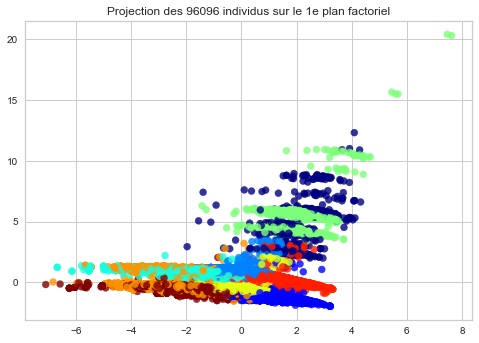

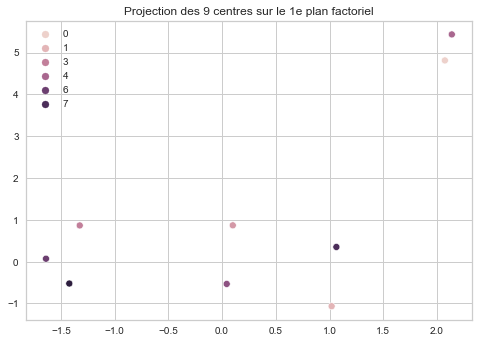

In [248]:
# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=4).fit(X_scaled88)
X_projected = pca.transform(X_scaled88)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters88.astype(np.float64), cmap = 'jet', alpha=.8)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show(block=False)

plt.figure()
centroids = km88.cluster_centers_
centroids_projected = pca.transform(centroids)
sns.scatterplot(x=centroids_projected[:,0],y=centroids_projected[:,1], hue=[0, 1, 2, 3, 4, 5, 6, 7, 8])
plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids)))
plt.show()

### Etude statistique de chaque cluster

In [249]:
data_stat88 = dataK8.copy()
data_stat88['label'] = clusters88

data_stat88['label'].value_counts()

5    27700
2    19385
1    14471
7    10735
8     8705
6     7268
3     6264
4     1145
0      423
Name: label, dtype: int64

In [250]:
data_stat88.head(1)

product_name_lenght_mean  product_description_lenght_mean  \
0                      60.0                            236.0   

   product_photos_qty_min  nb_review_score_per_order  nb_comments_per_order  \
0                     1.0                        1.0                    1.0   

   nb_dif_sellers  label  
0             1.0      2

<AxesSubplot:xlabel='label', ylabel='nb_dif_sellers'>

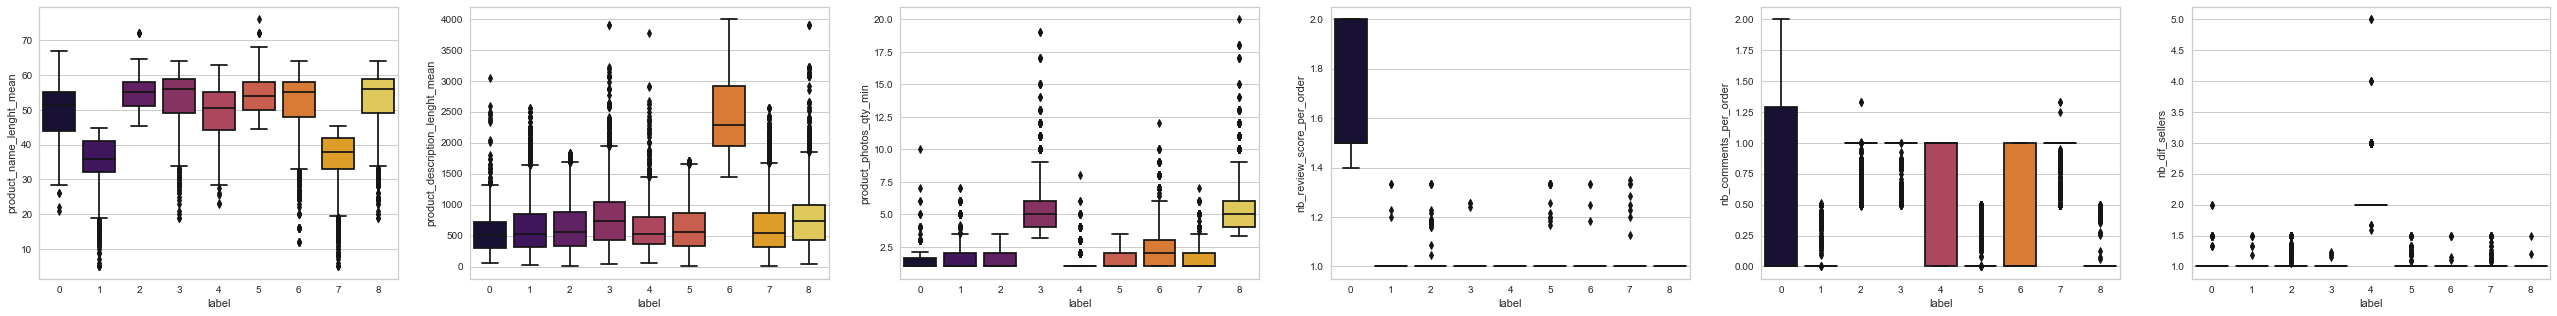

In [251]:
fig, ax = plt.subplots(1, 6, figsize=(45, 5))
sns.boxplot(ax= ax[0], data=data_stat88, x='label', y='product_name_lenght_mean', palette='inferno')
sns.boxplot(ax= ax[1], data=data_stat88, x='label', y='product_description_lenght_mean', palette='inferno')
sns.boxplot(ax= ax[2], data=data_stat88, x='label', y='product_photos_qty_min', palette='inferno')
sns.boxplot(ax= ax[3], data=data_stat88, x='label', y='nb_review_score_per_order', palette='inferno')
sns.boxplot(ax= ax[4], data=data_stat88, x='label', y='nb_comments_per_order', palette='inferno')
sns.boxplot(ax= ax[5], data=data_stat88, x='label', y='nb_dif_sellers', palette='inferno')

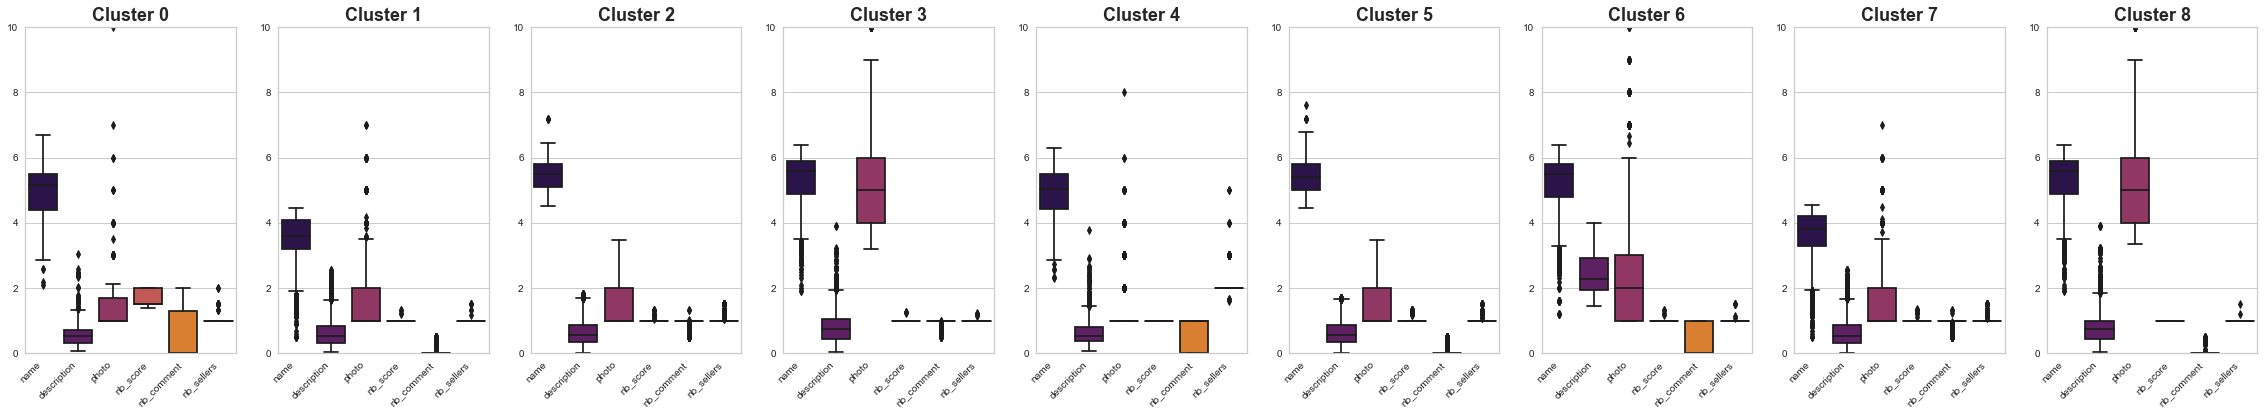

In [252]:
fig, ax = plt.subplots(1, 9, figsize=(40, 6))
for i in range(9):
    data_plot88 = data_stat88.loc[data_stat88['label']==i, ['product_name_lenght_mean', 
                                                            'product_description_lenght_mean', 
                                                            'product_photos_qty_min',  
                                                            'nb_review_score_per_order', 
                                                            'nb_comments_per_order', 
                                                            'nb_dif_sellers']]
    data_plot88['product_description_lenght_mean'] = data_plot88['product_description_lenght_mean'] / 1000
    data_plot88['product_name_lenght_mean'] = data_plot88['product_name_lenght_mean'] / 10
    sns.boxplot(ax= ax[i], data=data_plot88, palette='inferno')
    ax[i].set_title(f"Cluster {i}", fontsize=18, weight='bold')
    ax[i].set_xticklabels(['name', 'description', 'photo', 'nb_score', 'nb_comment', 'nb_sellers'], rotation=45, horizontalalignment='right')
    ax[i].set_ylim(0, 10)

In [253]:
# profil 0 : nb score > 1.4 moyen 
# profil 4 : nb score < 1.4 moyen - plus de 2 vendeurs
# profil 6 : nb score < 1.4 moyen - moins de 2 vendeurs - description en plus de 1 455 mots (plus de 1656 pour 98% des individus)
# profil 2 : nb score < 1.4 moyen - plus de 2 vendeurs - description en moins de 1656 (98.8%) - nb commentaires > 0.5 - nom > 45 mots - nb de photos < 3.2
# profil 7 : nb score < 1.4 moyen - plus de 2 vendeurs - description en moins de 1656 (97.8%) - nb commentaires > 0.5 - nom < 45 mots  
# profil 3 : nb score < 1.4 moyen - plus de 2 vendeurs - description en moins de 1656 (93.3%) - nb commentaires > 0.5 - nb de photos > 3.2
# profil 5 : nb score < 1.4 moyen - plus de 2 vendeurs - description en moins de 1656 (99.8%) - nb commentaires < 0.5 - nom > 45 mots - nb de photos < 3.4
# profil 1 : nb score < 1.4 moyen - plus de 2 vendeurs - description en moins de 1656 (98.4%) - nb commentaires < 0.5 - nom < 45 mots  
# profil 8 : nb score < 1.4 moyen - plus de 2 vendeurs - description en moins de 1656 (95%) - nb commentaires < 0.5 - nb de photos > 3.3

In [254]:
effectif_clusters(data_stat88, 'label')

label  count  percent
0      5  27700     28.8
1      2  19385     20.2
2      1  14471     15.1
3      7  10735     11.2
4      8   8705      9.1
5      6   7268      7.6
6      3   6264      6.5
7      4   1145      1.2
8      0    423      0.4

In [255]:
cluster6 = data_stat88.loc[data_stat88['label']==6]
cluster6.quantile(q=0.02)

product_name_lenght_mean             31.0
product_description_lenght_mean    1656.0
product_photos_qty_min                1.0
nb_review_score_per_order             1.0
nb_comments_per_order                 0.0
nb_dif_sellers                        1.0
label                                 6.0
Name: 0.02, dtype: float64

In [256]:
cluster1 = data_stat88.loc[data_stat88['label']==1]
cluster1.quantile(q=0.984)

product_name_lenght_mean             44.00
product_description_lenght_mean    1658.48
product_photos_qty_min                4.00
nb_review_score_per_order             1.00
nb_comments_per_order                 0.00
nb_dif_sellers                        1.00
label                                 1.00
Name: 0.984, dtype: float64

In [257]:
cluster2 = data_stat88.loc[data_stat88['label']==2]
cluster2.quantile(q=0.988)

product_name_lenght_mean             63.000
product_description_lenght_mean    1644.784
product_photos_qty_min                3.000
nb_review_score_per_order             1.000
nb_comments_per_order                 1.000
nb_dif_sellers                        1.000
label                                 2.000
Name: 0.988, dtype: float64

In [258]:
cluster3 = data_stat88.loc[data_stat88['label']==3]
cluster3.quantile(q=0.933)

product_name_lenght_mean             60.000
product_description_lenght_mean    1647.137
product_photos_qty_min                8.000
nb_review_score_per_order             1.000
nb_comments_per_order                 1.000
nb_dif_sellers                        1.000
label                                 3.000
Name: 0.933, dtype: float64

In [259]:
cluster5 = data_stat88.loc[data_stat88['label']==5]
cluster5.quantile(q=0.998)

product_name_lenght_mean             64.000
product_description_lenght_mean    1658.301
product_photos_qty_min                3.000
nb_review_score_per_order             1.000
nb_comments_per_order                 0.500
nb_dif_sellers                        1.000
label                                 5.000
Name: 0.998, dtype: float64

In [260]:
cluster7 = data_stat88.loc[data_stat88['label']==7]
cluster7.quantile(q=0.978)

product_name_lenght_mean             45.0
product_description_lenght_mean    1654.0
product_photos_qty_min                4.0
nb_review_score_per_order             1.0
nb_comments_per_order                 1.0
nb_dif_sellers                        1.0
label                                 7.0
Name: 0.978, dtype: float64

In [261]:
cluster8 = data_stat88.loc[data_stat88['label']==8]
cluster8.quantile(q=0.95)

product_name_lenght_mean             60.0
product_description_lenght_mean    1648.9
product_photos_qty_min                8.0
nb_review_score_per_order             1.0
nb_comments_per_order                 0.0
nb_dif_sellers                        1.0
label                                 8.0
Name: 0.95, dtype: float64

In [262]:
compare_stats(data_stat88, 'label')

0             1  \
count                           count   423.000000  14471.000000   
product_name_lenght_mean        mean     49.062423     35.337159   
                                min      21.000000      5.000000   
                                max      67.000000     44.676777   
product_description_lenght_mean mean    601.534188    622.827149   
                                min      62.000000     26.000000   
                                max    3053.000000   2566.000000   
product_photos_qty_min          mean      1.428218      1.658071   
                                min       1.000000      1.000000   
                                max      10.000000      7.000000   
nb_review_score_per_order       mean      1.699733      1.000076   
                                min       1.400000      1.000000   
                                max       2.000000      1.333333   
nb_comments_per_order           mean      0.602114      0.002704   
                                min       0.000000      0.000000   
                                max       2.000000      0.514126   
nb_dif_sellers                  mean      1.023641      1.000197   
                                min       1.000000      1.000000   
                                max       2.000000      1.500000   

                                                  2            3            4  \
count                           count  19385.000000  6264.000000  1145.000000   
product_name_lenght_mean        mean      54.211453    53.051278    49.065758   
                                min       45.318886    19.000000    23.000000   
                                max       72.000000    64.000000    63.000000   
product_description_lenght_mean mean     640.106399   802.640056   650.467339   
                                min        4.000000    38.000000    62.000000   
                                max     1828.000000  3908.000000  3771.000000   
product_photos_qty_min          mean       1.556028     5.321562     1.357205   
                                min        1.000000     3.202617     1.000000   
                                max        3.474754    19.000000     8.000000   
nb_review_score_per_order       mean       1.000180     1.000120     1.000000   
                                min        1.000000     1.000000     1.000000   
                                max        1.333333     1.257147     1.000000   
nb_comments_per_order           mean       0.992139     0.996050     0.653878   
                                min        0.488402     0.495546     0.000000   
                                max        1.333333     1.000000     1.000000   
nb_dif_sellers                  mean       1.001923     1.000127     2.050588   
                                min        1.000000     1.000000     1.589355   
                                max        1.500000     1.230244     5.000000   

                                                  5            6  \
count                           count  2.770000e+04  7268.000000   
product_name_lenght_mean        mean   5.367360e+01    52.392468   
                                min    4.450000e+01    12.000000   
                                max    7.600000e+01    64.000000   
product_description_lenght_mean mean   6.282340e+02  2487.467385   
                                min    4.000000e+00  1454.500000   
                                max    1.710000e+03  3992.000000   
product_photos_qty_min          mean   1.548051e+00     2.352034   
                                min    1.000000e+00     1.000000   
                                max    3.471542e+00    12.000000   
nb_review_score_per_order       mean   1.000188e+00     1.000151   
                                min    1.000000e+00     1.000000   
                                max    1.333333e+00     1.333333   
nb_comments_per_order           mean   4.773616e-03     0.363915   
                                min   -5.551115

# Clustering - contenu commande

In [263]:
dataK9 = data.loc[:, ['nb_tot_products', 'product_weight_g_mean',  'nb_diff_cat']]

In [264]:
dataK9 = dataK9.loc[dataK9['nb_diff_cat'].notna()]

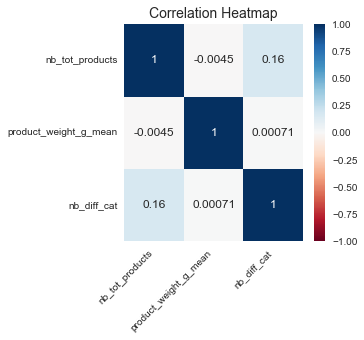

In [288]:
plt.figure(figsize=(4, 4))
sns.heatmap(dataK9.corr(),annot=True,cmap='RdBu', vmin=-1, vmax=1)
plt.title('Correlation Heatmap',fontsize=14)
plt.xticks(rotation =45, ha='right')
plt.yticks(rotation =0)
plt.show()

In [266]:
X_scaled9 = preprocessing.StandardScaler().fit_transform(dataK9)

### Distortion score

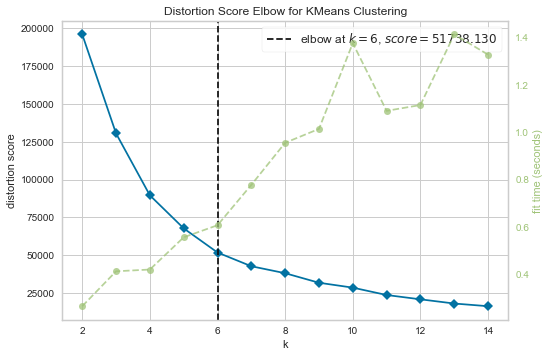

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [267]:
model9 = KMeans()
visualizer9 = KElbowVisualizer(model9, k=(2,15))
visualizer9.fit(X_scaled9)    
visualizer9.poof()  

In [268]:
# Echantillon
dataK_sample9 = dataK9.sample(10000)
X_scaled_sample9 = StandardScaler().fit_transform(dataK_sample9)

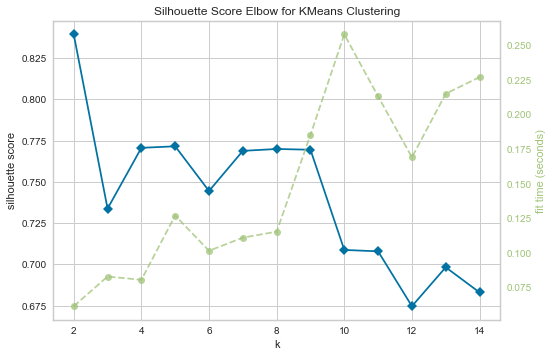

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [269]:
visualizer9 = KElbowVisualizer(model9, k=(2,15), metric='silhouette', locate_elbow=False)
visualizer9.fit(X_scaled_sample9)    
visualizer9.poof()  

### Stability

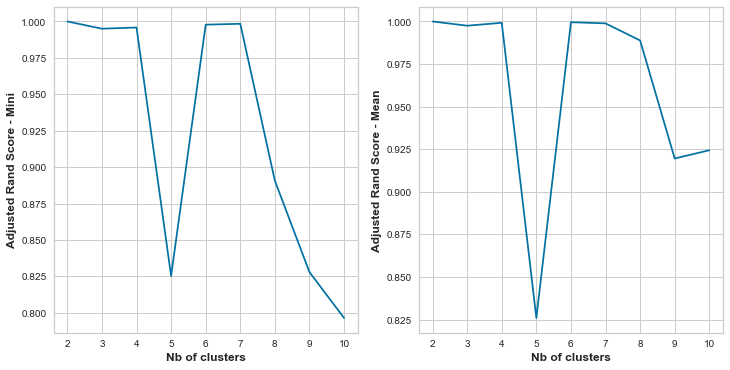

In [270]:
from sklearn.metrics import adjusted_rand_score
stability_KMeans(X_scaled_sample9, 2, 10)

## Clustering avec 4 clusters

In [271]:
X_scaled97 = StandardScaler().fit_transform(dataK9)
# Nombre de clusters souhaités
n_clust = 4
km97 = KMeans(n_clusters= n_clust, random_state=0)
km97.fit(X_scaled97)

# Récupération des clusters attribués à chaque individu
clusters97 = km97.labels_

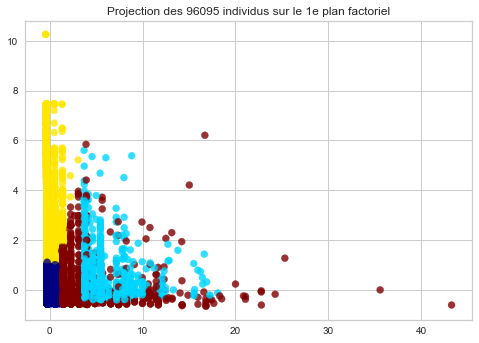

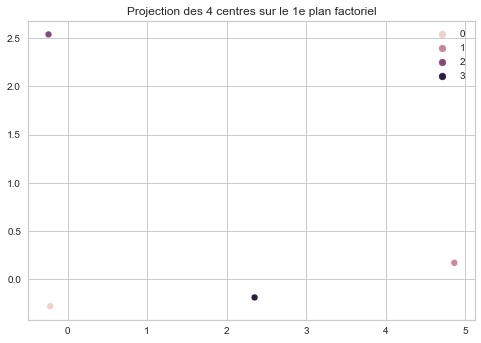

In [272]:
# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=3).fit(X_scaled97)
X_projected = pca.transform(X_scaled97)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters97.astype(np.float64), cmap = 'jet', alpha=.8)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show(block=False)

plt.figure()
centroids = km97.cluster_centers_
centroids_projected = pca.transform(centroids)
sns.scatterplot(x=centroids_projected[:,0],y=centroids_projected[:,1], hue=[0, 1, 2, 3])
plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids)))
plt.show()

### Etude statistique de chaque cluster

In [273]:
data_stat97 = dataK9.copy()
data_stat97['label'] = clusters97

data_stat97['label'].value_counts()

0    81076
2     9050
3     3600
1     2369
Name: label, dtype: int64

In [274]:
data_stat97.head(1)

nb_tot_products  product_weight_g_mean  nb_diff_cat  label
0              1.0                 1500.0          1.0      0

<AxesSubplot:xlabel='label', ylabel='nb_diff_cat'>

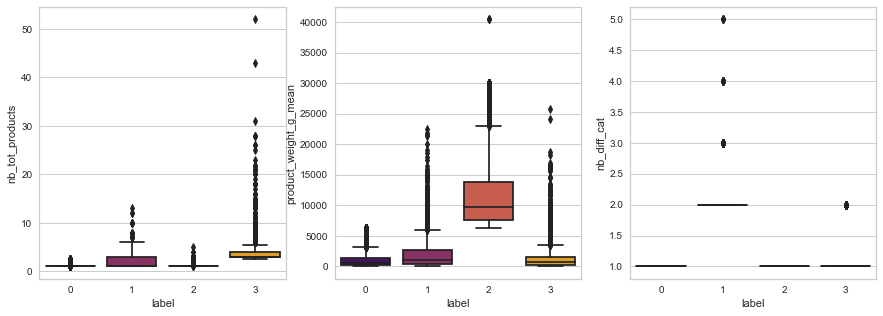

In [275]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(ax= ax[0], data=data_stat97, x='label', y='nb_tot_products', palette='inferno')
sns.boxplot(ax= ax[1], data=data_stat97, x='label', y='product_weight_g_mean', palette='inferno')
sns.boxplot(ax= ax[2], data=data_stat97, x='label', y='nb_diff_cat', palette='inferno')


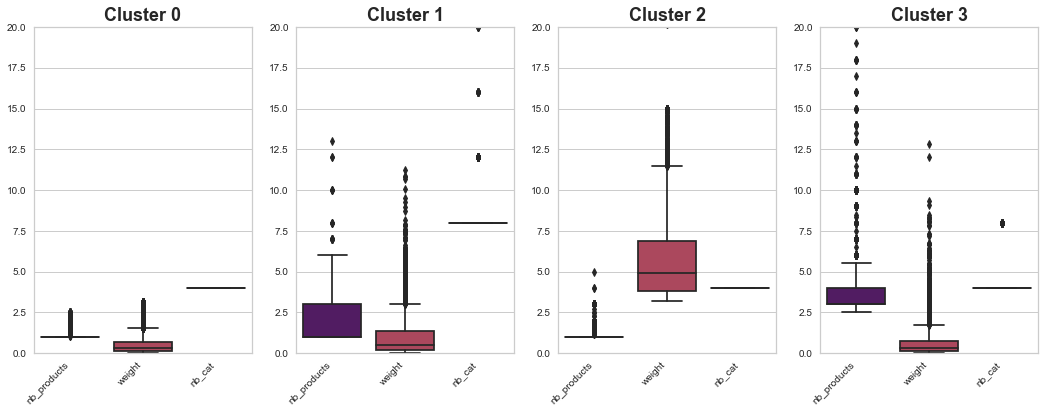

In [276]:
fig, ax = plt.subplots(1, 4, figsize=(18, 6))
for i in range(4):
    data_plot97 = data_stat97.loc[data_stat97['label']==i, ['nb_tot_products', 
                                                            'product_weight_g_mean',  
                                                            'nb_diff_cat']]
    data_plot97['product_weight_g_mean'] = data_plot97['product_weight_g_mean'] / 2000
    data_plot97['nb_diff_cat'] = data_plot97['nb_diff_cat'] * 4
    #data_plot87['review_score_mean'] = data_plot87['review_score_mean'] * 200
    #data_plot87['voucher'] = data_plot87['voucher'] * 20
    #data_plot87['week'] = data_plot87['week'] * 500
    sns.boxplot(ax= ax[i], data=data_plot97, palette='inferno')
    ax[i].set_title(f"Cluster {i}", fontsize=18, weight='bold')
    ax[i].set_xticklabels(['nb_products', 'weight', 'nb_cat'], rotation=45, horizontalalignment='right')
    ax[i].set_ylim(0, 20)

In [277]:
# Profil 1 : plus de 2 catégories
# profil 3 : 2 catégories ou moins - plus de 2.6 produits moyen
# profil 0 : 2 catégories ou moins - moins de 2.6 produits moyen - poids inférieur à 6.325 kg
# Profil 2 : 2 catégories ou moins - moins de 2.6 produits moyen (sauf pour 1.3% d'entre eux) - poids supérieur à 6.350 kg

In [278]:
cluster2 = data_stat97.loc[data_stat97['label']==2]
cluster2.quantile(q=0.987)

nb_tot_products              2.260622
product_weight_g_mean    30000.000000
nb_diff_cat                  1.000000
label                        2.000000
Name: 0.987, dtype: float64

In [279]:
compare_stats(data_stat97, 'label')

0             1             2  \
count                 count  81076.000000   2369.000000   9050.000000   
nb_tot_products       mean       1.054974      1.917419      1.083875   
                      min        1.000000      1.000000      1.000000   
                      max        2.500000     13.000000      5.000000   
product_weight_g_mean mean    1077.362483   2146.633784  11605.427580   
                      min        0.000000     75.000000   6350.000000   
                      max     6325.000000  22462.500000  40425.000000   
nb_diff_cat           mean       1.000000      2.073871      1.000000   
                      min        1.000000      2.000000      1.000000   
                      max        1.000000      5.000000      1.000000   

                                        3  
count                 count   3600.000000  
nb_tot_products       mean       4.025506  
                      min        2.556351  
                      max       52.000000  
product_weight_g_mean mean    1469.522146  
                      min       50.000000  
                      max    25700.000000  
nb_diff_cat           mean       1.009167  
                      min        1.000000  
                      max        2.000000

In [280]:
effectif_clusters(data_stat97, 'label')

label  count  percent
0      0  81076     84.4
1      2   9050      9.4
2      3   3600      3.7
3      1   2369      2.5